In [1062]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../')

import gensim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import graphsemnet.gsn_recursive as gsn
import graphsemnet.semantics as sem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1063]:
sns.set(font_scale=1.5)

# Semantic graph demo

## Building a semantic graph

In [1096]:
fruit_adj = np.array(
    [
        [0, .5, .25, .125],
        [.5, 0, .25, .125],
        [.25, .25, 0., .125],
        [.125, .125, .125, 0.]
    ]
)

fruit_labels = ['apple', 'banana', 'coconut', 'durian']

fruit_graph = gsn.SemanticGraph(fruit_adj, fruit_labels)

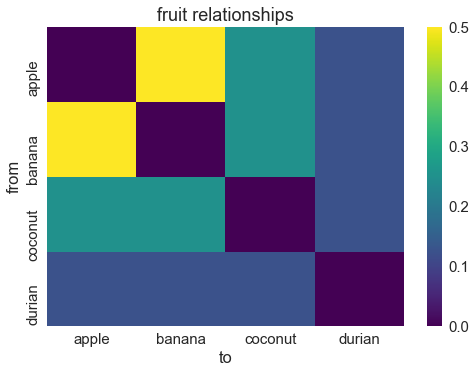

In [1097]:
sns.heatmap(
    fruit_graph.adj, 
    xticklabels=fruit_graph.labels, 
    yticklabels=fruit_graph.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('fruit relationships')

## Building a semantic graph from a pre-trained word2vec model

Rather than guessing our fruit relationship weights (because we are probably wrong), let's pull them from a pre-trained semantic model.

In [1098]:
google_news_w2v_path = '/Users/beau/Desktop/Projects/Language/language_repo/GoogleNews-vectors-negative300.bin'
google_news = gensim.models.KeyedVectors.load_word2vec_format(google_news_w2v_path, binary=True)

In [1099]:
fruit_dsm_w2v = sem.semantic_dsm(['apple', 'banana', 'coconut', 'durian'], google_news)

# Note: now we are using a dissimilarity matrix instead of an adjacency matrix, 
#       so we use the word_dsm argument
fruit_graph_w2v = gsn.SemanticGraph(word_dsm=fruit_dsm_w2v, labels=fruit_labels)

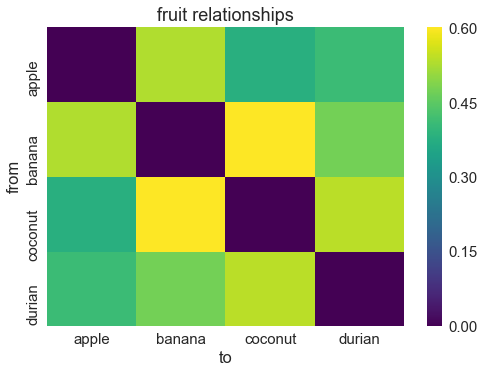

In [1100]:
sns.heatmap(
    fruit_graph_w2v.adj, 
    xticklabels=fruit_graph_w2v.labels, 
    yticklabels=fruit_graph_w2v.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('fruit relationships')

## Activating a node changes weights across the network

On the non-monotonic plasticity hypothesis (NMPH), as activation spreads across the nodes of the network, the edges are updated such that strong edges are further strengthened and weak edges are further weakened.

In [1101]:
xcal = gsn.get_xcal(
    dip_center=.3,
    dip_width=.3,
    min_adjust=-.05,
    max_adjust=.05
)

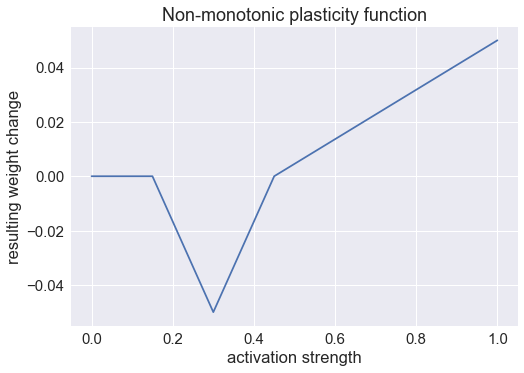

In [1102]:
xs = np.linspace(0, 1., 101)
ys = xcal(xs)
plt.plot(xs, ys)
plt.xlabel('activation strength')
plt.ylabel('resulting weight change')
plt.title('Non-monotonic plasticity function')

Note that the positions of the inflection points in the NMPH equation are only meaningful relative to what counts as a "strong" connection weight in a specific adjacency matrix. Here we've plotted an NMPH function where the apple -> coconut connection is in the "zone of destruction."

We need to make sure our graph uses the correct re-weighting function (we'll use the same function plotted above).

In [1103]:
fruit_graph_w2v.set_xcal(
    dip_center=.3,
    dip_width=.3,
    min_adjust=-.05,
    max_adjust=.05
)


When a node on the graph is activated, the activation spreads and adjacency matrix weights are automatically adjusted.

Repeatedly activating a single node will:

- (First order) Strengthen its already-strong connections to other nodes
- (First order) Weaken its already-weak connections
- (Second order) Strengthen or weaken downstream connections from other nodes depending on whether the activity is strong _when it arrives_ at those nodes

What happens when we activate one node over and over again.

In [1104]:
for _ in range(15):
    acts = fruit_graph_w2v.activate_hebb(np.array([1,0,0,0]), decay=.9, debug=False)
    fruit_graph_w2v.weight_adjust_hebb(acts)

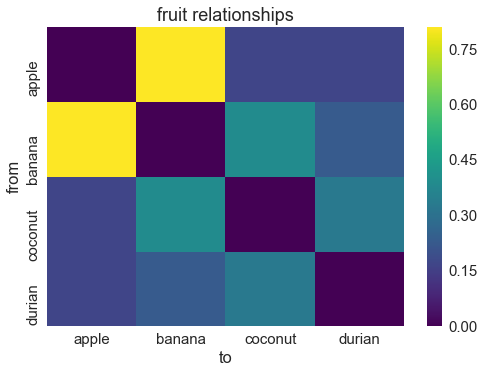

In [1105]:
sns.heatmap(
    fruit_graph_w2v.adj, 
    xticklabels=fruit_graph_w2v.labels, 
    yticklabels=fruit_graph_w2v.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('fruit relationships')

### Replicating retrieval-induced forgetting results

This model captures the dynamics of retrieval-induced forgetting in cued retrieval practice, where category exemplars are associated with each other and also to a category label (e.g., Goodmon & Anderson, 2011).

In [1073]:
goodmon_words = [
    'lion', 'tiger', 
    'horse', 'pony', 
    'walrus', 'seal', 
    'duck', 'goose',
    'lawyer', 'judge',
    'chef', 'baker',
    'nurse', 'doctor',
    'president', 'senator',
    'animal',
    'profession'
]

goodmon_dsm = sem.semantic_dsm(goodmon_words, google_news)
goodmon_graph = gsn.SemanticGraph(word_dsm=goodmon_dsm, labels=goodmon_words)
goodmon_graph.directed = True

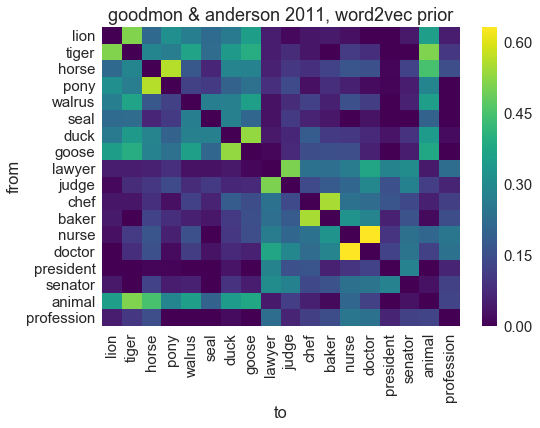

In [1074]:
sns.heatmap(
    goodmon_graph.adj, 
    xticklabels=goodmon_graph.labels, 
    yticklabels=goodmon_graph.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('goodmon & anderson 2011, word2vec prior')

Items in this network are more distantly related than our fruits, so we'll use a slightly different NMPH re-weighting function. We'll also increase stronger connections more than we decrease weak ones.

In [1075]:
goodmon_graph.set_xcal(
    dip_center=.2,
    dip_width=.2,
    min_adjust=-.025,
    max_adjust=.05
)

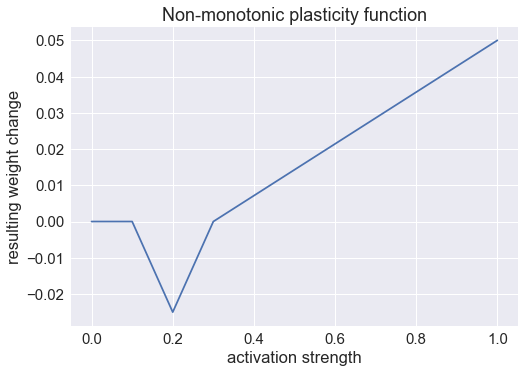

In [1076]:
xs = np.linspace(0, 1., 101)
ys = goodmon_graph.xcal(xs)
plt.plot(xs, ys)
plt.xlabel('activation strength')
plt.ylabel('resulting weight change')
plt.title('Non-monotonic plasticity function')

This paradigm includes a **study** phase where exemplar words are associated with their category label (we assume this sets the weight to a value just above the zone of destruction).

In [1077]:
# Study category-to-exemplar associations
goodmon_graph.adj[-2, 0:8] = goodmon_graph.xcal_dip_center + (goodmon_graph.xcal_dip_width / 2) + .15
goodmon_graph.adj[-1, 8:16] = goodmon_graph.xcal_dip_center + (goodmon_graph.xcal_dip_width / 2) + .15

# Study exemplar-to-category associations
# Make these weaker than the category-to-exemplar associations
# (This is plausible, and it prevents runaway behavior over many trials)
goodmon_graph.adj[0:8, -2] = goodmon_graph.xcal_dip_center + (goodmon_graph.xcal_dip_width / 2) + .15
goodmon_graph.adj[8:16, -1] = goodmon_graph.xcal_dip_center + (goodmon_graph.xcal_dip_width / 2) + .15

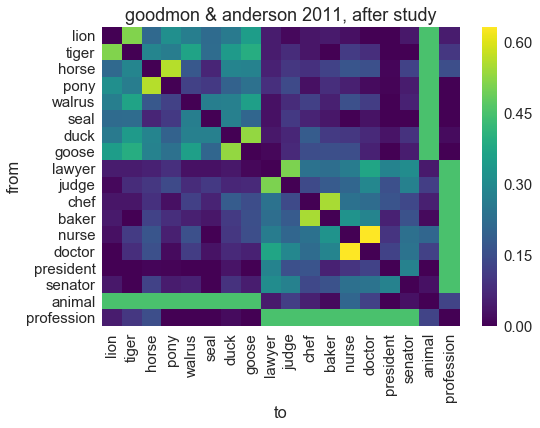

In [1078]:
sns.heatmap(
    goodmon_graph.adj, 
    xticklabels=goodmon_graph.labels, 
    yticklabels=goodmon_graph.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('goodmon & anderson 2011, after study')

What happens when we practice cued recall on some—but not all—exemplar words from a category?

We implement cued recall as an activation of both the category label and the exemplar.

In [1058]:
def cued_recall(category, exemplar, graph, decay=.25):
    category_i = graph.labels.index(category)
    exemplar_i = graph.labels.index(exemplar)
    activation = np.zeros(len(graph.labels))
    activation[category_i] = 1
    activation[exemplar_i] = 1
    acts = graph.activate_hebb(activation, decay=decay, debug=False)
    graph.weight_adjust_hebb(acts, debug=False)

In [1080]:
for _ in range(5):
    cued_recall('animal', 'lion', goodmon_graph)
    cued_recall('animal', 'horse', goodmon_graph)
    cued_recall('animal', 'walrus', goodmon_graph)
    cued_recall('animal', 'duck', goodmon_graph)

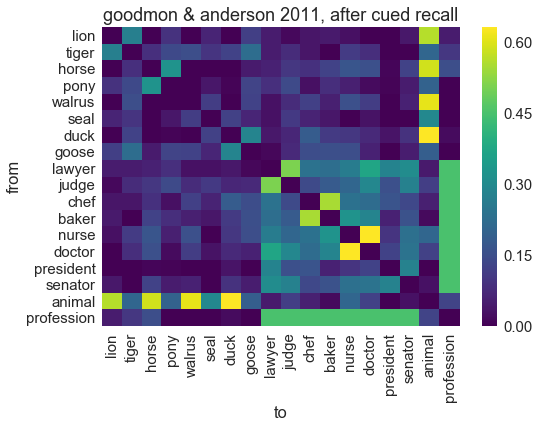

In [1081]:
sns.heatmap(
    goodmon_graph.adj, 
    xticklabels=goodmon_graph.labels, 
    yticklabels=goodmon_graph.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('goodmon & anderson 2011, after cued recall')

We can see that inter-exemplar connections are weakened, and the category-to-exemplar connections are also weakened for within-category words where cued recall was not practiced.

Although Goodmon & Anderson predict that closely related category pairs protect each other against RIF, that does not emerge from our model.

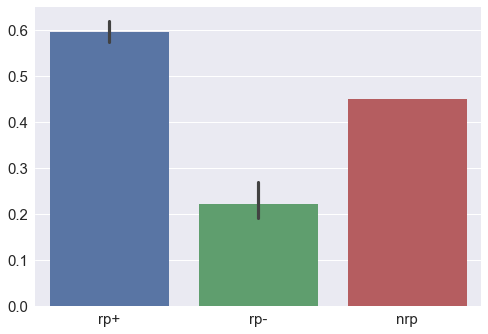

In [1082]:
rp_plus = goodmon_graph.adj[-2, [0, 2, 4, 6]]
rp_minus = goodmon_graph.adj[-2, [1, 3, 5, 7]]
nrp = goodmon_graph.adj[-1, 8:16]

ax = sns.barplot(data=[rp_plus, rp_minus, nrp])
ax.set(xticklabels=['rp+', 'rp-', 'nrp']);

## don't pay attention to the stuff below

it's all grid search stuff

In [970]:
goodmon_dsm_intra = sem.semantic_dsm(goodmon_words, google_news)
goodmon_graph_intra = gsn.SemanticGraph(word_dsm=goodmon_dsm, labels=goodmon_words)
goodmon_graph_intra.directed = True
goodmon_graph_intra.set_xcal(
    dip_center=.2,
    dip_width=.2,
    min_adjust=-.05,
    max_adjust=.15
)
# Study category-to-exemplar associations
goodmon_graph_intra.adj[-2, 0:8] = goodmon_graph_intra.xcal_dip_center + (goodmon_graph_intra.xcal_dip_width / 2) + .2
goodmon_graph_intra.adj[-1, 8:16] = goodmon_graph_intra.xcal_dip_center + (goodmon_graph_intra.xcal_dip_width / 2) + .2

# Study exemplar-to-category associations
# Make these weaker than the category-to-exemplar associations
# (This is plausible, and it prevents runaway behavior over many trials)
goodmon_graph_intra.adj[0:8, -2] = goodmon_graph_intra.xcal_dip_center + (goodmon_graph_intra.xcal_dip_width / 2) + .11
goodmon_graph_intra.adj[8:16, -1] = goodmon_graph_intra.xcal_dip_center + (goodmon_graph_intra.xcal_dip_width / 2) + .11

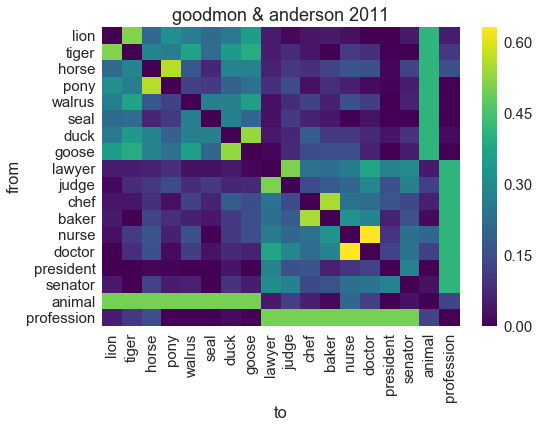

In [971]:
sns.heatmap(
    goodmon_graph_intra.adj, 
    xticklabels=goodmon_graph_intra.labels, 
    yticklabels=goodmon_graph_intra.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('goodmon & anderson 2011')

In [693]:
for _ in range(8):
    cued_recall('animal', 'lion', goodmon_graph_intra)
    cued_recall('animal', 'tiger', goodmon_graph_intra)
    cued_recall('animal', 'horse', goodmon_graph_intra)
    cued_recall('animal', 'pony', goodmon_graph_intra)

animal at strength 1.0
[ 0.8   0.8   0.8   0.8   0.44  0.44  0.44  0.44  0.03  0.09  0.04  0.01
  0.1   0.1   0.    0.02  0.    0.1 ]
Updating edge: animal -> lion, + 0.10613245979062638
lion at strength 0.7952848123562565
[ 0.    0.09  0.08  0.08  0.08  0.08  0.08  0.09  0.03  0.01  0.02  0.03
  0.02  0.    0.    0.03  0.    0.03]
Updating edge: animal -> tiger, + 0.10613245979062638
tiger at strength 0.7952848123562565
[ 0.09  0.    0.08  0.08  0.09  0.08  0.08  0.09  0.03  0.05  0.02  0.
  0.07  0.05  0.    0.    0.    0.06]
Updating edge: animal -> horse, + 0.10613245979062638
horse at strength 0.7952848123562565
[ 0.08  0.08  0.    0.09  0.08  0.04  0.08  0.08  0.04  0.06  0.06  0.08
  0.08  0.08  0.01  0.08  0.    0.08]
Updating edge: animal -> pony, + 0.10714285714285715
pony at strength 0.8
[ 0.08  0.08  0.09  0.    0.08  0.07  0.08  0.08  0.05  0.08  0.02  0.05
  0.04  0.01  0.    0.03  0.    0.  ]
Updating edge: animal -> walrus, + 0.029270570554215534
walrus at strength 0.43

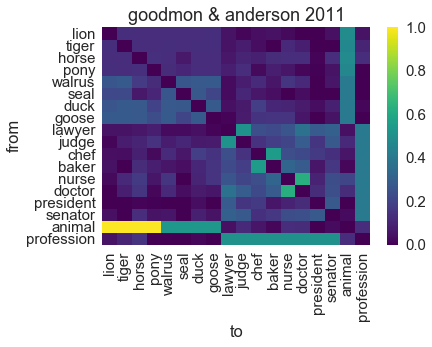

In [690]:
goodmon_graph_intra.activate('animal', debug=True)
goodmon_graph_intra.activate('lion', debug=True)
goodmon_graph_intra.activate('animal', debug=True)
goodmon_graph_intra.activate('tiger', debug=True)
    
sns.heatmap(
    goodmon_graph_intra.adj, 
    xticklabels=goodmon_graph_intra.labels, 
    yticklabels=goodmon_graph_intra.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('goodmon & anderson 2011')

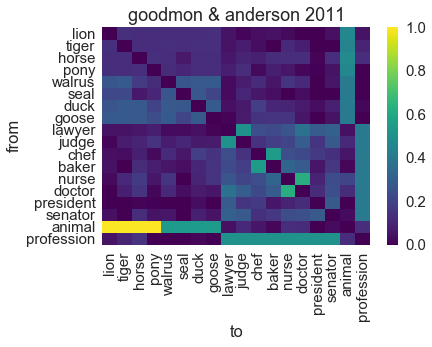

In [695]:
sns.heatmap(
    goodmon_graph_intra.adj, 
    xticklabels=goodmon_graph_intra.labels, 
    yticklabels=goodmon_graph_intra.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('goodmon & anderson 2011')

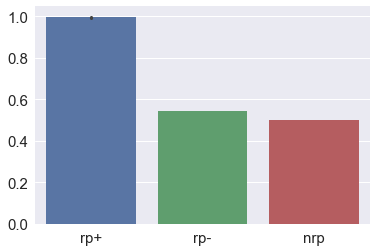

In [694]:
rp_plus = goodmon_graph_intra.adj[-2, [0, 1, 2, 3]]
rp_minus = goodmon_graph_intra.adj[-2, [4, 5, 6, 7]]
nrp = goodmon_graph_intra.adj[-1, 8:16]

ax = sns.barplot(data=[rp_plus, rp_minus, nrp])
ax.set(xticklabels=['rp+', 'rp-', 'nrp']);

In [975]:
import copy

original_dsm = sem.semantic_dsm(goodmon_words, google_news)
original_g = gsn.SemanticGraph(word_dsm=goodmon_dsm, labels=goodmon_words)
original_g.directed = True

def exp_intra(gamma, xcat_center, xcat_width, xcat_min, xcat_max):
    g = copy.copy(original_g)
    g.set_xcal(
        dip_center=xcat_center,
        dip_width=xcat_width,
        min_adjust=xcat_min,
        max_adjust=xcat_max
    )
    
    # Study
    g.adj[-2, 0:8] = g.xcal_dip_center + (g.xcal_dip_width / 2) + .15
    g.adj[-1, 8:16] = g.xcal_dip_center + (g.xcal_dip_width / 2) + .15
    g.adj[0:8, -2] = g.xcal_dip_center + (g.xcal_dip_width / 2) + .15
    g.adj[8:16, -1] = g.xcal_dip_center + (g.xcal_dip_width / 2) + .15
    
    # Cued retrieval practice
    for _ in range(8):
        cued_recall('animal', 'lion', g)
        cued_recall('animal', 'tiger', g)
        cued_recall('animal', 'horse', g)
        cued_recall('animal', 'pony', g)

    return g

def exp_inter(gamma, xcat_center, xcat_width, xcat_min, xcat_max):
    g = copy.copy(original_g)
    g.set_xcal(
        dip_center=xcat_center,
        dip_width=xcat_width,
        min_adjust=xcat_min,
        max_adjust=xcat_max
    )
    
    # Study
    g.adj[-2, 0:8] = g.xcal_dip_center + (g.xcal_dip_width / 2) + .15
    g.adj[-1, 8:16] = g.xcal_dip_center + (g.xcal_dip_width / 2) + .15
    g.adj[0:8, -2] = g.xcal_dip_center + (g.xcal_dip_width / 2) + .15
    g.adj[8:16, -1] = g.xcal_dip_center + (g.xcal_dip_width / 2) + .15
    
    # Cued retrieval practice
    for _ in range(8):
        cued_recall('animal', 'horse', g)
        cued_recall('animal', 'lion', g)
        cued_recall('animal', 'walrus', g)
        cued_recall('animal', 'duck', g)

    return g

In [977]:
results = []

i = 0
for gamma in [.15, .3, .5, .7]:
    for xcat_center in [.1, .15, .2, .25]:
        for xcat_width in [.05, .1, .15, .2]:
            if xcat_center - (xcat_width / 2) <= 0:
                print('bad params, continuing')
                continue
            for xcat_min in [-.025, -.05, -.1, -.15, -.2]:
                for xcat_max in [.025, .05, .1, .15, .2]:
                    print(f"{i} g:{gamma} c:{xcat_center} w:{xcat_width} mi:{xcat_min} ma:{xcat_max}")
                    results.append({
                        'gamma': gamma,
                        'xcat_center': xcat_center,
                        'xcat_width': xcat_width,
                        'xcat_min': xcat_min,
                        'xcat_max': xcat_max,
                        'intra': exp_intra(gamma, xcat_center, xcat_width, xcat_min, xcat_max),
                        'inter': exp_inter(gamma, xcat_center, xcat_width, xcat_min, xcat_max)
                    })
                    i += 1

0 g:0.15 c:0.1 w:0.05 mi:-0.025 ma:0.025
1 g:0.15 c:0.1 w:0.05 mi:-0.025 ma:0.05
2 g:0.15 c:0.1 w:0.05 mi:-0.025 ma:0.1
3 g:0.15 c:0.1 w:0.05 mi:-0.025 ma:0.15
4 g:0.15 c:0.1 w:0.05 mi:-0.025 ma:0.2
5 g:0.15 c:0.1 w:0.05 mi:-0.05 ma:0.025
6 g:0.15 c:0.1 w:0.05 mi:-0.05 ma:0.05
7 g:0.15 c:0.1 w:0.05 mi:-0.05 ma:0.1
8 g:0.15 c:0.1 w:0.05 mi:-0.05 ma:0.15
9 g:0.15 c:0.1 w:0.05 mi:-0.05 ma:0.2
10 g:0.15 c:0.1 w:0.05 mi:-0.1 ma:0.025
11 g:0.15 c:0.1 w:0.05 mi:-0.1 ma:0.05
12 g:0.15 c:0.1 w:0.05 mi:-0.1 ma:0.1
13 g:0.15 c:0.1 w:0.05 mi:-0.1 ma:0.15
14 g:0.15 c:0.1 w:0.05 mi:-0.1 ma:0.2
15 g:0.15 c:0.1 w:0.05 mi:-0.15 ma:0.025
16 g:0.15 c:0.1 w:0.05 mi:-0.15 ma:0.05
17 g:0.15 c:0.1 w:0.05 mi:-0.15 ma:0.1
18 g:0.15 c:0.1 w:0.05 mi:-0.15 ma:0.15
19 g:0.15 c:0.1 w:0.05 mi:-0.15 ma:0.2
20 g:0.15 c:0.1 w:0.05 mi:-0.2 ma:0.025
21 g:0.15 c:0.1 w:0.05 mi:-0.2 ma:0.05
22 g:0.15 c:0.1 w:0.05 mi:-0.2 ma:0.1
23 g:0.15 c:0.1 w:0.05 mi:-0.2 ma:0.15
24 g:0.15 c:0.1 w:0.05 mi:-0.2 ma:0.2
25 g:0.15 c:0.1 w:0.

ValueError: A value in x_new is above the interpolation range.

0 g:0.15 c:0.1 w:0.05 mi:-0.025 ma:0.025


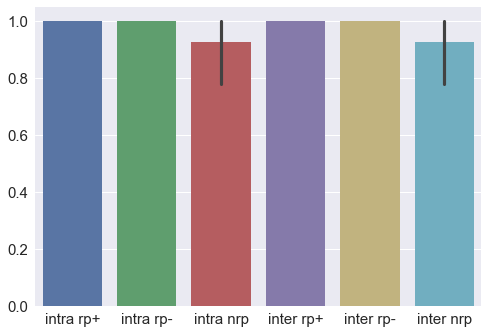

1 g:0.15 c:0.1 w:0.05 mi:-0.025 ma:0.05


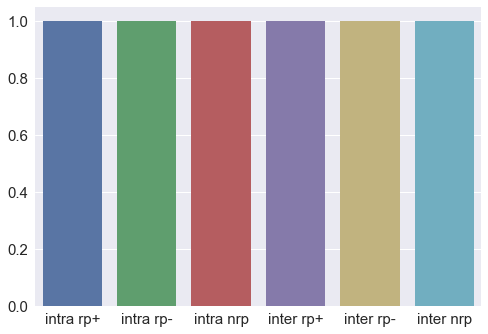

2 g:0.15 c:0.1 w:0.05 mi:-0.025 ma:0.1


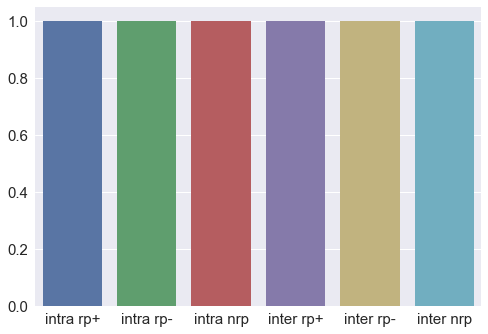

3 g:0.15 c:0.1 w:0.05 mi:-0.025 ma:0.15


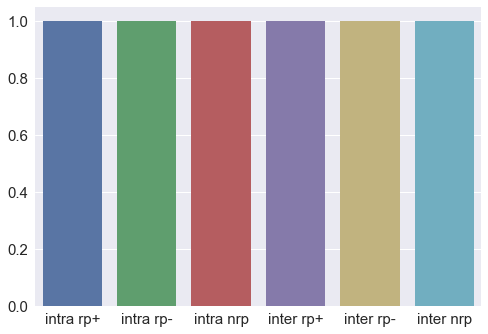

4 g:0.15 c:0.1 w:0.05 mi:-0.025 ma:0.2


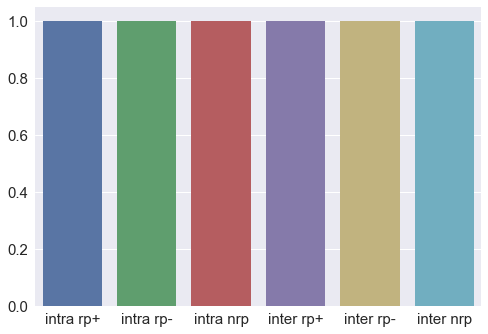

5 g:0.15 c:0.1 w:0.05 mi:-0.05 ma:0.025


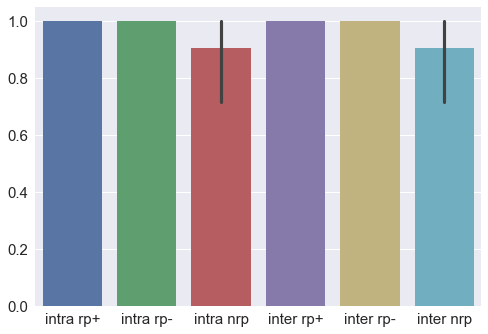

6 g:0.15 c:0.1 w:0.05 mi:-0.05 ma:0.05


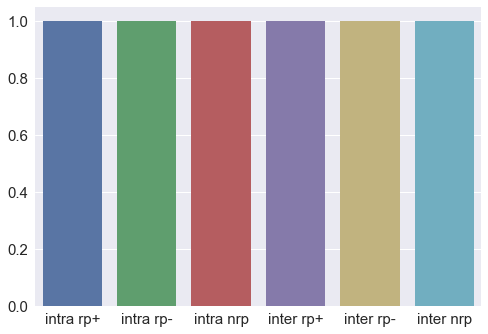

7 g:0.15 c:0.1 w:0.05 mi:-0.05 ma:0.1


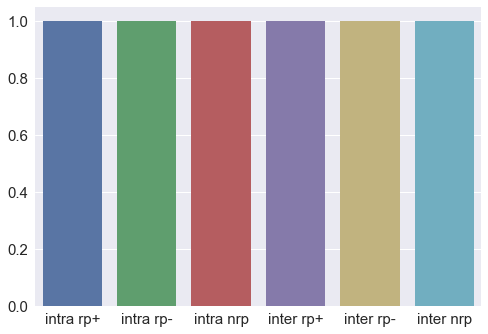

8 g:0.15 c:0.1 w:0.05 mi:-0.05 ma:0.15


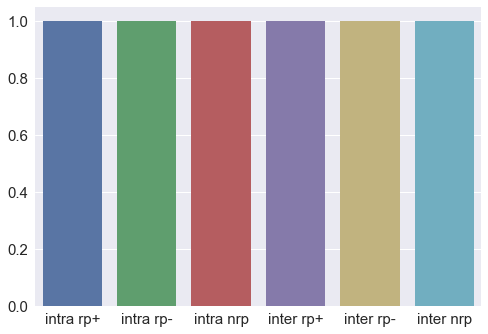

9 g:0.15 c:0.1 w:0.05 mi:-0.05 ma:0.2


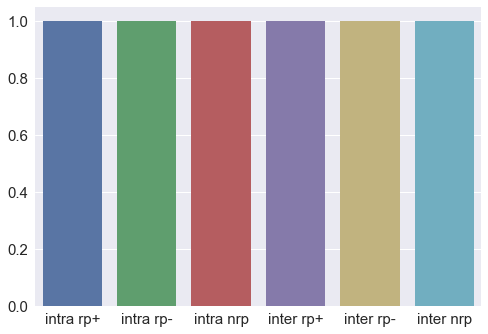

10 g:0.15 c:0.1 w:0.05 mi:-0.1 ma:0.025


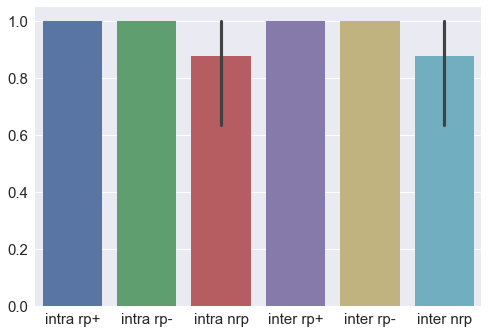

11 g:0.15 c:0.1 w:0.05 mi:-0.1 ma:0.05


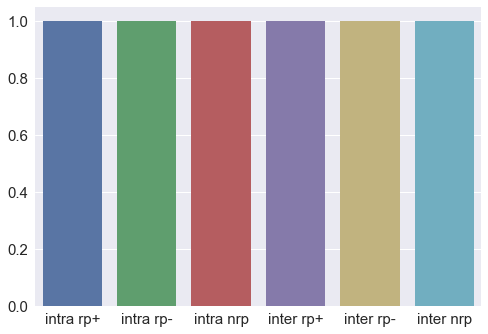

12 g:0.15 c:0.1 w:0.05 mi:-0.1 ma:0.1


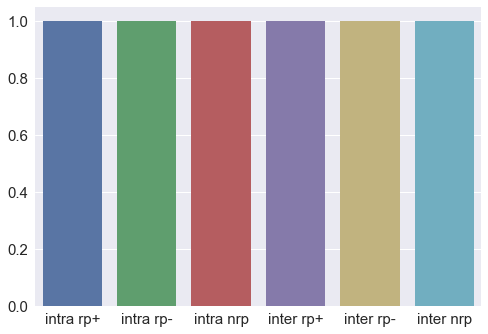

13 g:0.15 c:0.1 w:0.05 mi:-0.1 ma:0.15


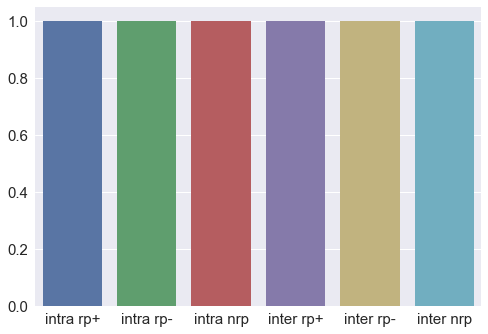

14 g:0.15 c:0.1 w:0.05 mi:-0.1 ma:0.2


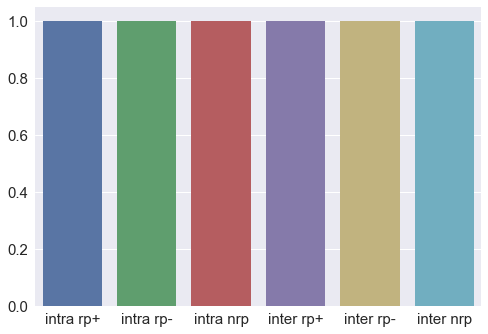

15 g:0.15 c:0.1 w:0.05 mi:-0.15 ma:0.025


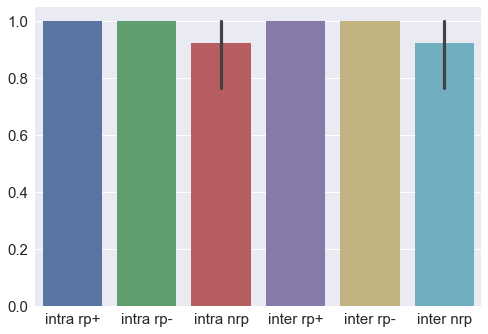

16 g:0.15 c:0.1 w:0.05 mi:-0.15 ma:0.05


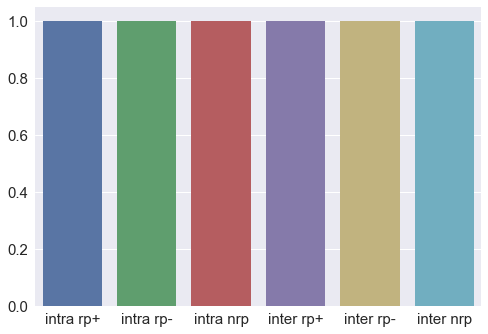

17 g:0.15 c:0.1 w:0.05 mi:-0.15 ma:0.1


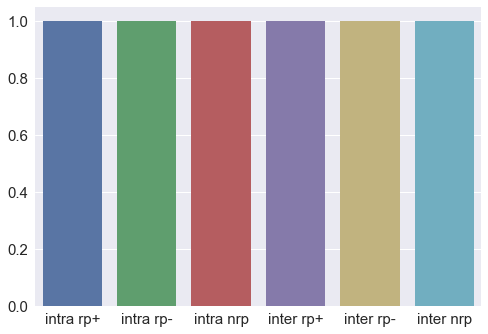

18 g:0.15 c:0.1 w:0.05 mi:-0.15 ma:0.15


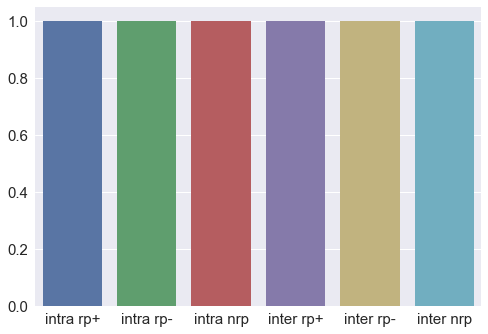

19 g:0.15 c:0.1 w:0.05 mi:-0.15 ma:0.2


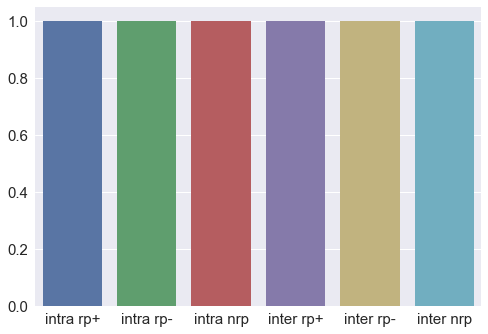

20 g:0.15 c:0.1 w:0.05 mi:-0.2 ma:0.025


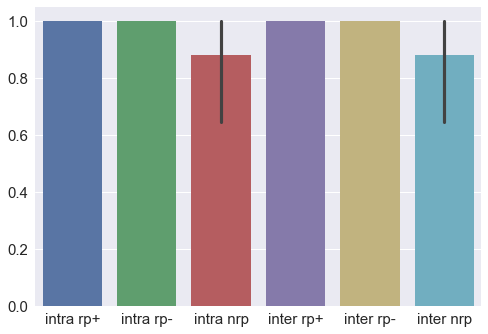

21 g:0.15 c:0.1 w:0.05 mi:-0.2 ma:0.05


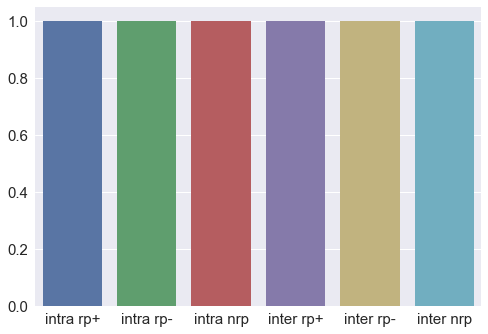

22 g:0.15 c:0.1 w:0.05 mi:-0.2 ma:0.1


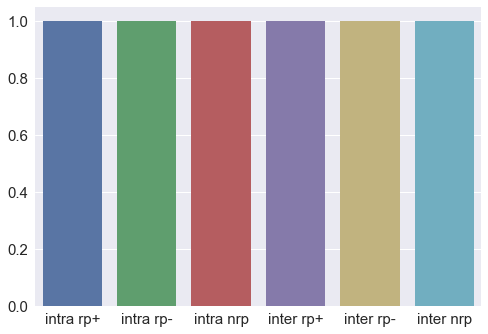

23 g:0.15 c:0.1 w:0.05 mi:-0.2 ma:0.15


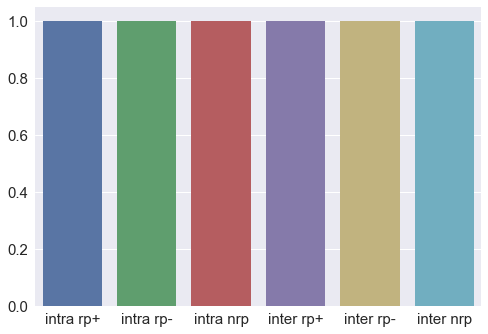

24 g:0.15 c:0.1 w:0.05 mi:-0.2 ma:0.2


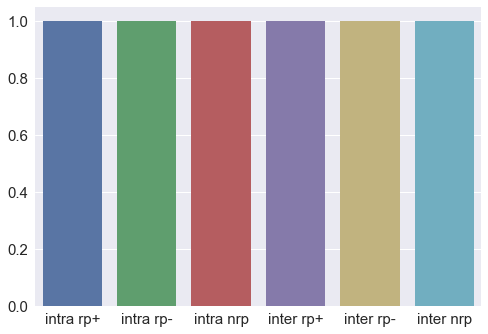

25 g:0.15 c:0.1 w:0.1 mi:-0.025 ma:0.025


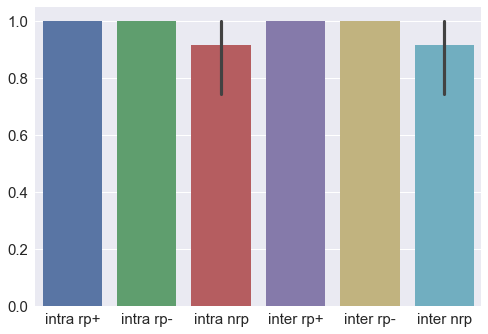

26 g:0.15 c:0.1 w:0.1 mi:-0.025 ma:0.05


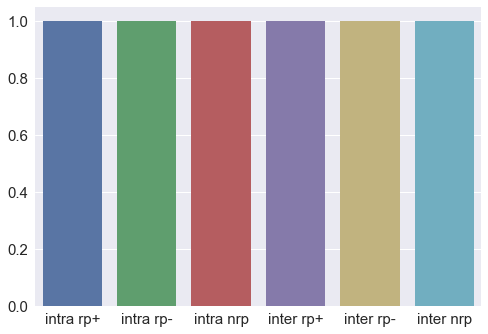

27 g:0.15 c:0.1 w:0.1 mi:-0.025 ma:0.1


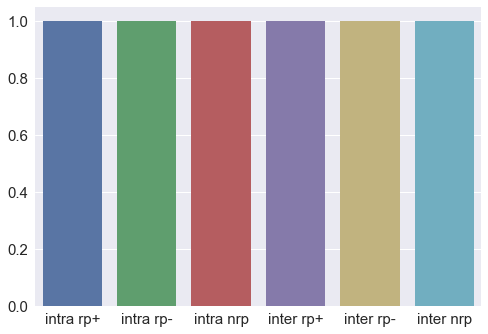

28 g:0.15 c:0.1 w:0.1 mi:-0.025 ma:0.15


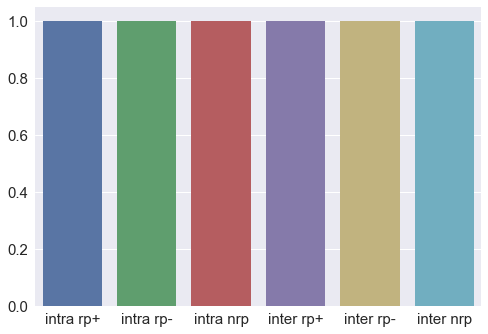

29 g:0.15 c:0.1 w:0.1 mi:-0.025 ma:0.2


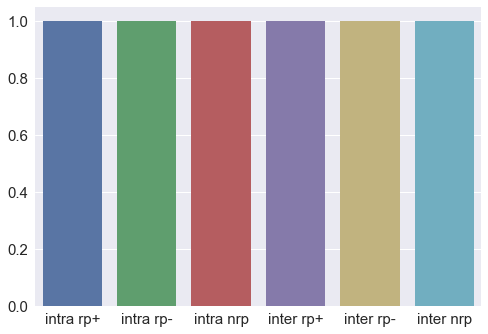

30 g:0.15 c:0.1 w:0.1 mi:-0.05 ma:0.025


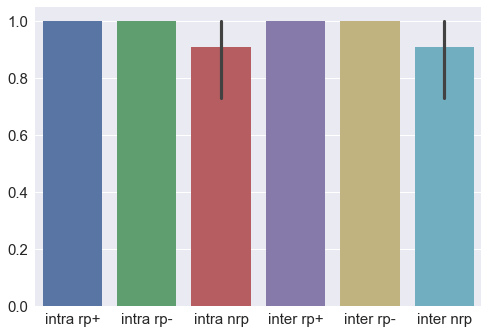

31 g:0.15 c:0.1 w:0.1 mi:-0.05 ma:0.05


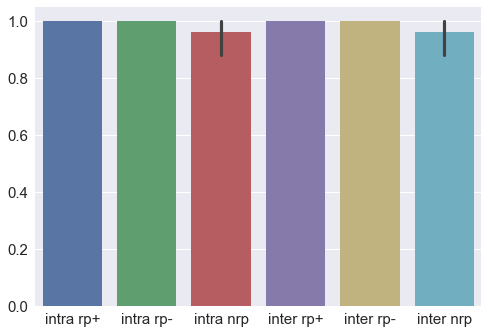

32 g:0.15 c:0.1 w:0.1 mi:-0.05 ma:0.1


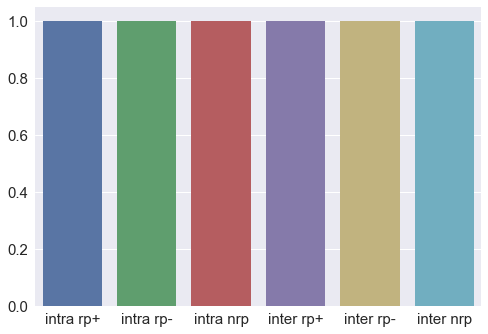

33 g:0.15 c:0.1 w:0.1 mi:-0.05 ma:0.15


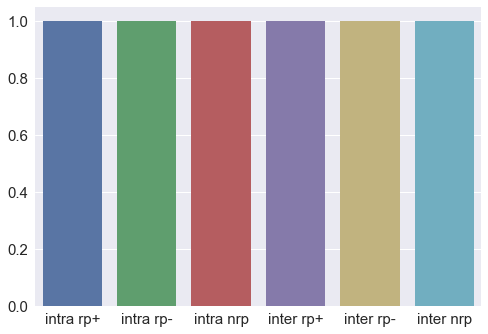

34 g:0.15 c:0.1 w:0.1 mi:-0.05 ma:0.2


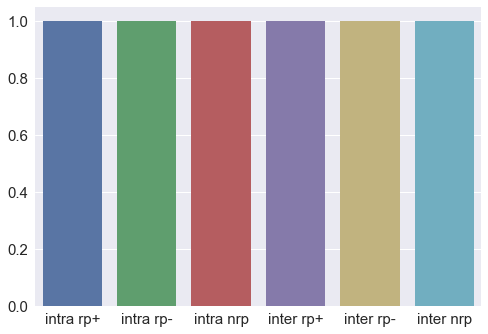

35 g:0.15 c:0.1 w:0.1 mi:-0.1 ma:0.025


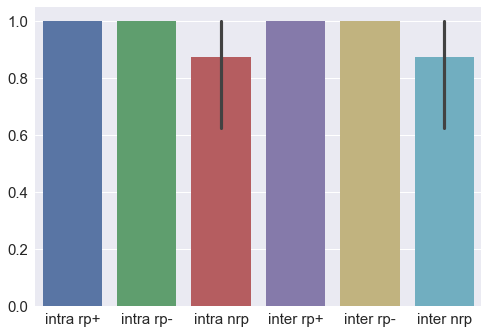

36 g:0.15 c:0.1 w:0.1 mi:-0.1 ma:0.05


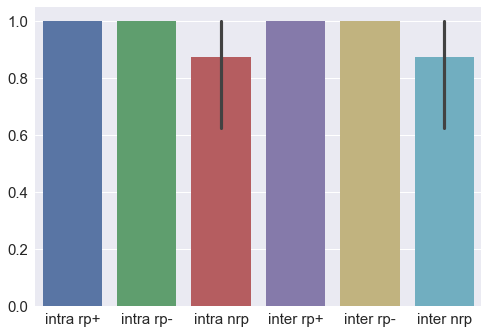

37 g:0.15 c:0.1 w:0.1 mi:-0.1 ma:0.1


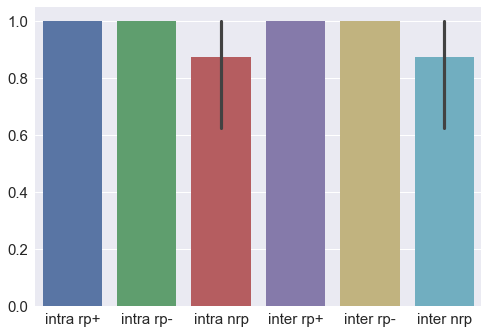

38 g:0.15 c:0.1 w:0.1 mi:-0.1 ma:0.15


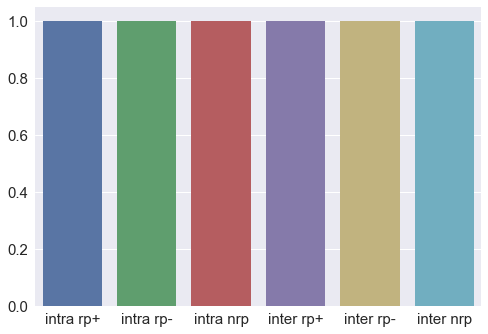

39 g:0.15 c:0.1 w:0.1 mi:-0.1 ma:0.2


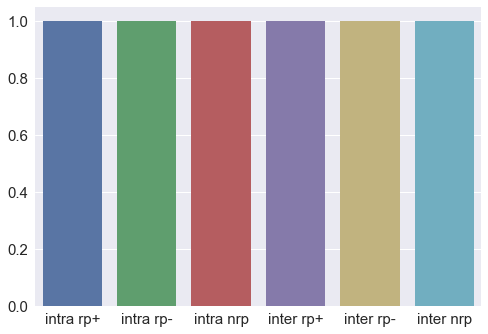

40 g:0.15 c:0.1 w:0.1 mi:-0.15 ma:0.025


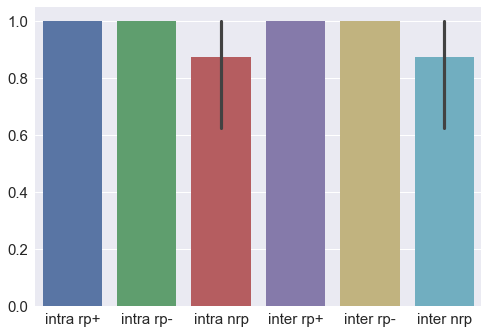

41 g:0.15 c:0.1 w:0.1 mi:-0.15 ma:0.05


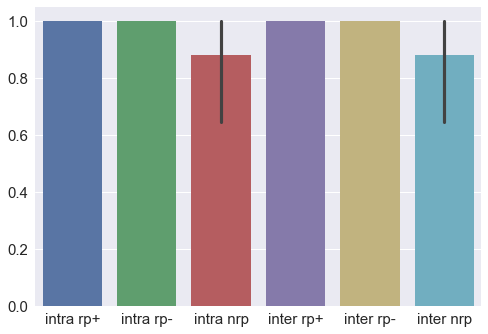

42 g:0.15 c:0.1 w:0.1 mi:-0.15 ma:0.1


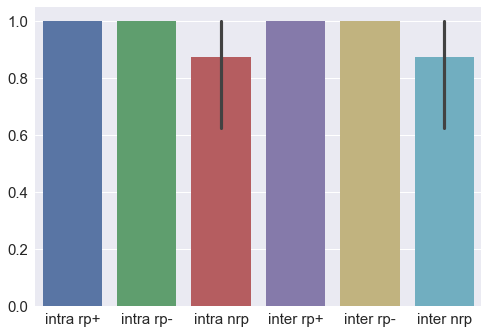

43 g:0.15 c:0.1 w:0.1 mi:-0.15 ma:0.15


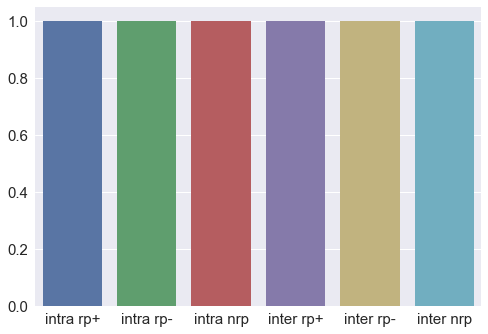

44 g:0.15 c:0.1 w:0.1 mi:-0.15 ma:0.2


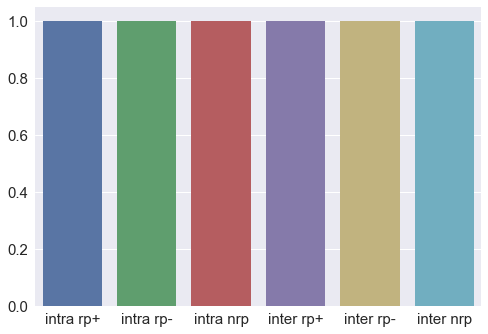

45 g:0.15 c:0.1 w:0.1 mi:-0.2 ma:0.025


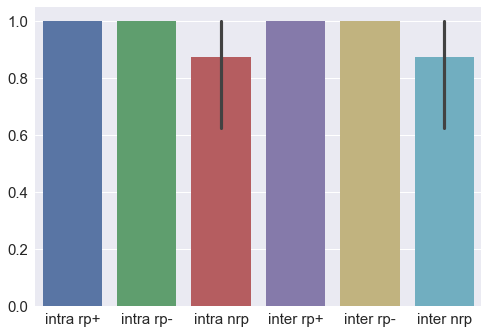

46 g:0.15 c:0.1 w:0.1 mi:-0.2 ma:0.05


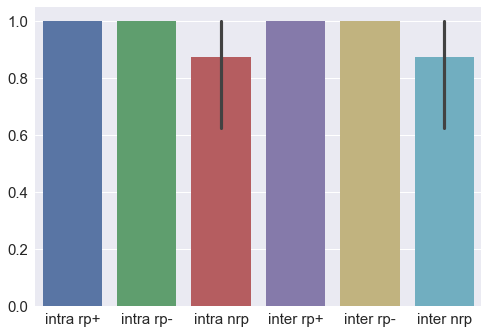

47 g:0.15 c:0.1 w:0.1 mi:-0.2 ma:0.1


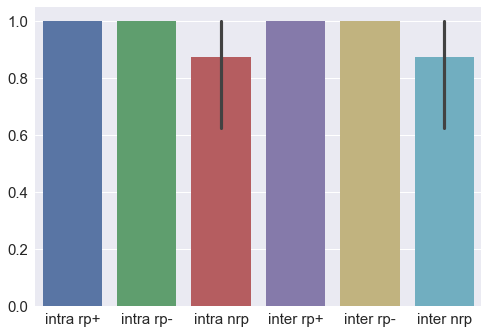

48 g:0.15 c:0.1 w:0.1 mi:-0.2 ma:0.15


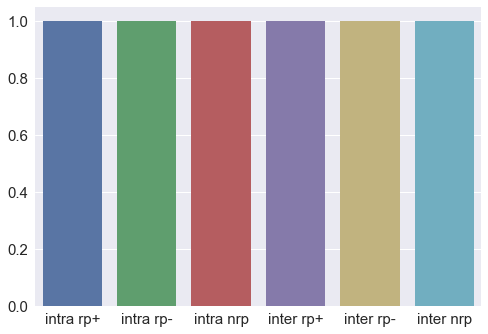

49 g:0.15 c:0.1 w:0.1 mi:-0.2 ma:0.2


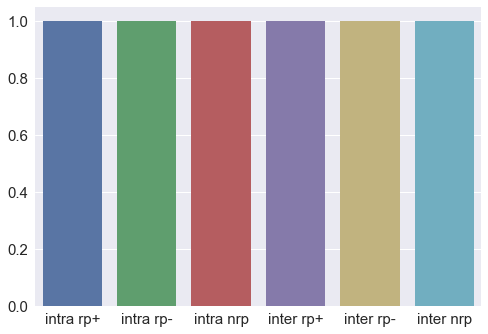

50 g:0.15 c:0.1 w:0.15 mi:-0.025 ma:0.025


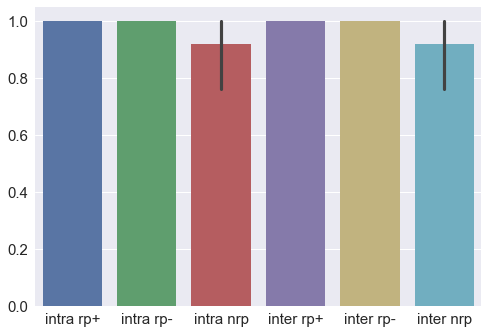

51 g:0.15 c:0.1 w:0.15 mi:-0.025 ma:0.05


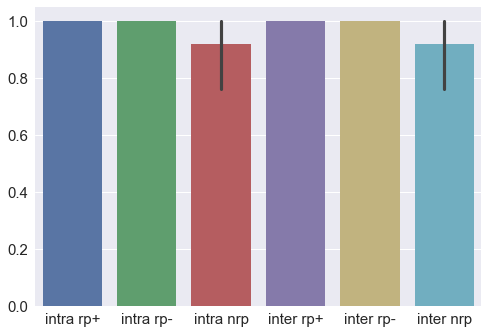

52 g:0.15 c:0.1 w:0.15 mi:-0.025 ma:0.1


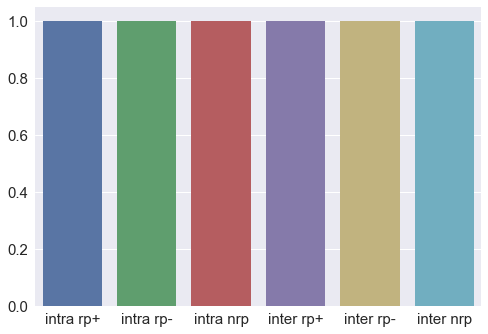

53 g:0.15 c:0.1 w:0.15 mi:-0.025 ma:0.15


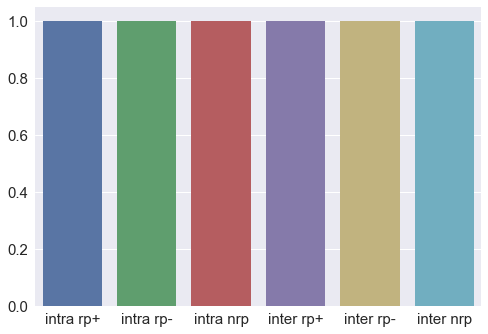

54 g:0.15 c:0.1 w:0.15 mi:-0.025 ma:0.2


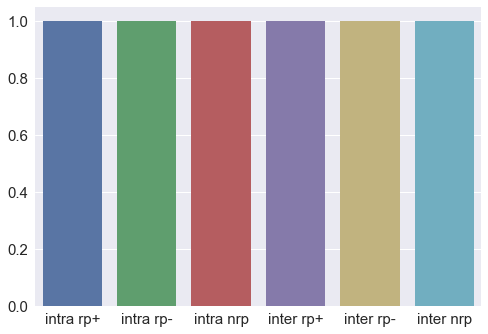

55 g:0.15 c:0.1 w:0.15 mi:-0.05 ma:0.025


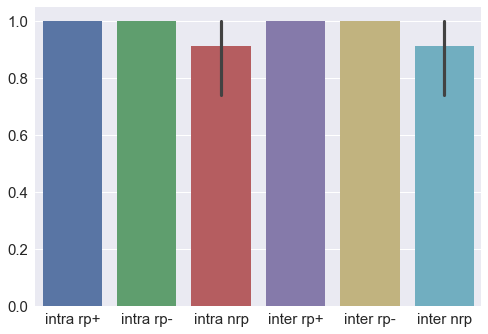

56 g:0.15 c:0.1 w:0.15 mi:-0.05 ma:0.05


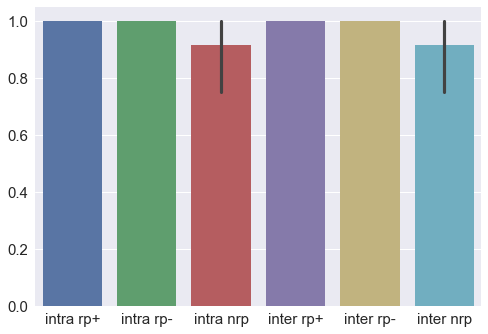

57 g:0.15 c:0.1 w:0.15 mi:-0.05 ma:0.1


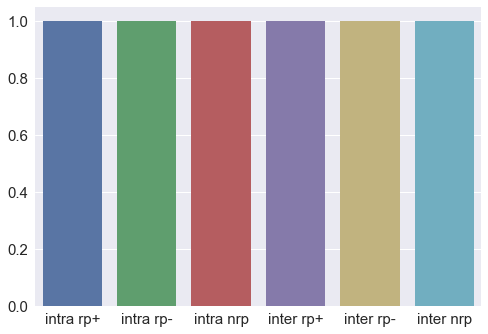

58 g:0.15 c:0.1 w:0.15 mi:-0.05 ma:0.15


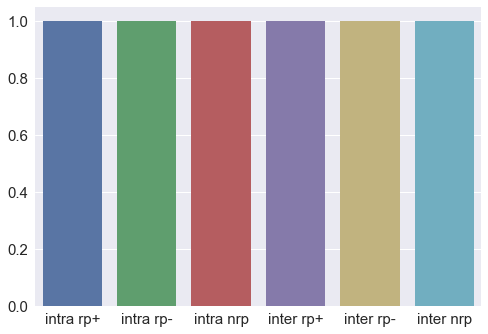

59 g:0.15 c:0.1 w:0.15 mi:-0.05 ma:0.2


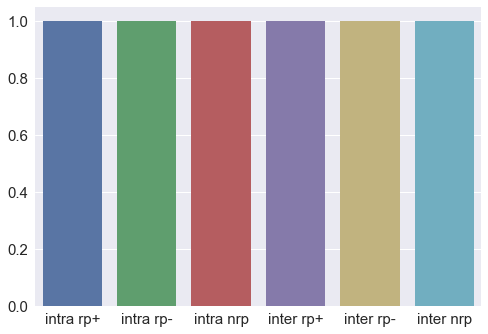

60 g:0.15 c:0.1 w:0.15 mi:-0.1 ma:0.025


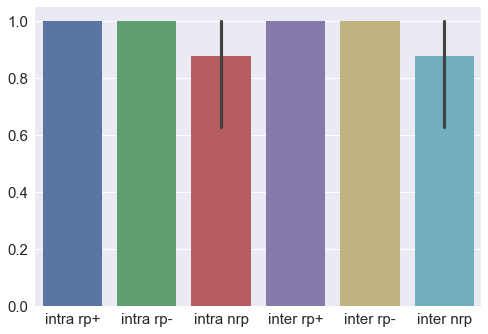

61 g:0.15 c:0.1 w:0.15 mi:-0.1 ma:0.05


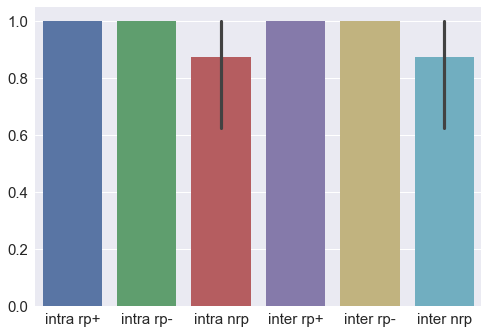

62 g:0.15 c:0.1 w:0.15 mi:-0.1 ma:0.1


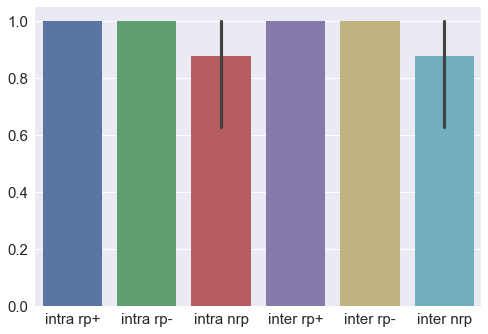

63 g:0.15 c:0.1 w:0.15 mi:-0.1 ma:0.15


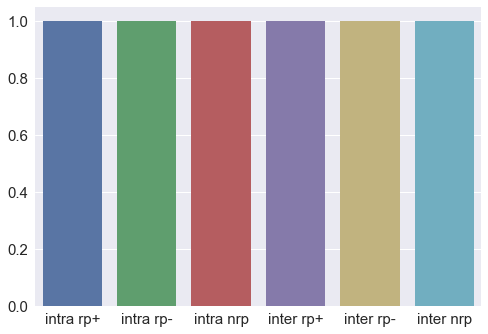

64 g:0.15 c:0.1 w:0.15 mi:-0.1 ma:0.2


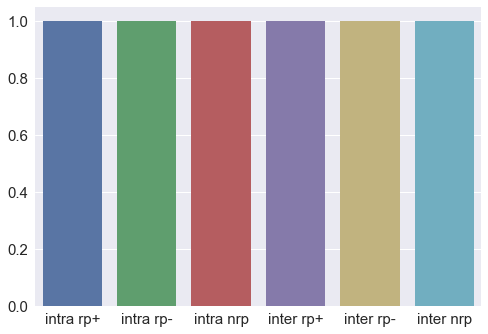

65 g:0.15 c:0.1 w:0.15 mi:-0.15 ma:0.025


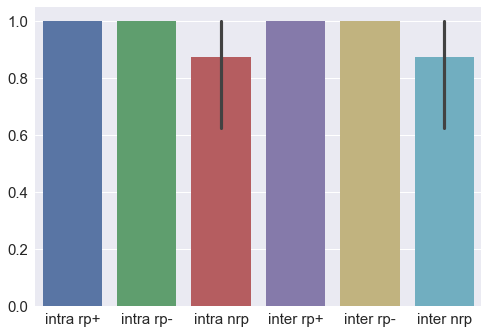

66 g:0.15 c:0.1 w:0.15 mi:-0.15 ma:0.05


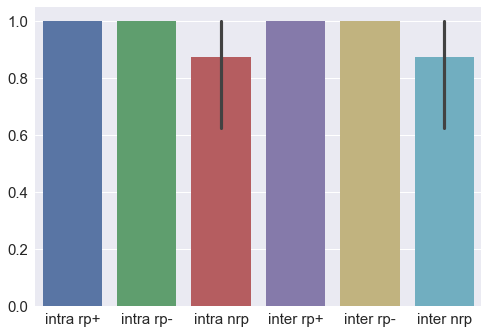

67 g:0.15 c:0.1 w:0.15 mi:-0.15 ma:0.1


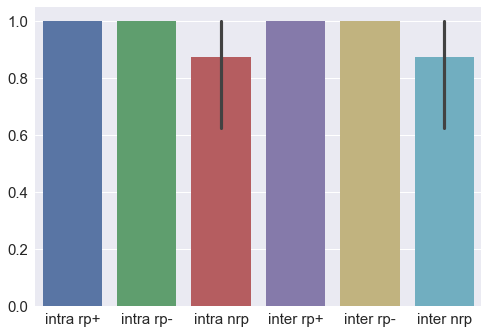

68 g:0.15 c:0.1 w:0.15 mi:-0.15 ma:0.15


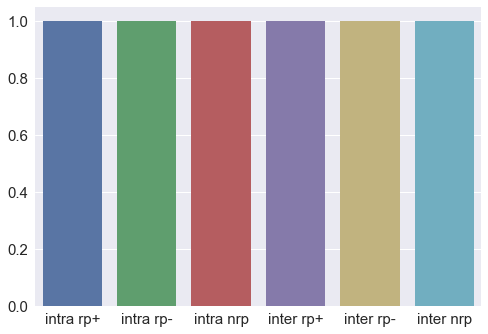

69 g:0.15 c:0.1 w:0.15 mi:-0.15 ma:0.2


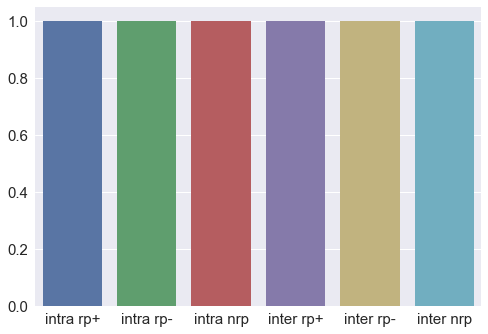

70 g:0.15 c:0.1 w:0.15 mi:-0.2 ma:0.025


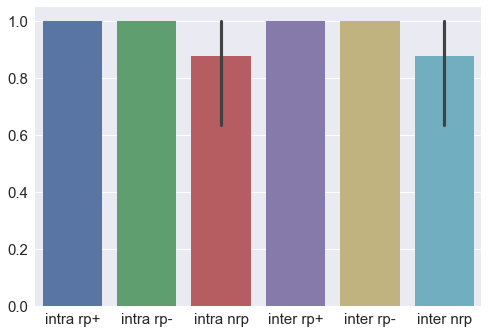

71 g:0.15 c:0.1 w:0.15 mi:-0.2 ma:0.05


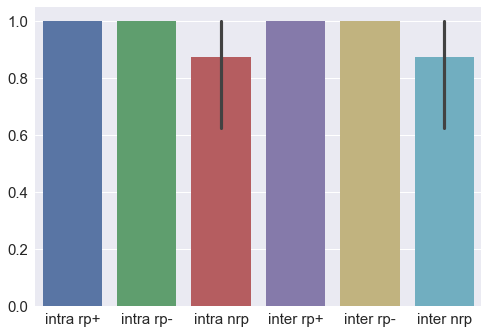

72 g:0.15 c:0.1 w:0.15 mi:-0.2 ma:0.1


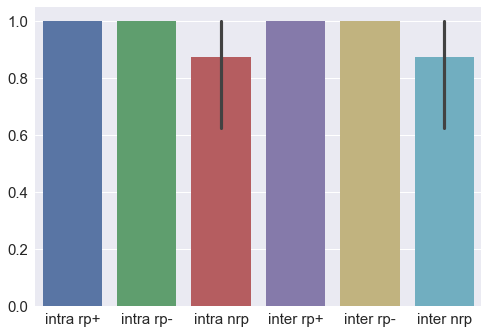

73 g:0.15 c:0.1 w:0.15 mi:-0.2 ma:0.15


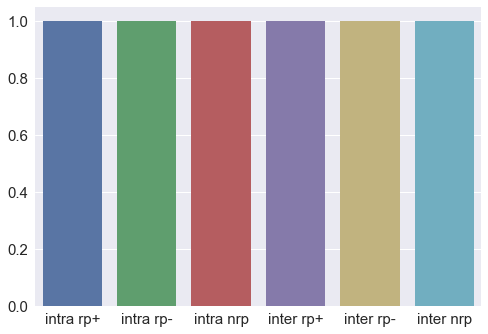

74 g:0.15 c:0.1 w:0.15 mi:-0.2 ma:0.2


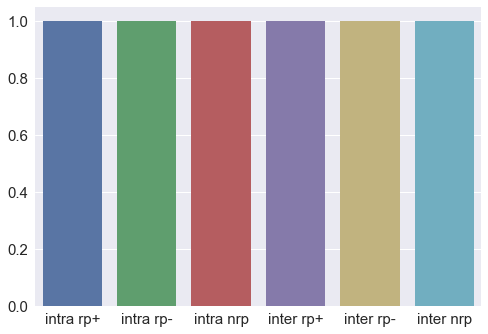

75 g:0.15 c:0.15 w:0.05 mi:-0.025 ma:0.025


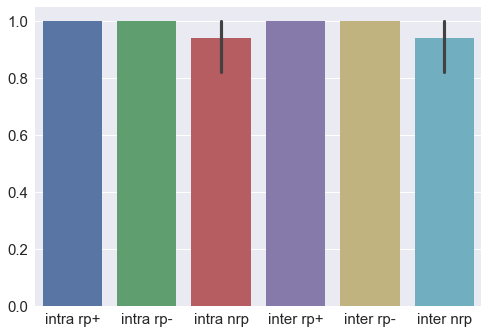

76 g:0.15 c:0.15 w:0.05 mi:-0.025 ma:0.05


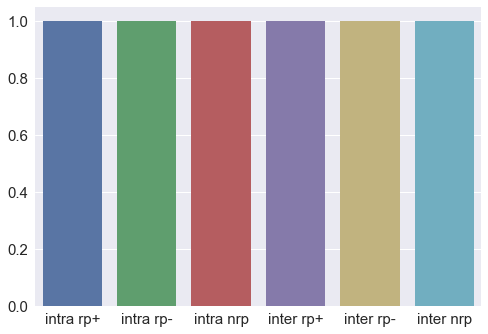

77 g:0.15 c:0.15 w:0.05 mi:-0.025 ma:0.1


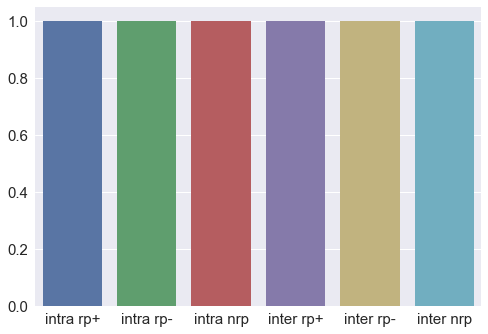

78 g:0.15 c:0.15 w:0.05 mi:-0.025 ma:0.15


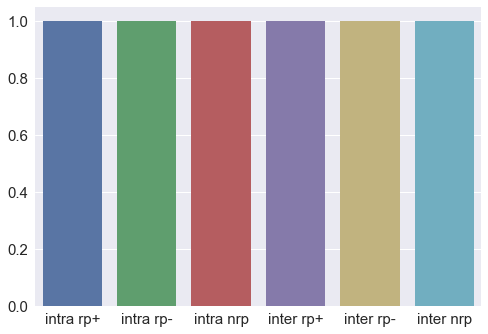

79 g:0.15 c:0.15 w:0.05 mi:-0.025 ma:0.2


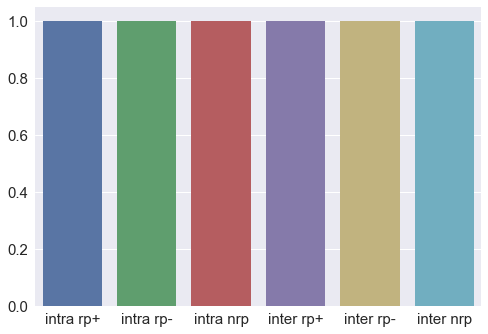

80 g:0.15 c:0.15 w:0.05 mi:-0.05 ma:0.025


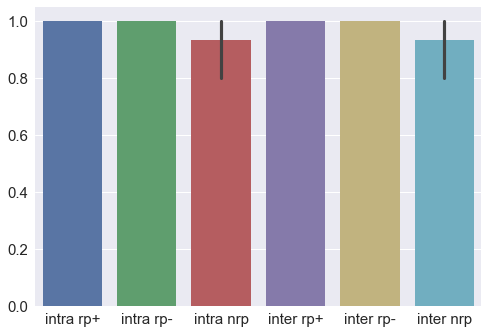

81 g:0.15 c:0.15 w:0.05 mi:-0.05 ma:0.05


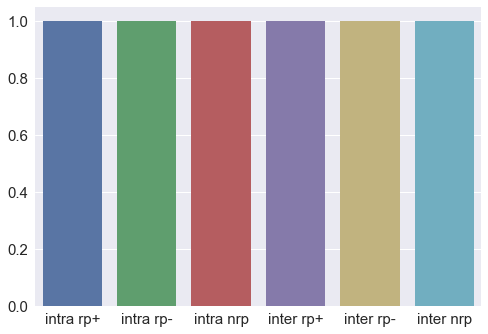

82 g:0.15 c:0.15 w:0.05 mi:-0.05 ma:0.1


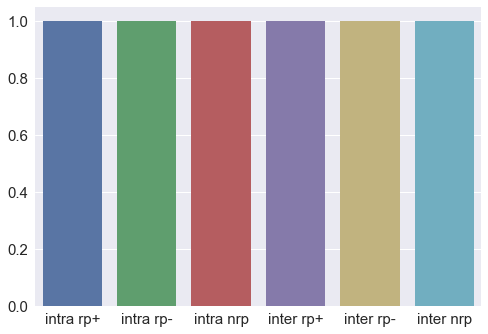

83 g:0.15 c:0.15 w:0.05 mi:-0.05 ma:0.15


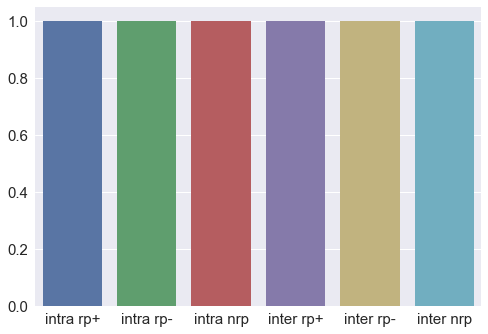

84 g:0.15 c:0.15 w:0.05 mi:-0.05 ma:0.2


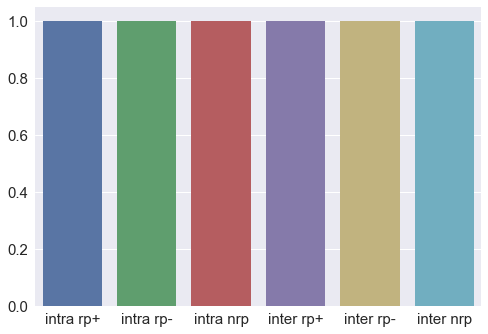

85 g:0.15 c:0.15 w:0.05 mi:-0.1 ma:0.025


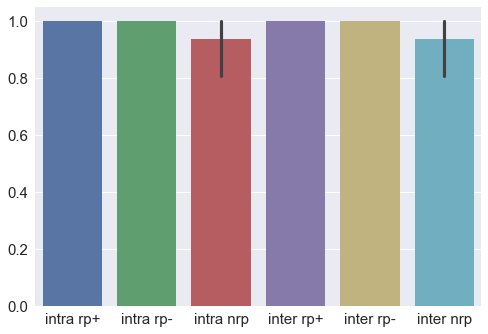

86 g:0.15 c:0.15 w:0.05 mi:-0.1 ma:0.05


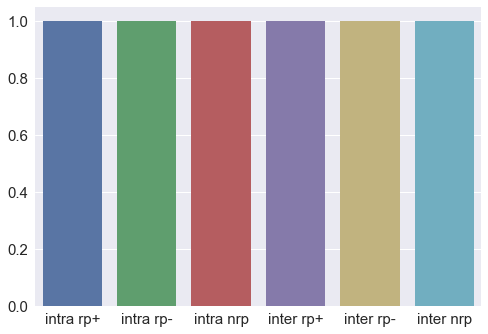

87 g:0.15 c:0.15 w:0.05 mi:-0.1 ma:0.1


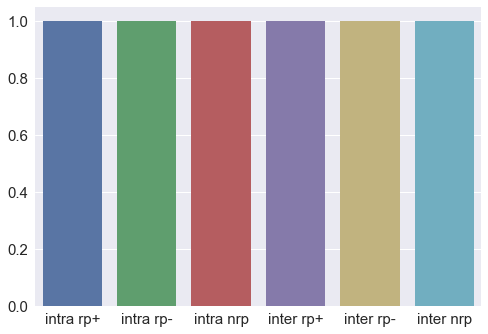

88 g:0.15 c:0.15 w:0.05 mi:-0.1 ma:0.15


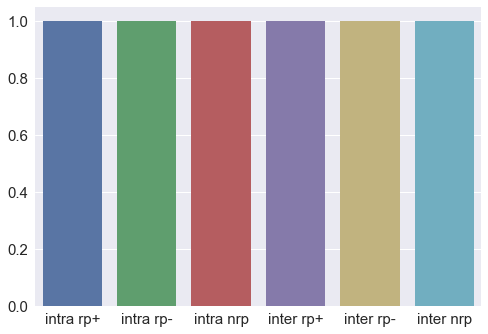

89 g:0.15 c:0.15 w:0.05 mi:-0.1 ma:0.2


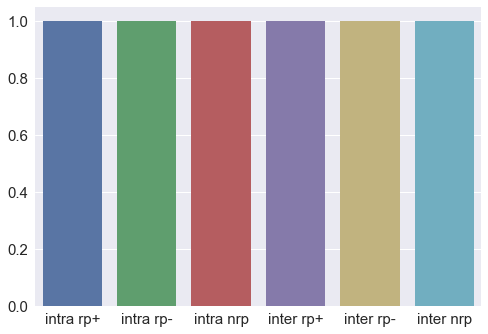

90 g:0.15 c:0.15 w:0.05 mi:-0.15 ma:0.025


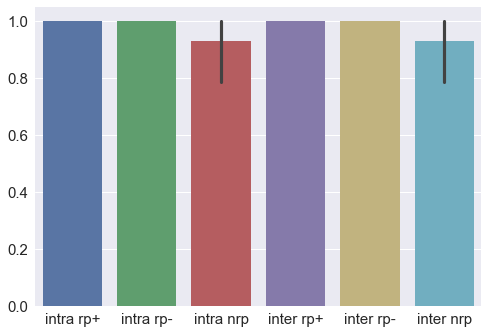

91 g:0.15 c:0.15 w:0.05 mi:-0.15 ma:0.05


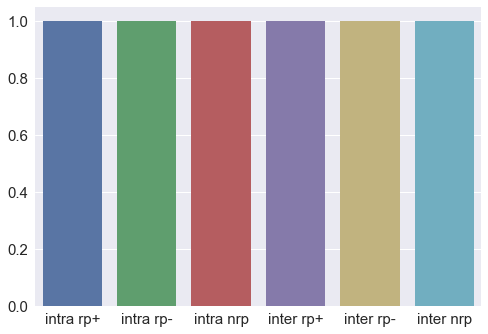

92 g:0.15 c:0.15 w:0.05 mi:-0.15 ma:0.1


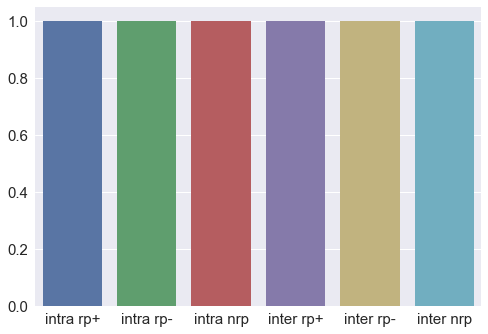

93 g:0.15 c:0.15 w:0.05 mi:-0.15 ma:0.15


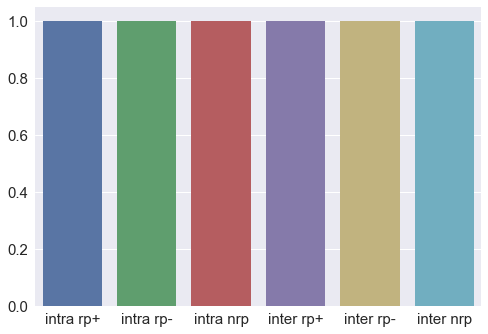

94 g:0.15 c:0.15 w:0.05 mi:-0.15 ma:0.2


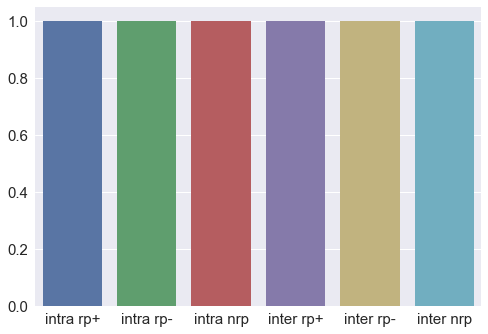

95 g:0.15 c:0.15 w:0.05 mi:-0.2 ma:0.025


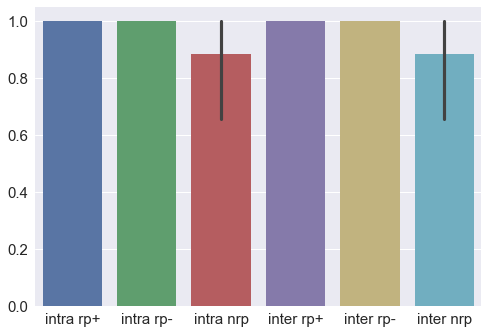

96 g:0.15 c:0.15 w:0.05 mi:-0.2 ma:0.05


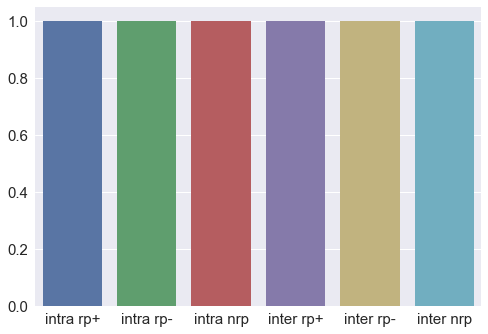

97 g:0.15 c:0.15 w:0.05 mi:-0.2 ma:0.1


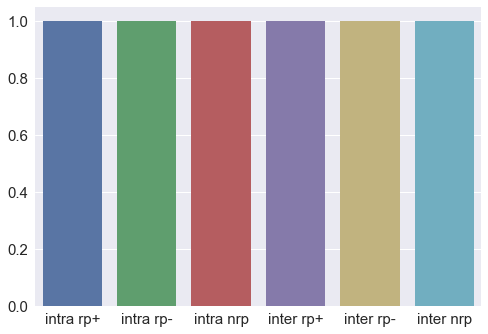

98 g:0.15 c:0.15 w:0.05 mi:-0.2 ma:0.15


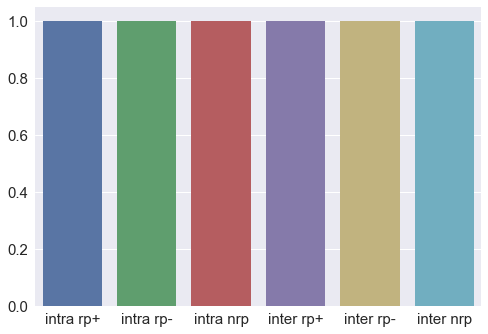

99 g:0.15 c:0.15 w:0.05 mi:-0.2 ma:0.2


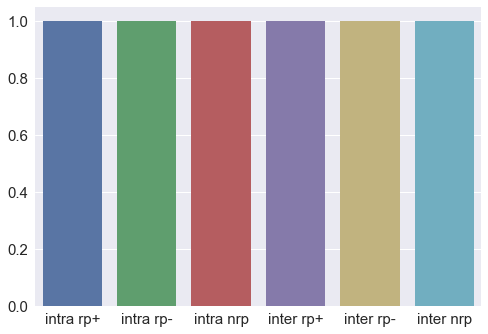

100 g:0.15 c:0.15 w:0.1 mi:-0.025 ma:0.025


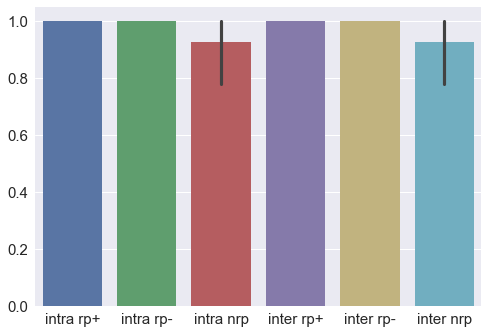

101 g:0.15 c:0.15 w:0.1 mi:-0.025 ma:0.05


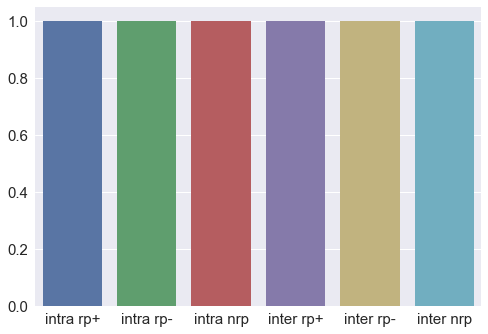

102 g:0.15 c:0.15 w:0.1 mi:-0.025 ma:0.1


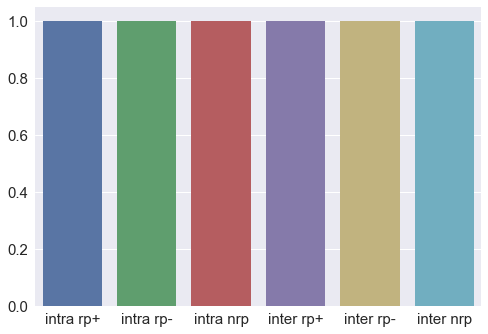

103 g:0.15 c:0.15 w:0.1 mi:-0.025 ma:0.15


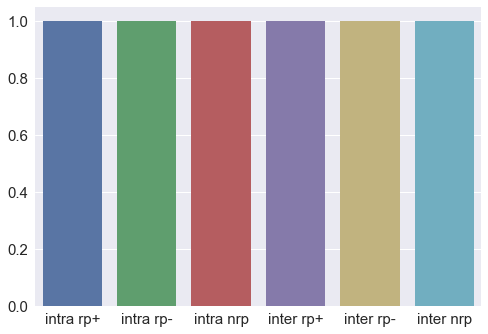

104 g:0.15 c:0.15 w:0.1 mi:-0.025 ma:0.2


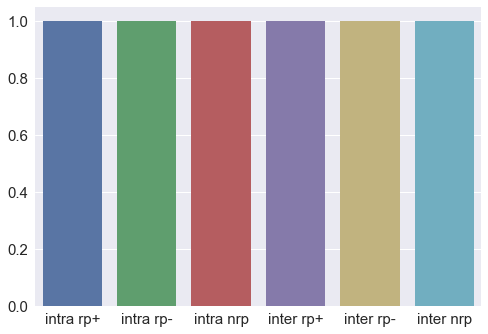

105 g:0.15 c:0.15 w:0.1 mi:-0.05 ma:0.025


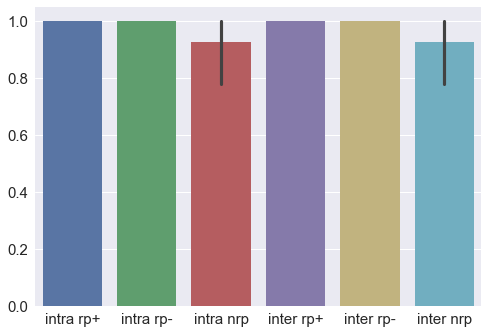

106 g:0.15 c:0.15 w:0.1 mi:-0.05 ma:0.05


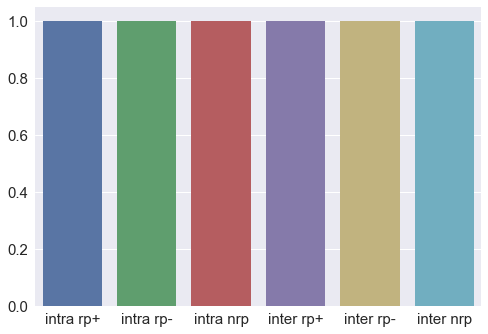

107 g:0.15 c:0.15 w:0.1 mi:-0.05 ma:0.1


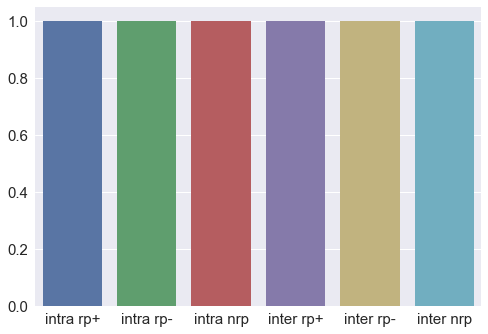

108 g:0.15 c:0.15 w:0.1 mi:-0.05 ma:0.15


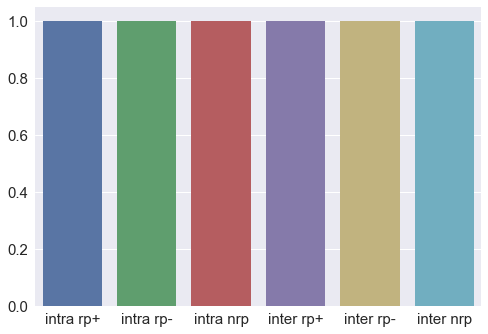

109 g:0.15 c:0.15 w:0.1 mi:-0.05 ma:0.2


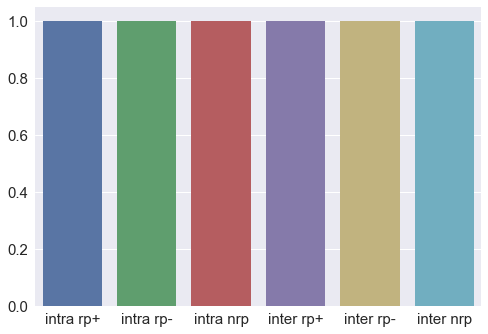

110 g:0.15 c:0.15 w:0.1 mi:-0.1 ma:0.025


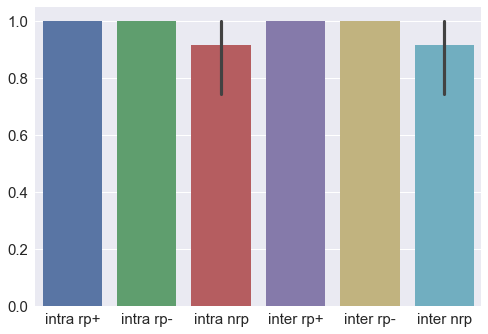

111 g:0.15 c:0.15 w:0.1 mi:-0.1 ma:0.05


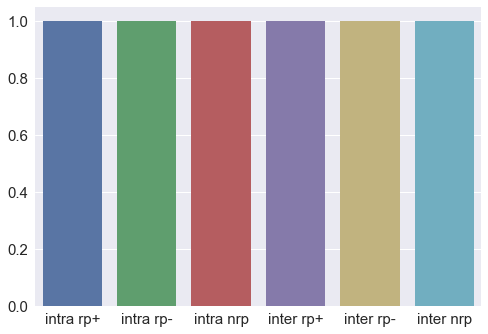

112 g:0.15 c:0.15 w:0.1 mi:-0.1 ma:0.1


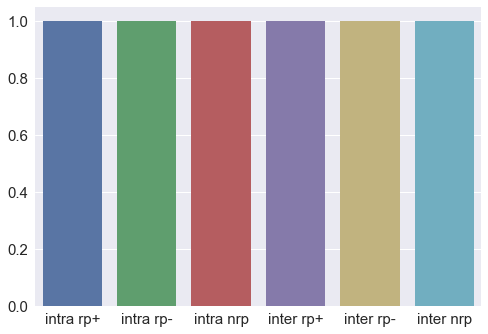

113 g:0.15 c:0.15 w:0.1 mi:-0.1 ma:0.15


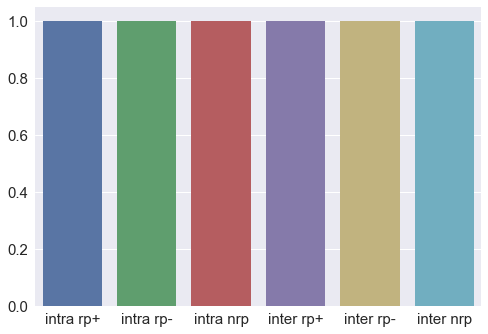

114 g:0.15 c:0.15 w:0.1 mi:-0.1 ma:0.2


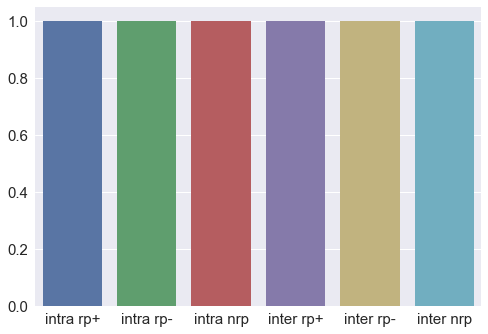

115 g:0.15 c:0.15 w:0.1 mi:-0.15 ma:0.025


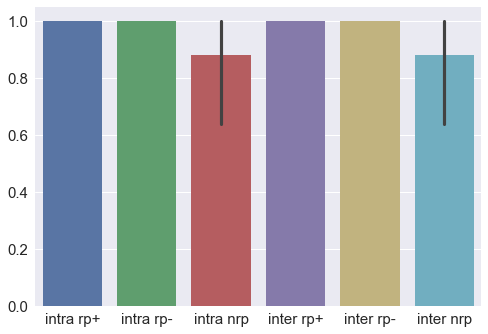

116 g:0.15 c:0.15 w:0.1 mi:-0.15 ma:0.05


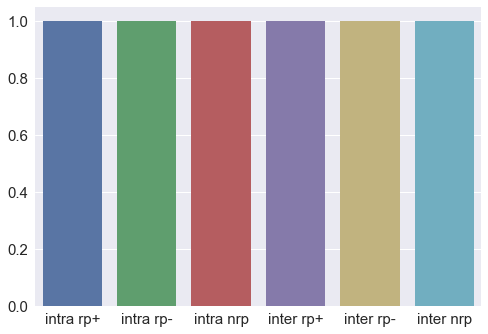

117 g:0.15 c:0.15 w:0.1 mi:-0.15 ma:0.1


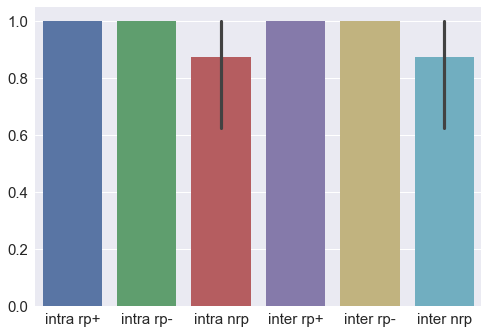

118 g:0.15 c:0.15 w:0.1 mi:-0.15 ma:0.15


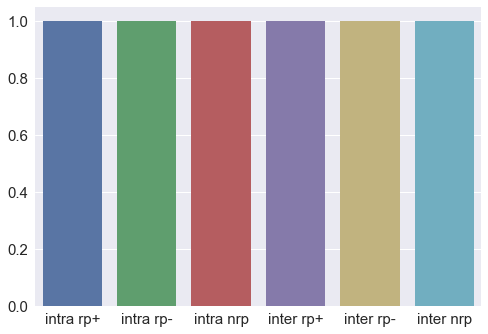

119 g:0.15 c:0.15 w:0.1 mi:-0.15 ma:0.2


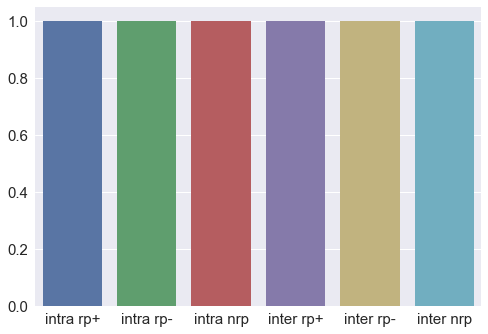

120 g:0.15 c:0.15 w:0.1 mi:-0.2 ma:0.025


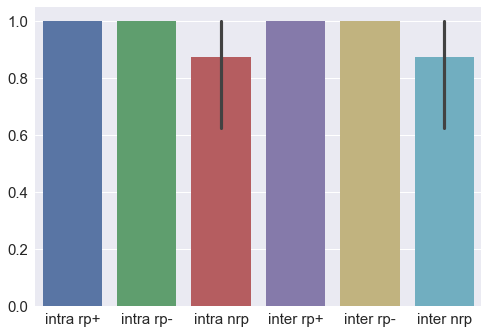

121 g:0.15 c:0.15 w:0.1 mi:-0.2 ma:0.05


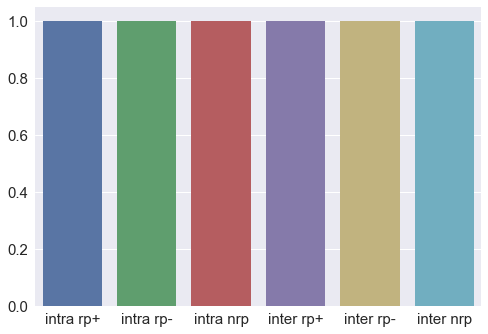

122 g:0.15 c:0.15 w:0.1 mi:-0.2 ma:0.1


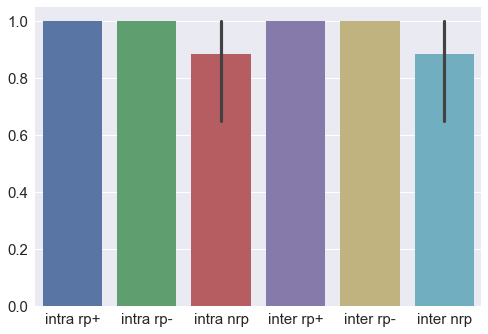

123 g:0.15 c:0.15 w:0.1 mi:-0.2 ma:0.15


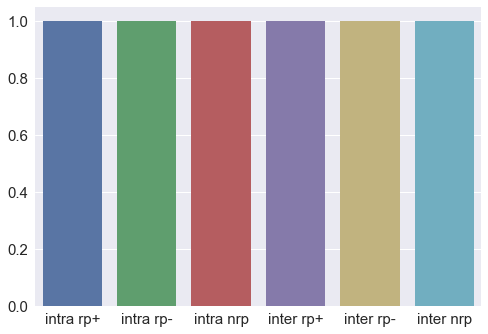

124 g:0.15 c:0.15 w:0.1 mi:-0.2 ma:0.2


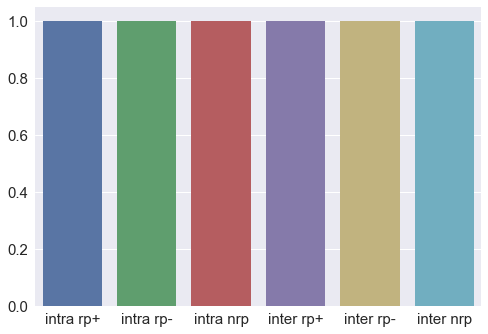

125 g:0.15 c:0.15 w:0.15 mi:-0.025 ma:0.025


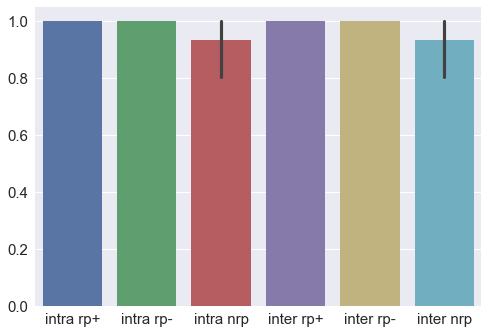

126 g:0.15 c:0.15 w:0.15 mi:-0.025 ma:0.05


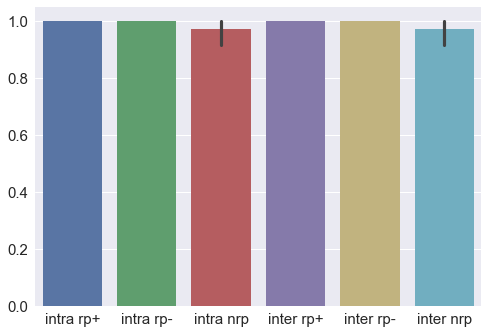

127 g:0.15 c:0.15 w:0.15 mi:-0.025 ma:0.1


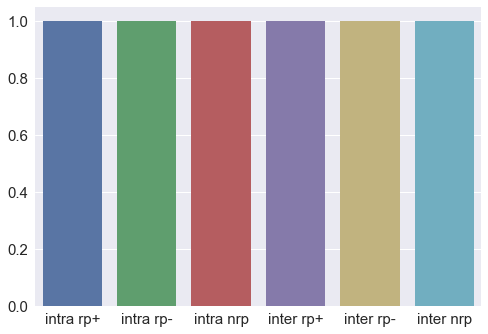

128 g:0.15 c:0.15 w:0.15 mi:-0.025 ma:0.15


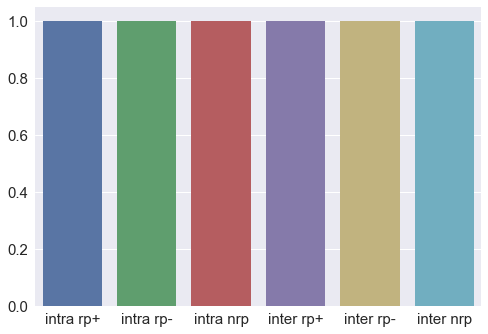

129 g:0.15 c:0.15 w:0.15 mi:-0.025 ma:0.2


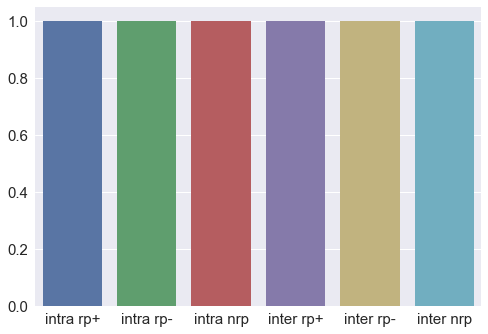

130 g:0.15 c:0.15 w:0.15 mi:-0.05 ma:0.025


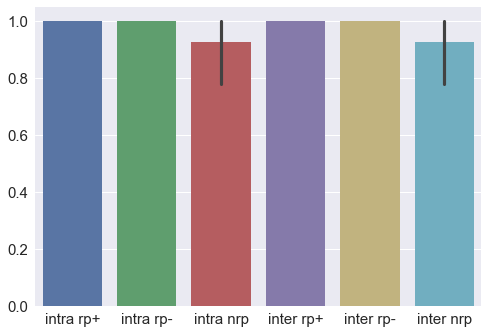

131 g:0.15 c:0.15 w:0.15 mi:-0.05 ma:0.05


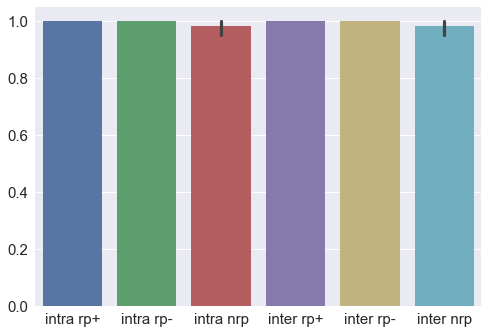

132 g:0.15 c:0.15 w:0.15 mi:-0.05 ma:0.1


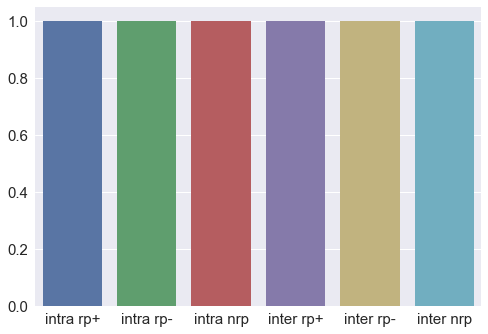

133 g:0.15 c:0.15 w:0.15 mi:-0.05 ma:0.15


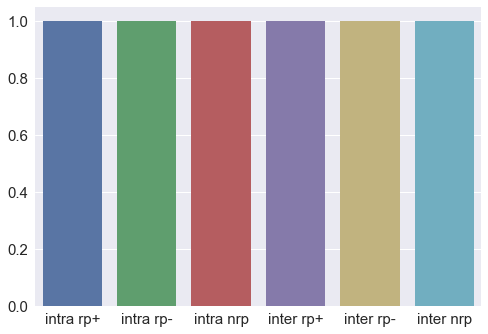

134 g:0.15 c:0.15 w:0.15 mi:-0.05 ma:0.2


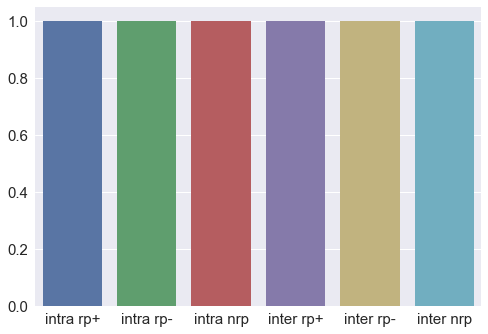

135 g:0.15 c:0.15 w:0.15 mi:-0.1 ma:0.025


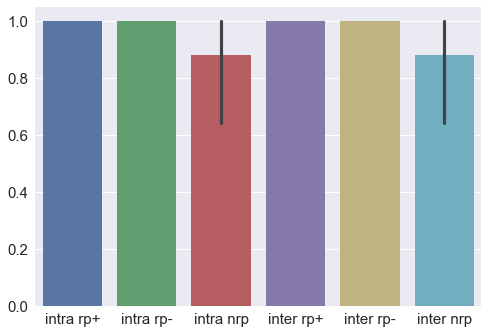

136 g:0.15 c:0.15 w:0.15 mi:-0.1 ma:0.05


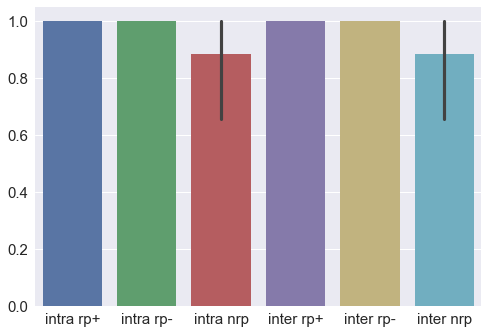

137 g:0.15 c:0.15 w:0.15 mi:-0.1 ma:0.1


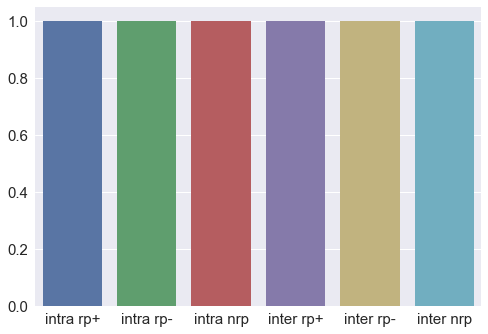

138 g:0.15 c:0.15 w:0.15 mi:-0.1 ma:0.15


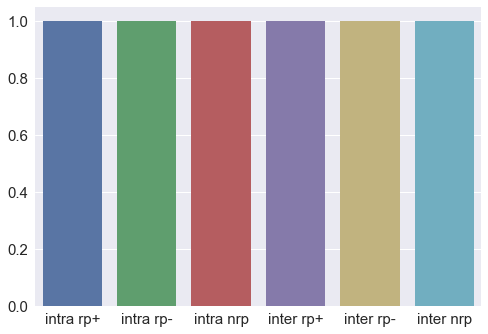

139 g:0.15 c:0.15 w:0.15 mi:-0.1 ma:0.2


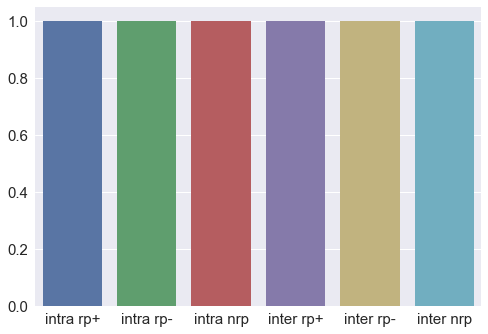

140 g:0.15 c:0.15 w:0.15 mi:-0.15 ma:0.025


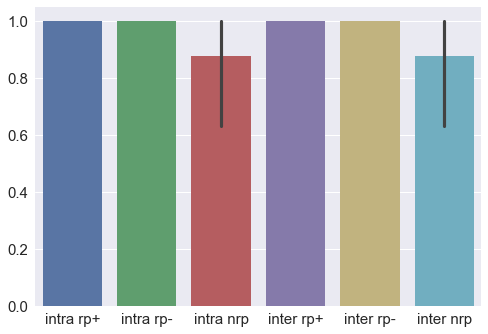

141 g:0.15 c:0.15 w:0.15 mi:-0.15 ma:0.05


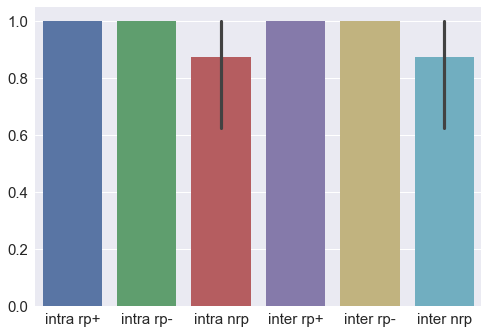

142 g:0.15 c:0.15 w:0.15 mi:-0.15 ma:0.1


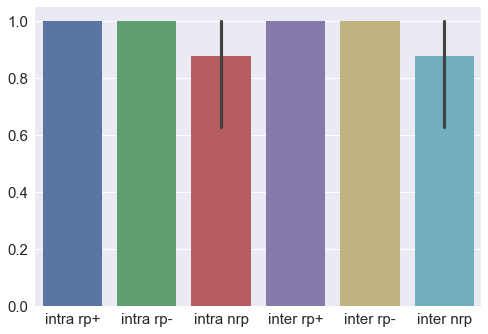

143 g:0.15 c:0.15 w:0.15 mi:-0.15 ma:0.15


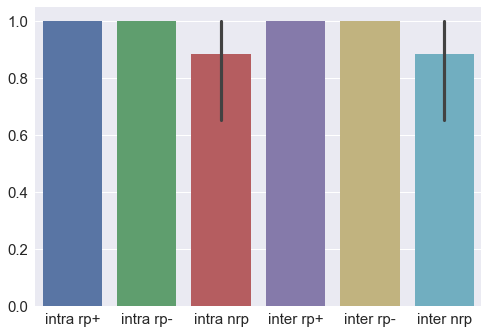

144 g:0.15 c:0.15 w:0.15 mi:-0.15 ma:0.2


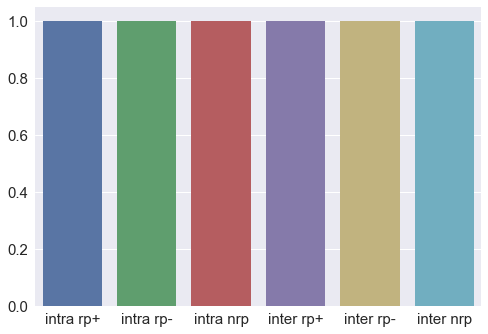

145 g:0.15 c:0.15 w:0.15 mi:-0.2 ma:0.025


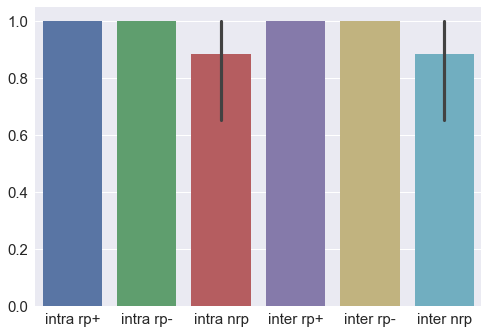

146 g:0.15 c:0.15 w:0.15 mi:-0.2 ma:0.05


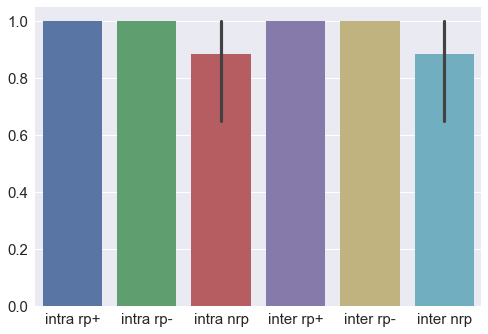

147 g:0.15 c:0.15 w:0.15 mi:-0.2 ma:0.1


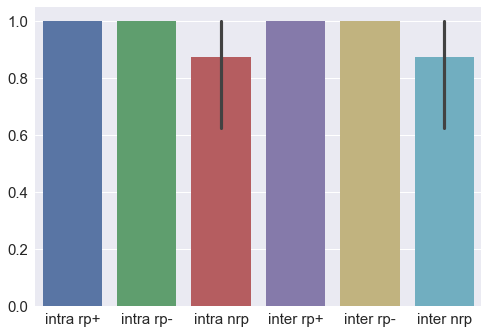

148 g:0.15 c:0.15 w:0.15 mi:-0.2 ma:0.15


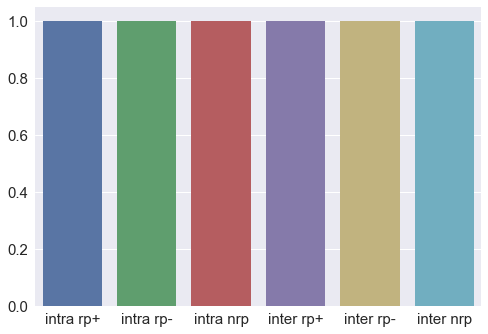

149 g:0.15 c:0.15 w:0.15 mi:-0.2 ma:0.2


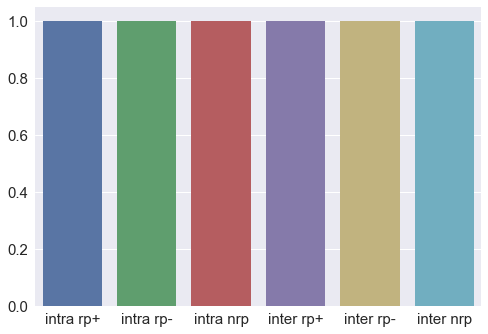

150 g:0.15 c:0.15 w:0.2 mi:-0.025 ma:0.025


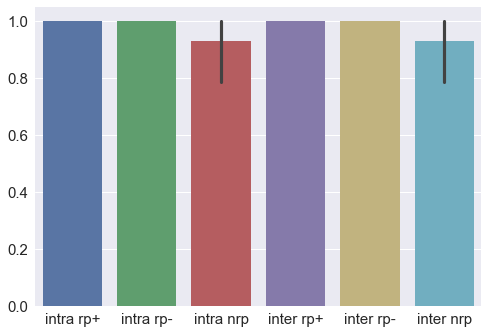

151 g:0.15 c:0.15 w:0.2 mi:-0.025 ma:0.05


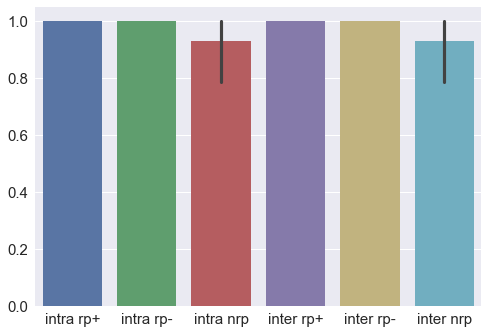

152 g:0.15 c:0.15 w:0.2 mi:-0.025 ma:0.1


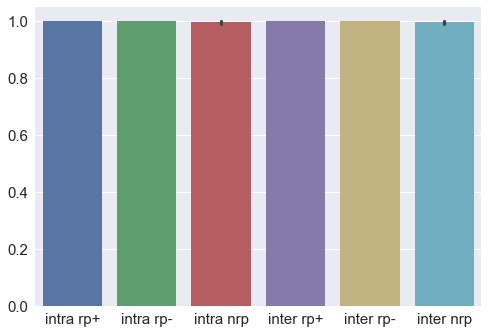

153 g:0.15 c:0.15 w:0.2 mi:-0.025 ma:0.15


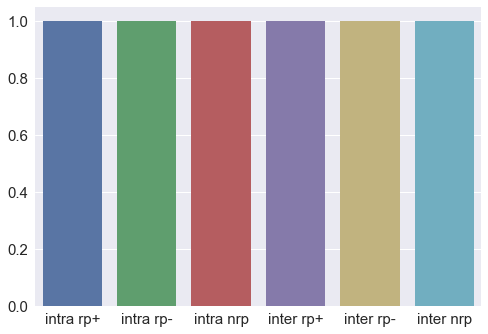

154 g:0.15 c:0.15 w:0.2 mi:-0.025 ma:0.2


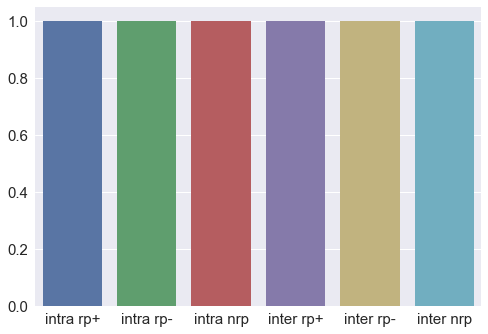

155 g:0.15 c:0.15 w:0.2 mi:-0.05 ma:0.025


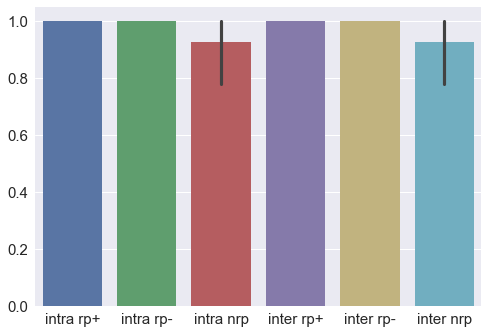

156 g:0.15 c:0.15 w:0.2 mi:-0.05 ma:0.05


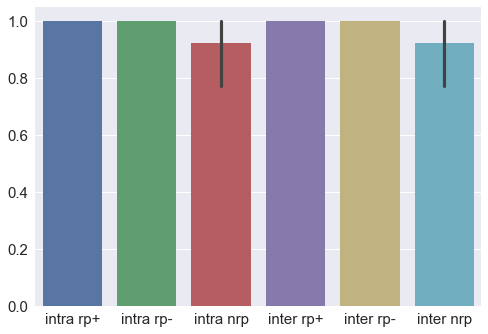

157 g:0.15 c:0.15 w:0.2 mi:-0.05 ma:0.1


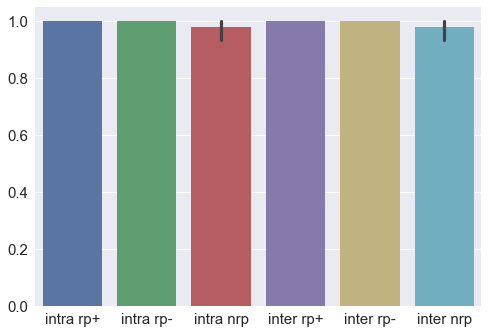

158 g:0.15 c:0.15 w:0.2 mi:-0.05 ma:0.15


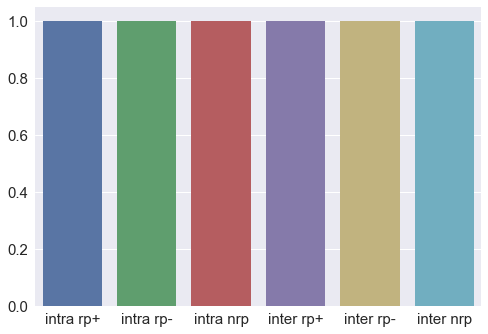

159 g:0.15 c:0.15 w:0.2 mi:-0.05 ma:0.2


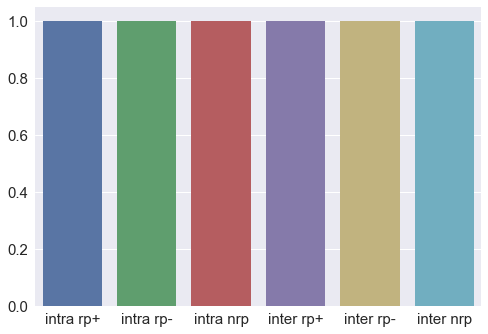

160 g:0.15 c:0.15 w:0.2 mi:-0.1 ma:0.025


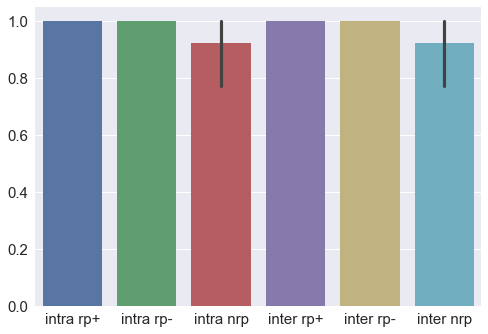

161 g:0.15 c:0.15 w:0.2 mi:-0.1 ma:0.05


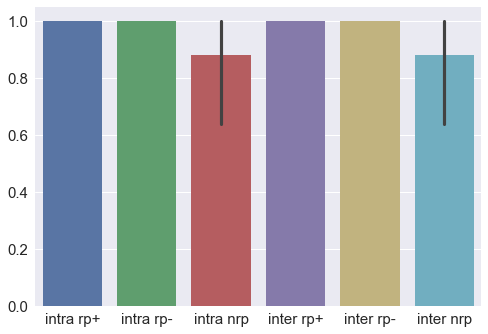

162 g:0.15 c:0.15 w:0.2 mi:-0.1 ma:0.1


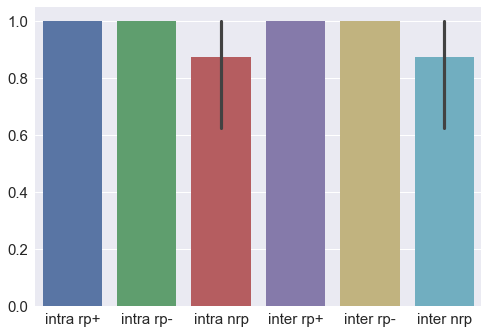

163 g:0.15 c:0.15 w:0.2 mi:-0.1 ma:0.15


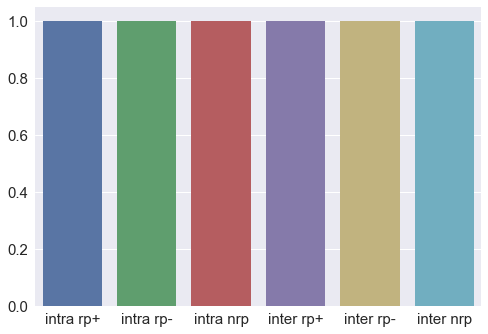

164 g:0.15 c:0.15 w:0.2 mi:-0.1 ma:0.2


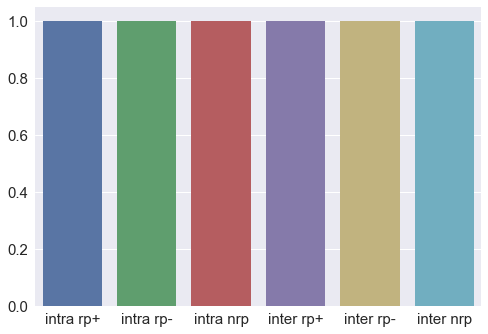

165 g:0.15 c:0.15 w:0.2 mi:-0.15 ma:0.025


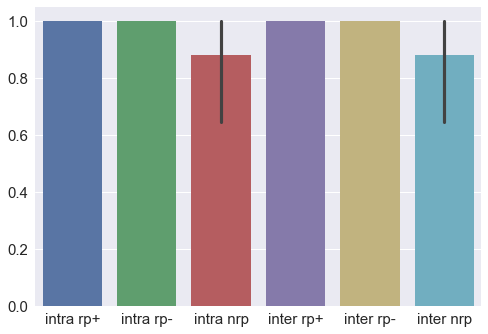

166 g:0.15 c:0.15 w:0.2 mi:-0.15 ma:0.05


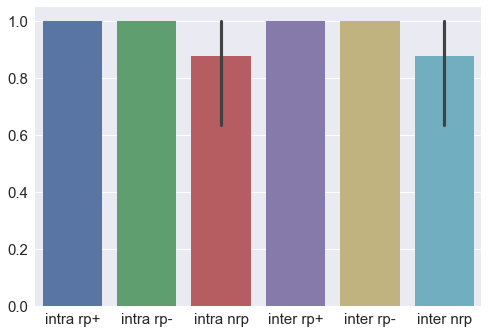

167 g:0.15 c:0.15 w:0.2 mi:-0.15 ma:0.1


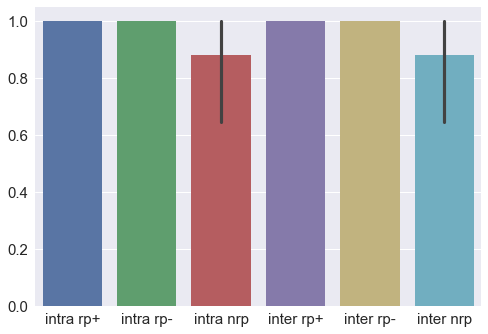

168 g:0.15 c:0.15 w:0.2 mi:-0.15 ma:0.15


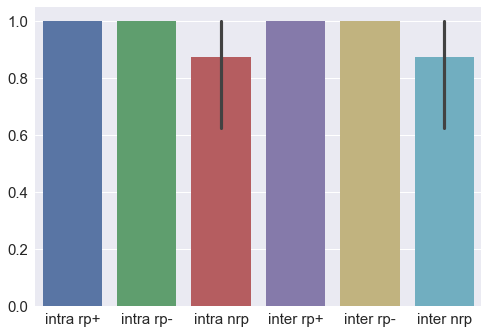

169 g:0.15 c:0.15 w:0.2 mi:-0.15 ma:0.2


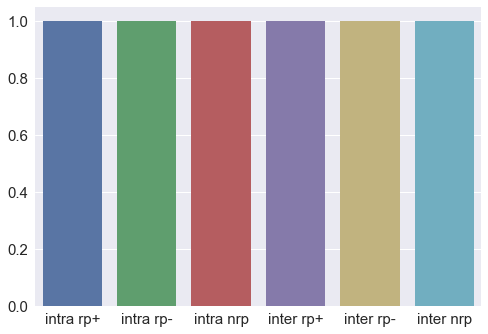

170 g:0.15 c:0.15 w:0.2 mi:-0.2 ma:0.025


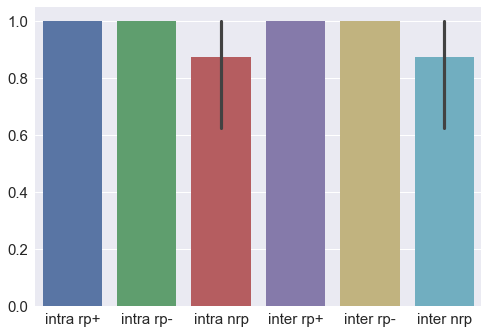

171 g:0.15 c:0.15 w:0.2 mi:-0.2 ma:0.05


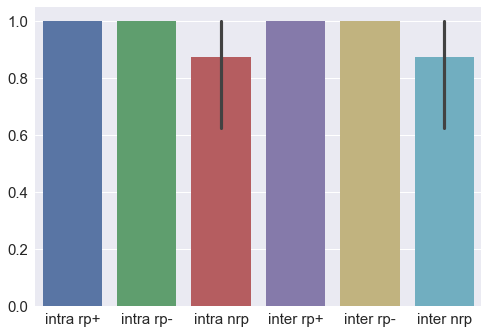

172 g:0.15 c:0.15 w:0.2 mi:-0.2 ma:0.1


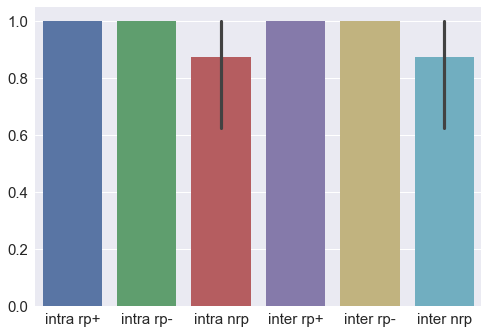

173 g:0.15 c:0.15 w:0.2 mi:-0.2 ma:0.15


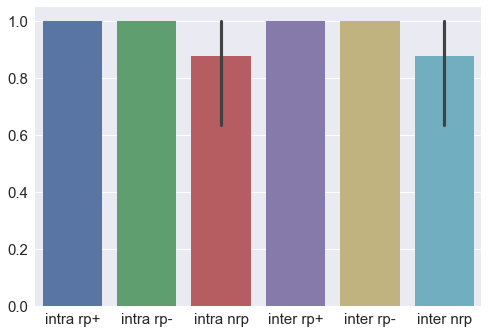

174 g:0.15 c:0.15 w:0.2 mi:-0.2 ma:0.2


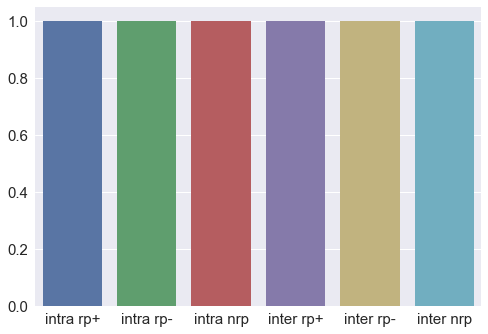

175 g:0.15 c:0.2 w:0.05 mi:-0.025 ma:0.025


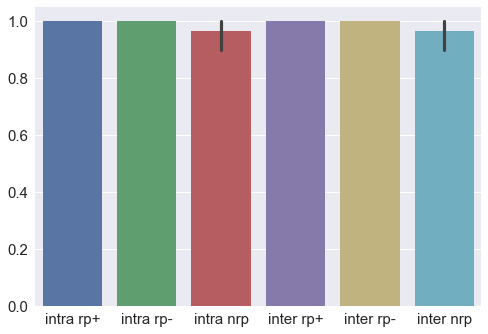

176 g:0.15 c:0.2 w:0.05 mi:-0.025 ma:0.05


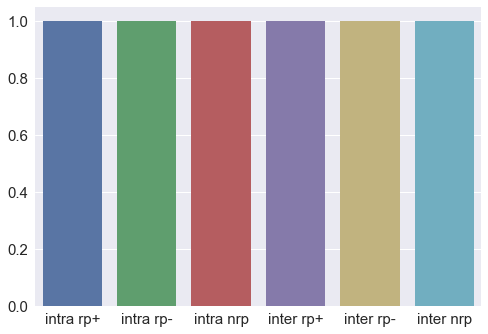

177 g:0.15 c:0.2 w:0.05 mi:-0.025 ma:0.1


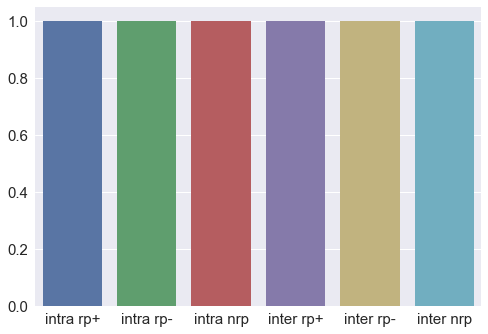

178 g:0.15 c:0.2 w:0.05 mi:-0.025 ma:0.15


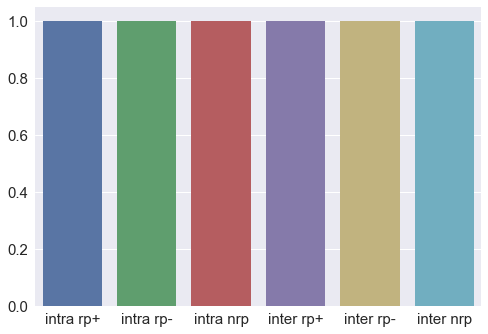

179 g:0.15 c:0.2 w:0.05 mi:-0.025 ma:0.2


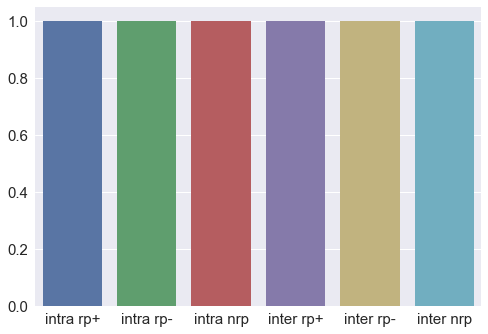

180 g:0.15 c:0.2 w:0.05 mi:-0.05 ma:0.025


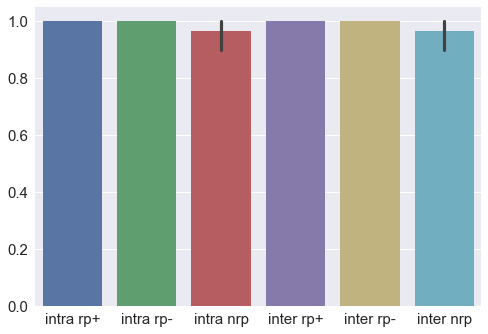

181 g:0.15 c:0.2 w:0.05 mi:-0.05 ma:0.05


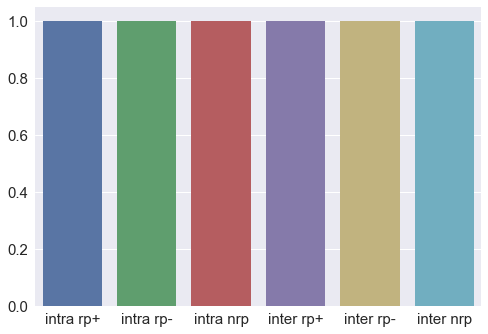

182 g:0.15 c:0.2 w:0.05 mi:-0.05 ma:0.1


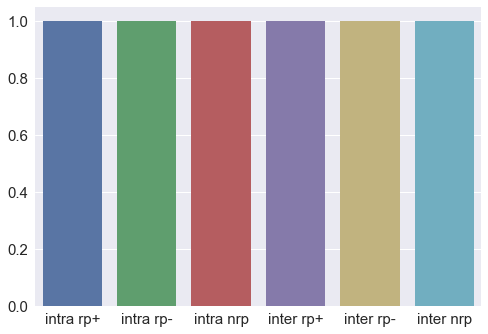

183 g:0.15 c:0.2 w:0.05 mi:-0.05 ma:0.15


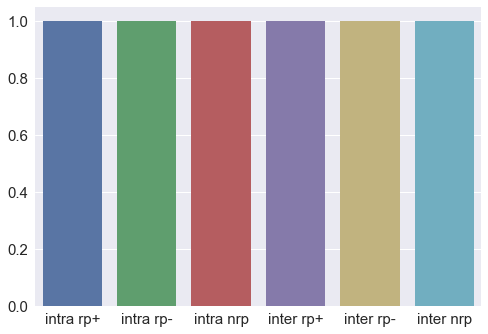

184 g:0.15 c:0.2 w:0.05 mi:-0.05 ma:0.2


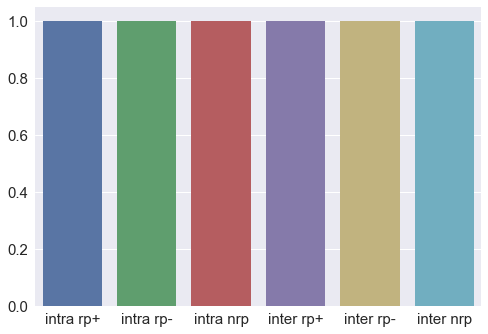

185 g:0.15 c:0.2 w:0.05 mi:-0.1 ma:0.025


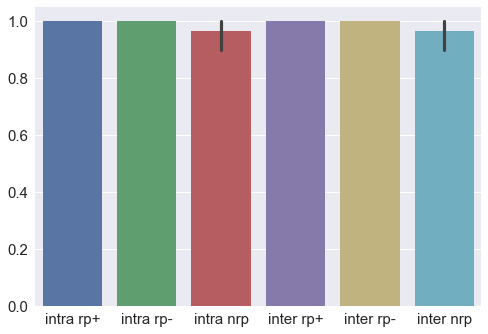

186 g:0.15 c:0.2 w:0.05 mi:-0.1 ma:0.05


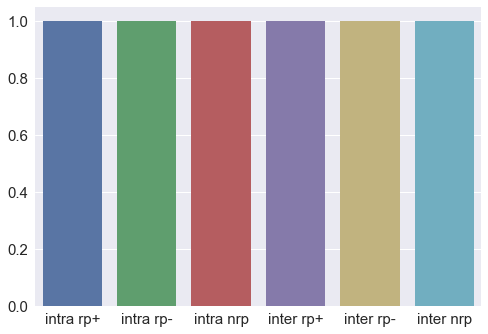

187 g:0.15 c:0.2 w:0.05 mi:-0.1 ma:0.1


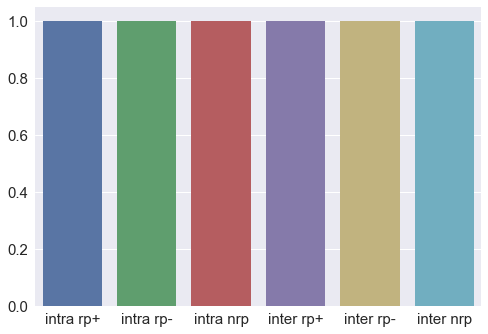

188 g:0.15 c:0.2 w:0.05 mi:-0.1 ma:0.15


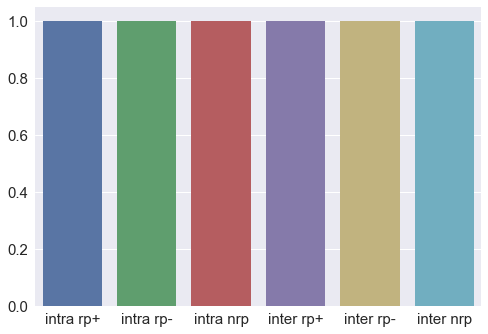

189 g:0.15 c:0.2 w:0.05 mi:-0.1 ma:0.2


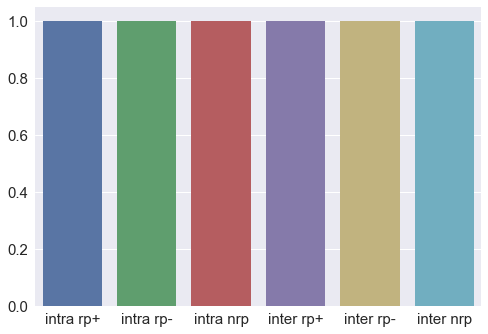

190 g:0.15 c:0.2 w:0.05 mi:-0.15 ma:0.025


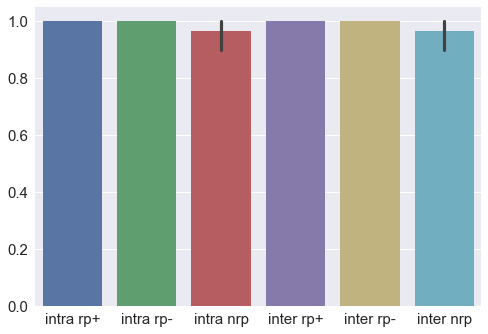

191 g:0.15 c:0.2 w:0.05 mi:-0.15 ma:0.05


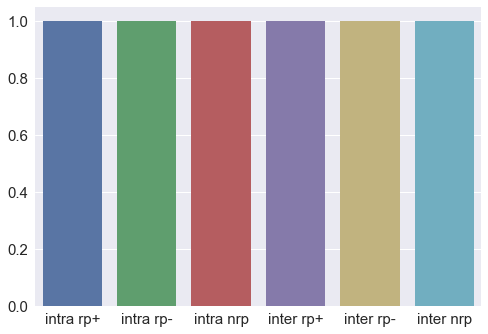

192 g:0.15 c:0.2 w:0.05 mi:-0.15 ma:0.1


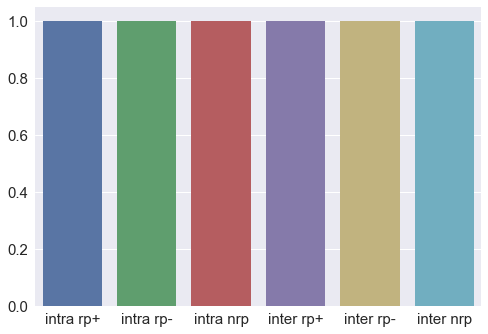

193 g:0.15 c:0.2 w:0.05 mi:-0.15 ma:0.15


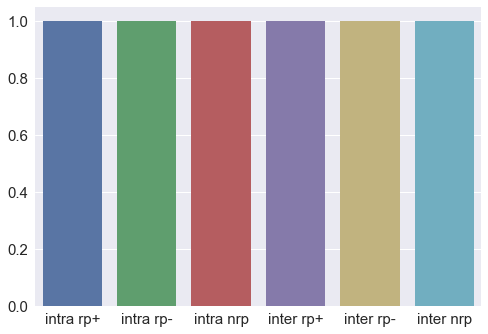

194 g:0.15 c:0.2 w:0.05 mi:-0.15 ma:0.2


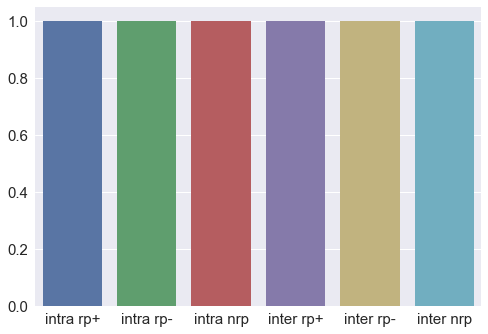

195 g:0.15 c:0.2 w:0.05 mi:-0.2 ma:0.025


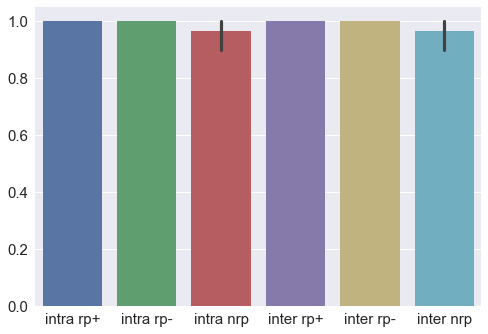

196 g:0.15 c:0.2 w:0.05 mi:-0.2 ma:0.05


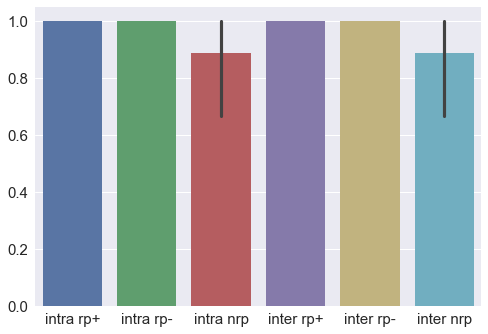

197 g:0.15 c:0.2 w:0.05 mi:-0.2 ma:0.1


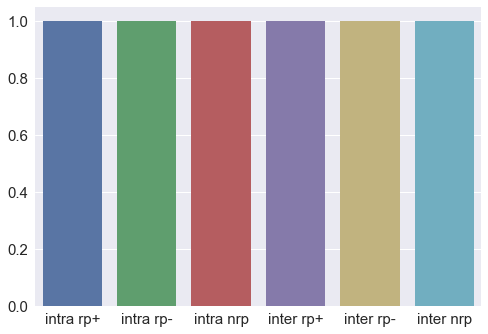

198 g:0.15 c:0.2 w:0.05 mi:-0.2 ma:0.15


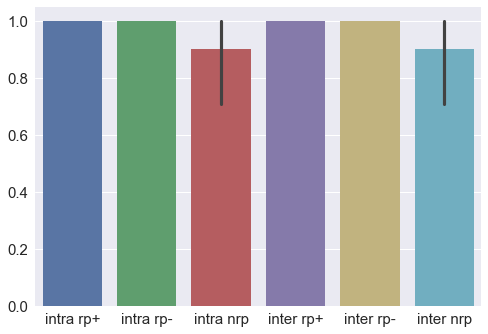

199 g:0.15 c:0.2 w:0.05 mi:-0.2 ma:0.2


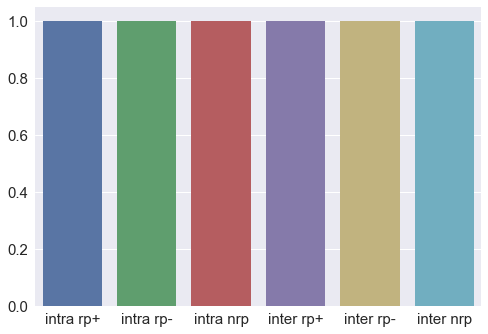

200 g:0.15 c:0.2 w:0.1 mi:-0.025 ma:0.025


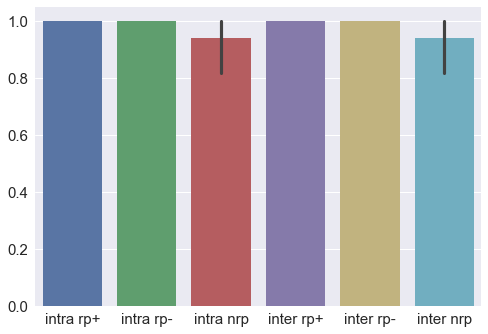

201 g:0.15 c:0.2 w:0.1 mi:-0.025 ma:0.05


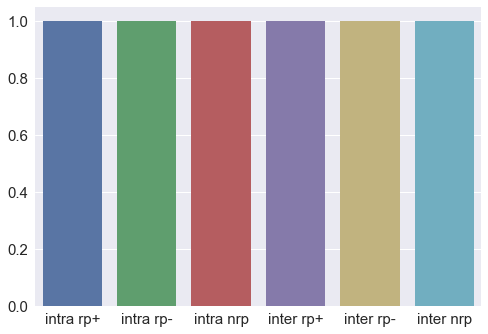

202 g:0.15 c:0.2 w:0.1 mi:-0.025 ma:0.1


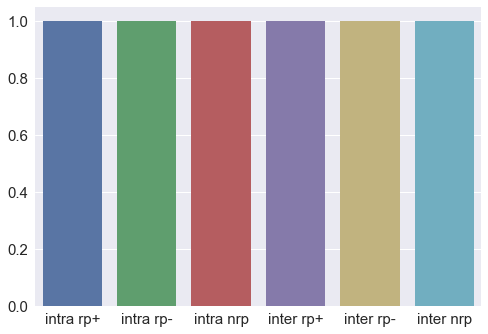

203 g:0.15 c:0.2 w:0.1 mi:-0.025 ma:0.15


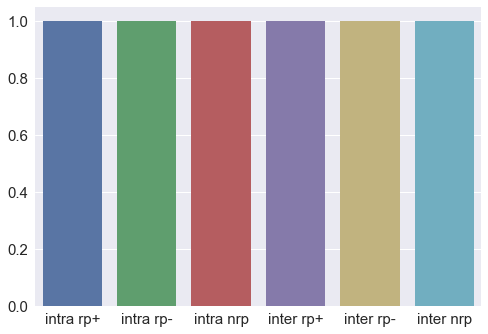

204 g:0.15 c:0.2 w:0.1 mi:-0.025 ma:0.2


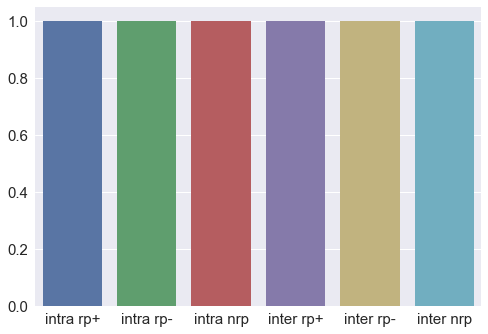

205 g:0.15 c:0.2 w:0.1 mi:-0.05 ma:0.025


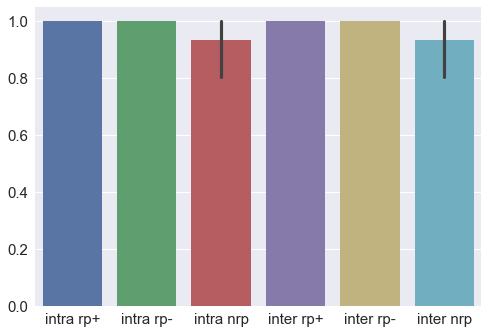

206 g:0.15 c:0.2 w:0.1 mi:-0.05 ma:0.05


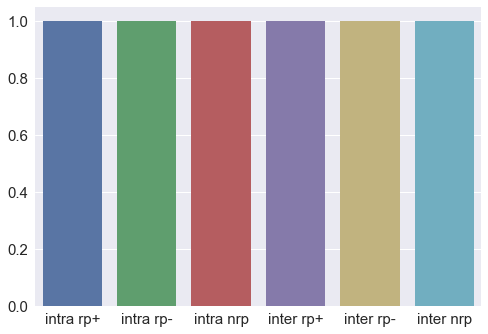

207 g:0.15 c:0.2 w:0.1 mi:-0.05 ma:0.1


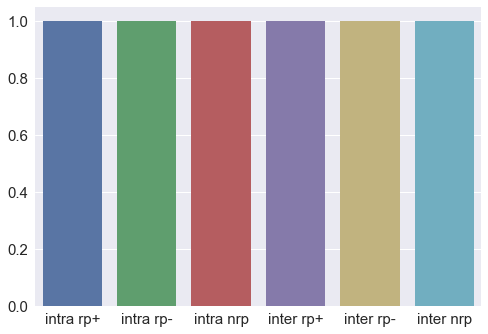

208 g:0.15 c:0.2 w:0.1 mi:-0.05 ma:0.15


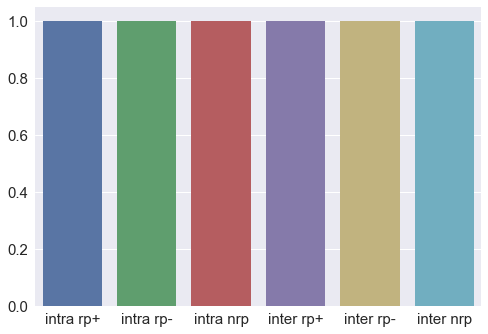

209 g:0.15 c:0.2 w:0.1 mi:-0.05 ma:0.2


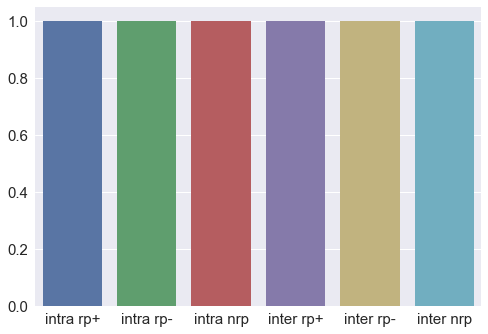

210 g:0.15 c:0.2 w:0.1 mi:-0.1 ma:0.025


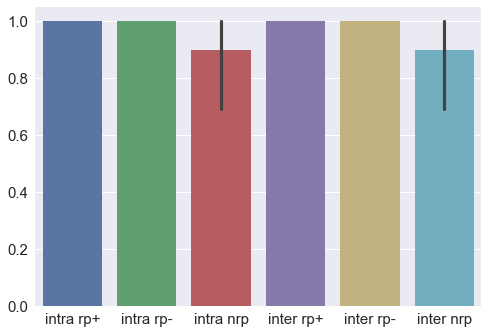

211 g:0.15 c:0.2 w:0.1 mi:-0.1 ma:0.05


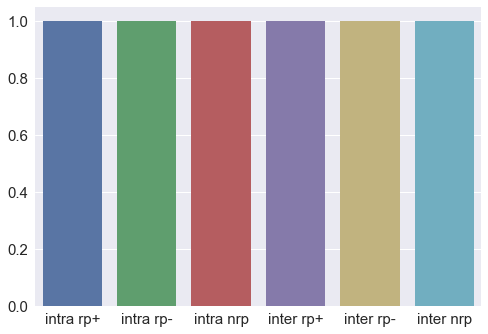

212 g:0.15 c:0.2 w:0.1 mi:-0.1 ma:0.1


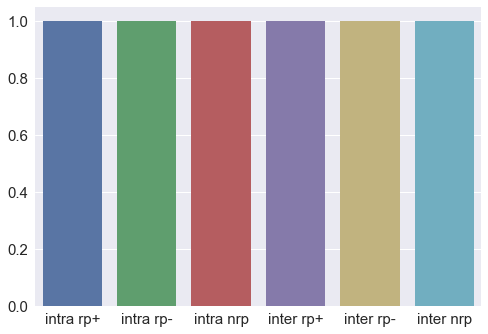

213 g:0.15 c:0.2 w:0.1 mi:-0.1 ma:0.15


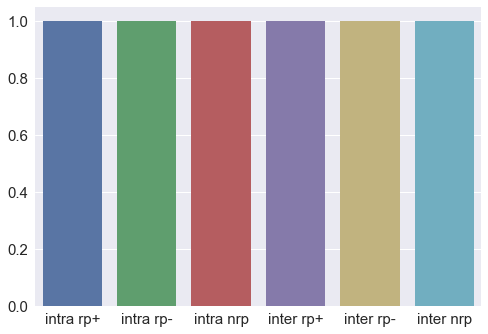

214 g:0.15 c:0.2 w:0.1 mi:-0.1 ma:0.2


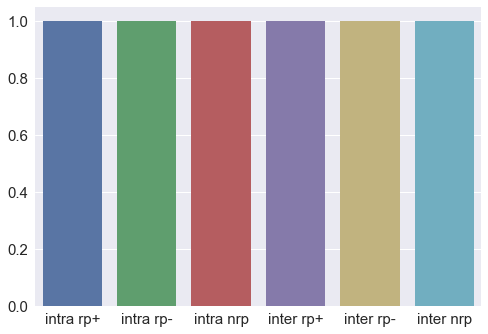

215 g:0.15 c:0.2 w:0.1 mi:-0.15 ma:0.025


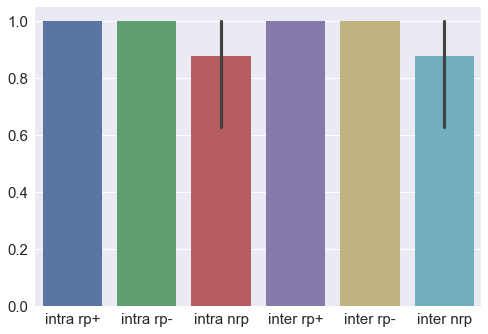

216 g:0.15 c:0.2 w:0.1 mi:-0.15 ma:0.05


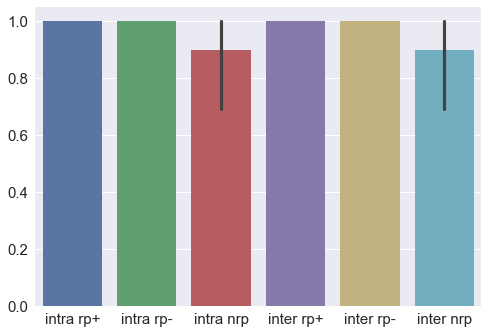

217 g:0.15 c:0.2 w:0.1 mi:-0.15 ma:0.1


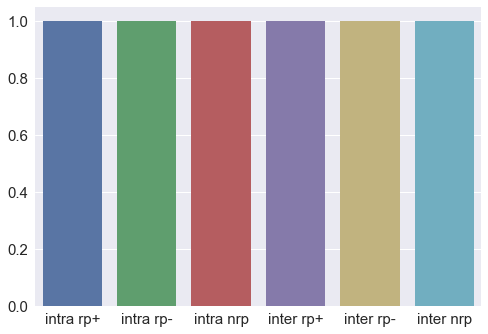

218 g:0.15 c:0.2 w:0.1 mi:-0.15 ma:0.15


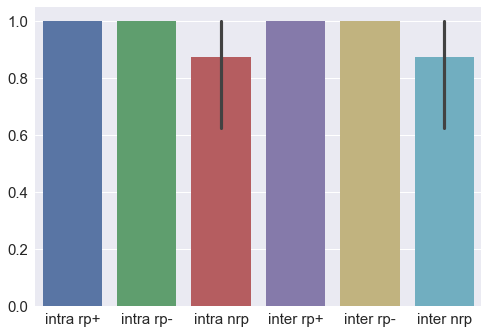

219 g:0.15 c:0.2 w:0.1 mi:-0.15 ma:0.2


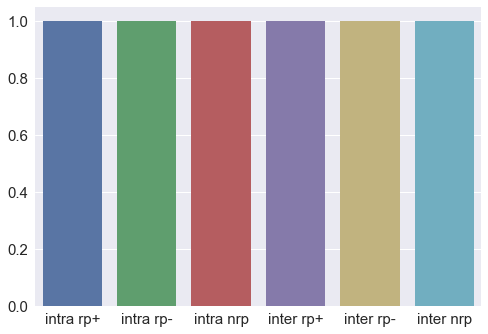

220 g:0.15 c:0.2 w:0.1 mi:-0.2 ma:0.025


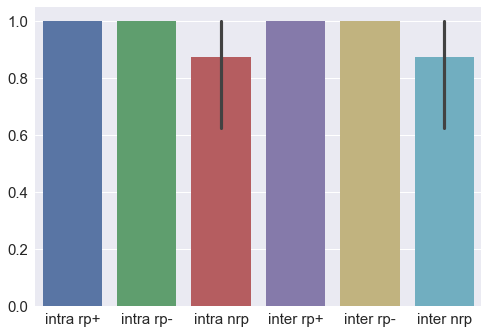

221 g:0.15 c:0.2 w:0.1 mi:-0.2 ma:0.05


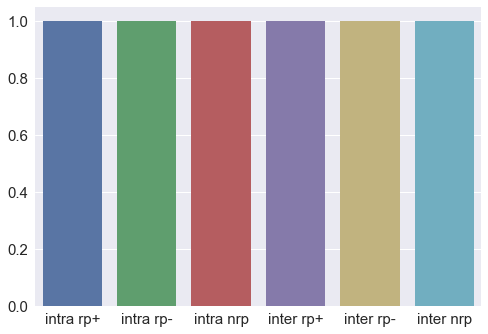

222 g:0.15 c:0.2 w:0.1 mi:-0.2 ma:0.1


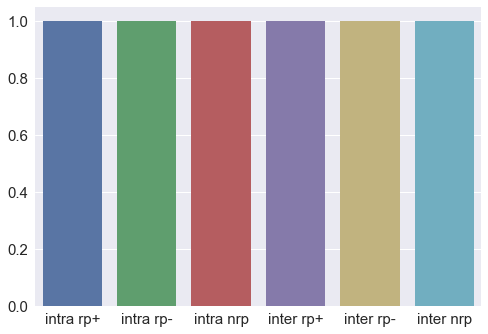

223 g:0.15 c:0.2 w:0.1 mi:-0.2 ma:0.15


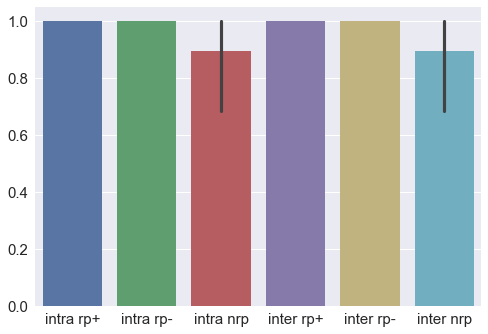

224 g:0.15 c:0.2 w:0.1 mi:-0.2 ma:0.2


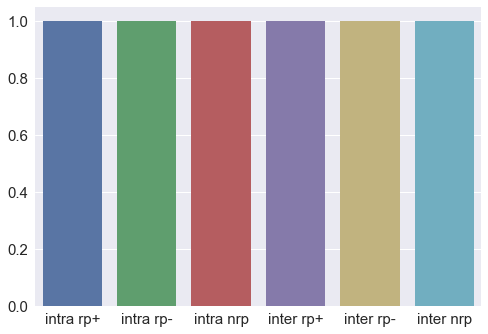

225 g:0.15 c:0.2 w:0.15 mi:-0.025 ma:0.025


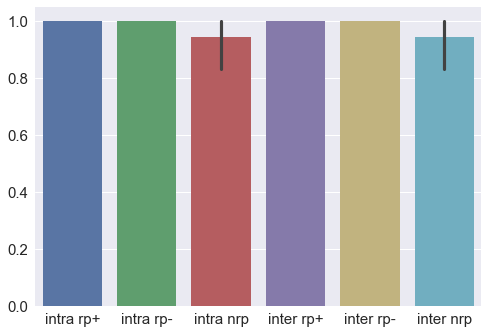

226 g:0.15 c:0.2 w:0.15 mi:-0.025 ma:0.05


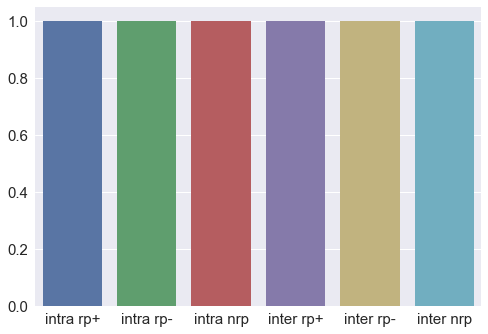

227 g:0.15 c:0.2 w:0.15 mi:-0.025 ma:0.1


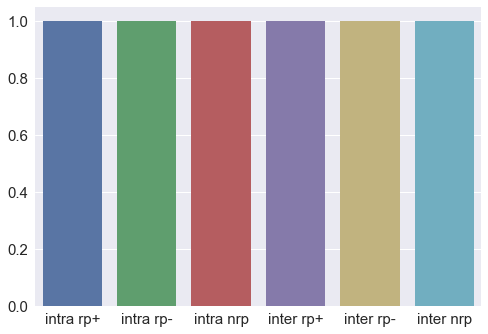

228 g:0.15 c:0.2 w:0.15 mi:-0.025 ma:0.15


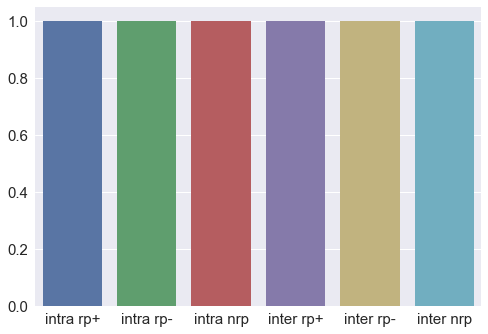

229 g:0.15 c:0.2 w:0.15 mi:-0.025 ma:0.2


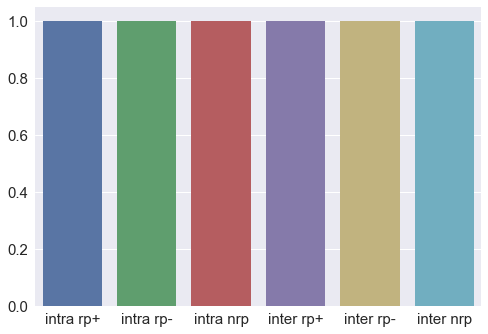

230 g:0.15 c:0.2 w:0.15 mi:-0.05 ma:0.025


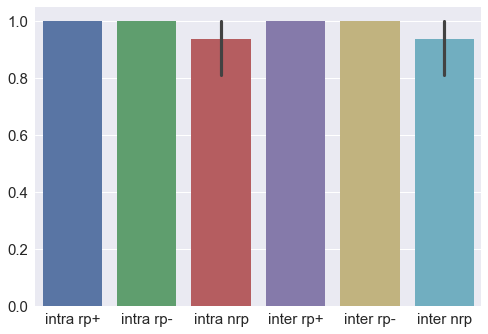

231 g:0.15 c:0.2 w:0.15 mi:-0.05 ma:0.05


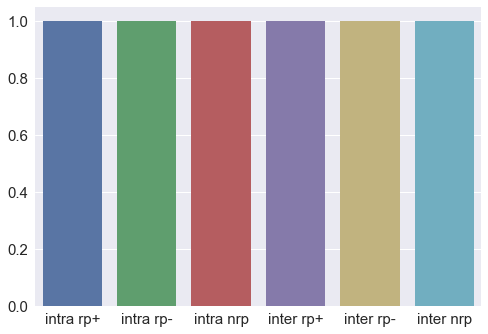

232 g:0.15 c:0.2 w:0.15 mi:-0.05 ma:0.1


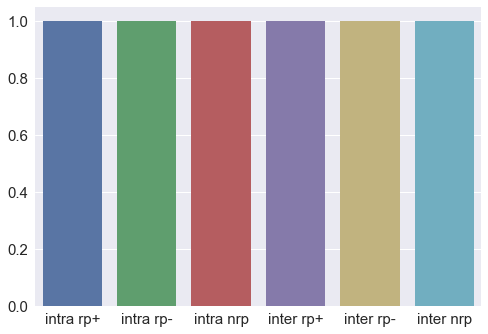

233 g:0.15 c:0.2 w:0.15 mi:-0.05 ma:0.15


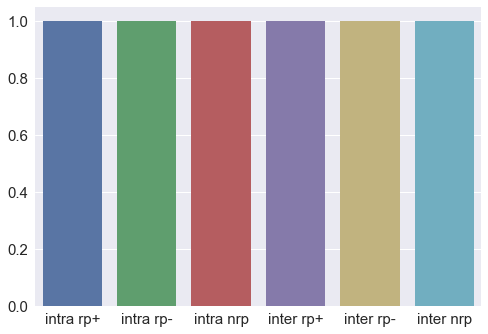

234 g:0.15 c:0.2 w:0.15 mi:-0.05 ma:0.2


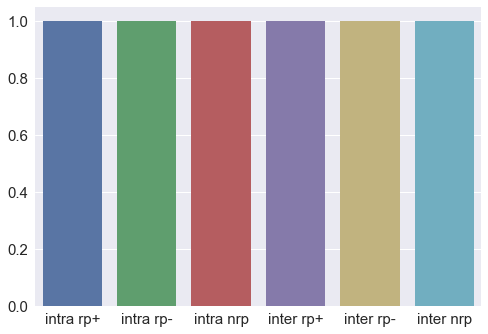

235 g:0.15 c:0.2 w:0.15 mi:-0.1 ma:0.025


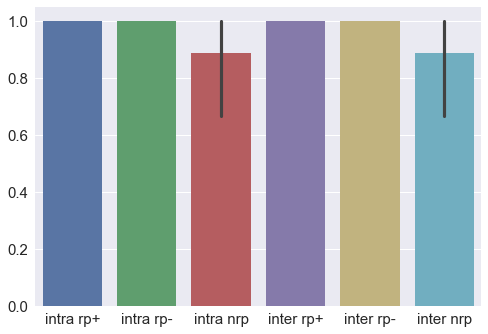

236 g:0.15 c:0.2 w:0.15 mi:-0.1 ma:0.05


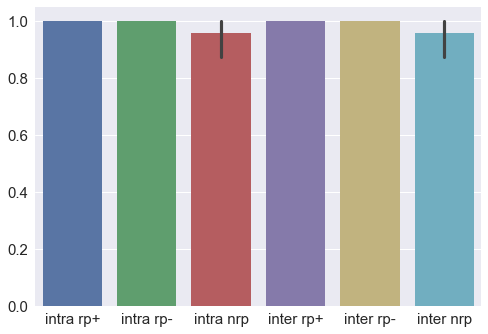

237 g:0.15 c:0.2 w:0.15 mi:-0.1 ma:0.1


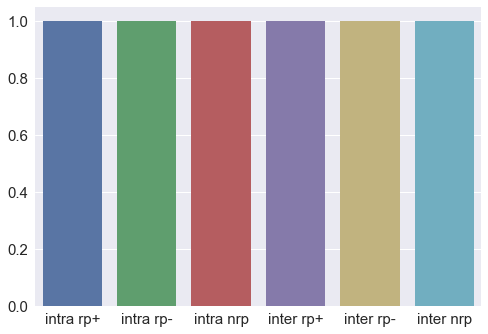

238 g:0.15 c:0.2 w:0.15 mi:-0.1 ma:0.15


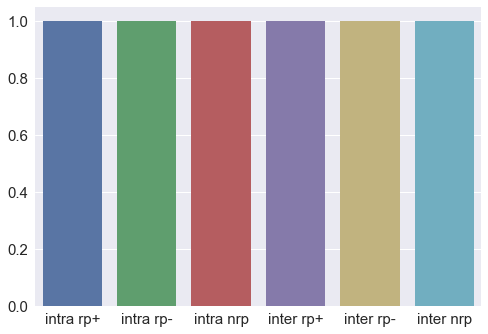

239 g:0.15 c:0.2 w:0.15 mi:-0.1 ma:0.2


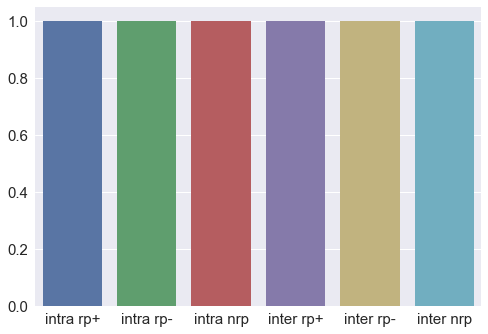

240 g:0.15 c:0.2 w:0.15 mi:-0.15 ma:0.025


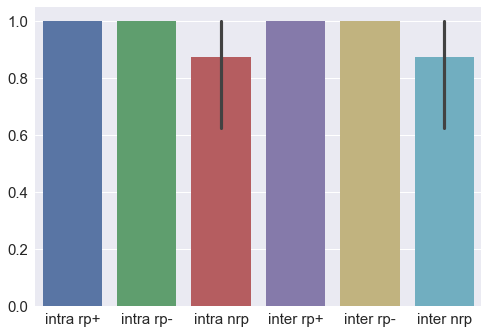

241 g:0.15 c:0.2 w:0.15 mi:-0.15 ma:0.05


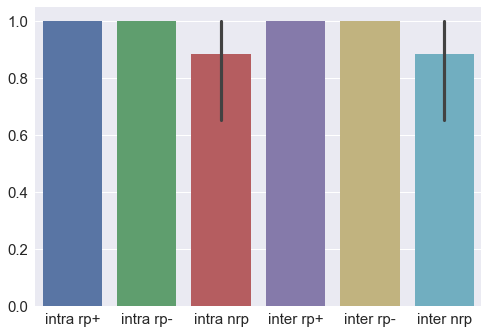

242 g:0.15 c:0.2 w:0.15 mi:-0.15 ma:0.1


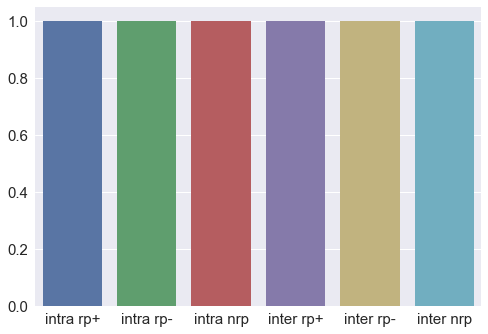

243 g:0.15 c:0.2 w:0.15 mi:-0.15 ma:0.15


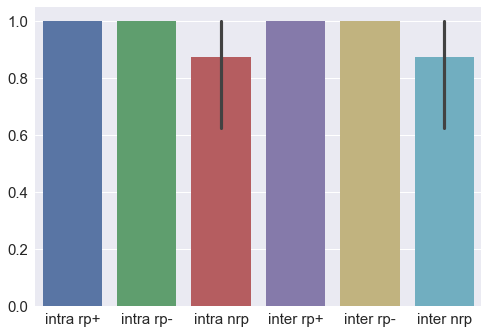

244 g:0.15 c:0.2 w:0.15 mi:-0.15 ma:0.2


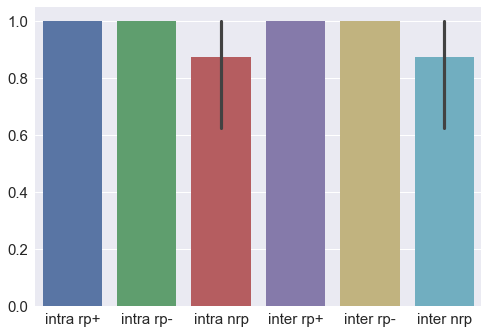

245 g:0.15 c:0.2 w:0.15 mi:-0.2 ma:0.025


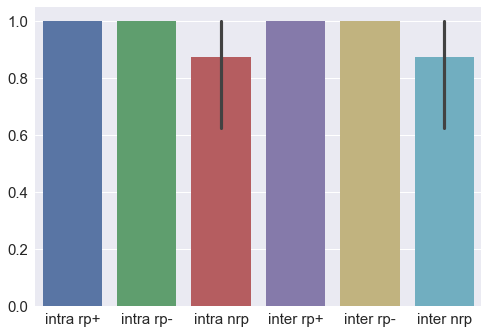

246 g:0.15 c:0.2 w:0.15 mi:-0.2 ma:0.05


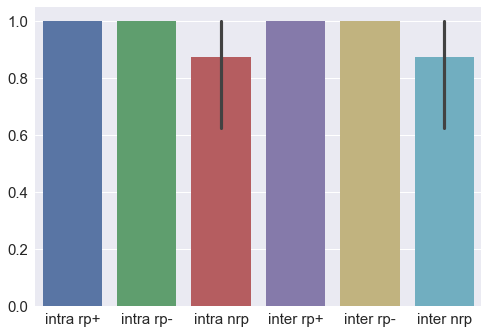

247 g:0.15 c:0.2 w:0.15 mi:-0.2 ma:0.1


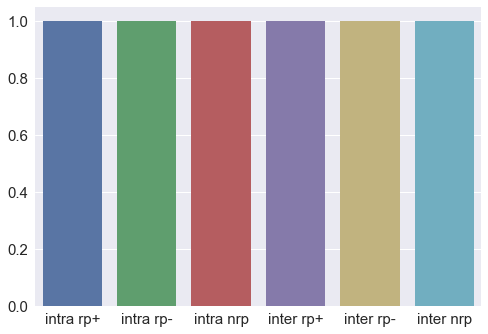

248 g:0.15 c:0.2 w:0.15 mi:-0.2 ma:0.15


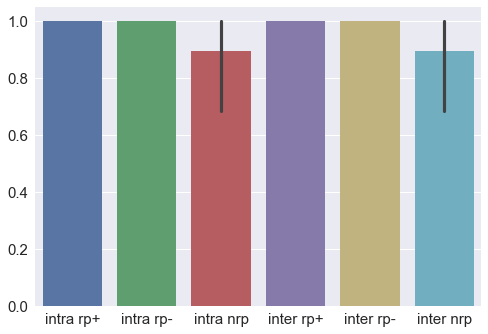

249 g:0.15 c:0.2 w:0.15 mi:-0.2 ma:0.2


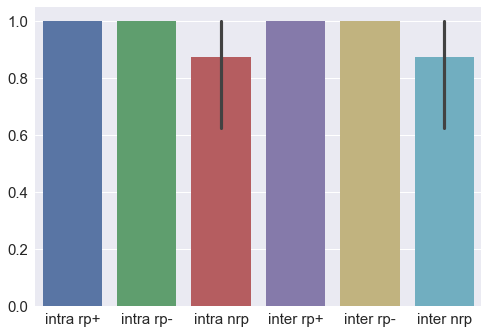

In [979]:
for i, result in enumerate(results):
    # intra: rp- < baseline, rp+ > baseline
    # inter: rp- == baseline, rp+ > baseline
    
    rp_plus_intra = result['intra'].adj[-2, [0, 1, 2, 3]]
    rp_minus_intra = result['intra'].adj[-2, [4, 5, 6, 7]]
    nrp_intra = result['intra'].adj[-1, 8:16]
    
    rp_plus_inter = result['inter'].adj[-2, [0, 2, 4, 6]]
    rp_minus_inter = result['inter'].adj[-2, [1, 3, 5, 7]]
    nrp_inter = result['inter'].adj[-1, 8:16]
    
    #if (np.mean(rp_minus_intra) < np.mean(nrp_intra) and
    #        np.mean(rp_plus_intra) >  np.mean(nrp_intra) and
    #        np.mean(rp_minus_inter) < np.mean(nrp_inter) + .1 and
    #        np.mean(rp_minus_inter) > np.mean(nrp_inter) - .1 and
    #        np.mean(rp_plus_inter) >  np.mean(nrp_inter)):
    #if (np.mean(rp_minus_intra) < (np.mean(rp_minus_inter) * (5/6)) and
    #        np.mean(rp_minus_inter) > (np.mean(nrp_inter) * (5/6)) and
    #        np.mean(rp_minus_inter) < (np.mean(nrp_inter) * (7/6))):
    print(f"{i} g:{result['gamma']} c:{result['xcat_center']} w:{result['xcat_width']} mi:{result['xcat_min']} ma:{result['xcat_max']}")
    ax = sns.barplot(data=[rp_plus_intra, rp_minus_intra, nrp_intra, rp_plus_inter, rp_minus_inter, nrp_inter], estimator=np.mean)
    ax.set(xticklabels=['intra rp+', 'intra rp-', 'intra nrp', 'inter rp+', 'inter rp-', 'inter nrp']);
    plt.show();


In [762]:
my_result = results[17]

rp_plus_intra = my_result['intra'].adj[-2, [0, 1, 2, 3]]
rp_minus_intra = my_result['intra'].adj[-2, [4, 5, 6, 7]]
nrp_intra = my_result['intra'].adj[-1, 8:16]

rp_plus_inter = my_result['inter'].adj[-2, [0, 2, 4, 6]]
rp_minus_inter = my_result['inter'].adj[-2, [1, 3, 5, 7]]
nrp_inter = my_result['inter'].adj[-1, 8:16]

print(np.mean(rp_plus_intra))
print(np.mean(rp_minus_intra))
print(np.mean(nrp_intra))
print(np.mean(rp_plus_inter))
print(np.mean(rp_minus_inter))
print(np.mean(nrp_inter))

0.305927761058
0.286595118549
0.3
0.28125564932
0.27101357356
0.3


0 g:0.3 c:0.1 w:0.05 mi:-0.025 ma:0.025


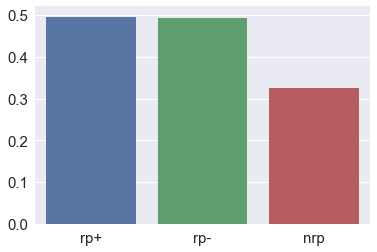

1 g:0.3 c:0.1 w:0.05 mi:-0.025 ma:0.05


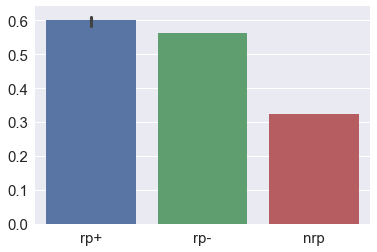

2 g:0.3 c:0.1 w:0.05 mi:-0.025 ma:0.1


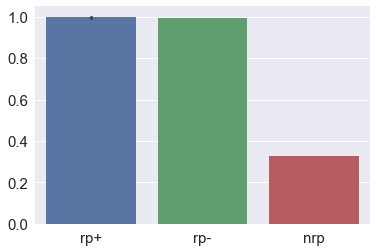

3 g:0.3 c:0.1 w:0.05 mi:-0.05 ma:0.025


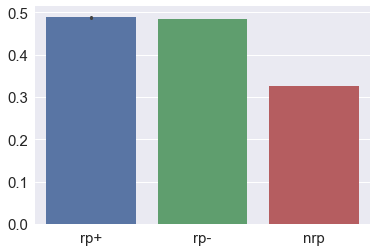

4 g:0.3 c:0.1 w:0.05 mi:-0.05 ma:0.05


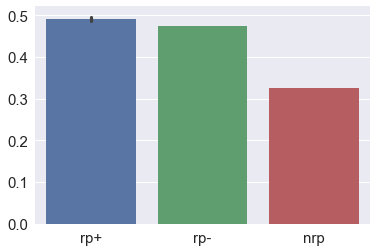

5 g:0.3 c:0.1 w:0.05 mi:-0.05 ma:0.1


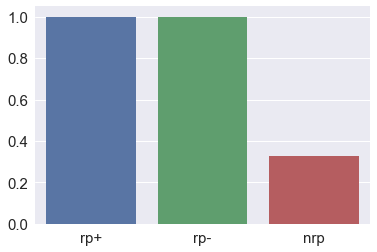

6 g:0.3 c:0.1 w:0.05 mi:-0.1 ma:0.025


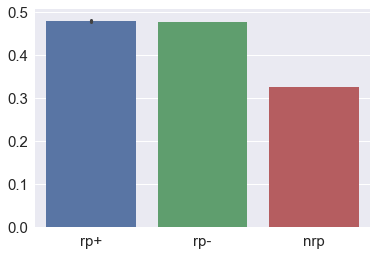

7 g:0.3 c:0.1 w:0.05 mi:-0.1 ma:0.05


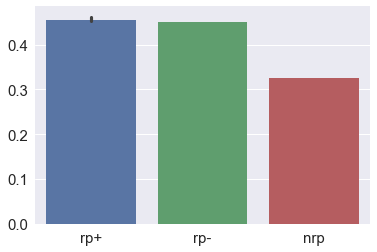

8 g:0.3 c:0.1 w:0.05 mi:-0.1 ma:0.1


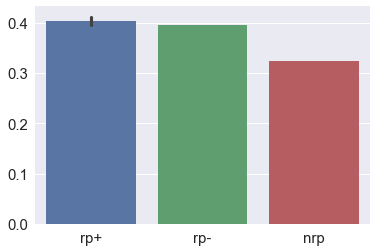

9 g:0.3 c:0.1 w:0.1 mi:-0.025 ma:0.025


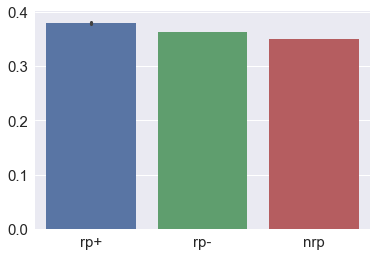

10 g:0.3 c:0.1 w:0.1 mi:-0.025 ma:0.05


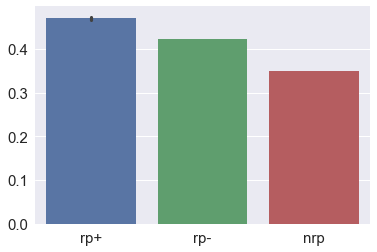

11 g:0.3 c:0.1 w:0.1 mi:-0.025 ma:0.1


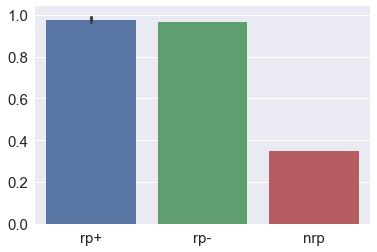

12 g:0.3 c:0.1 w:0.1 mi:-0.05 ma:0.025


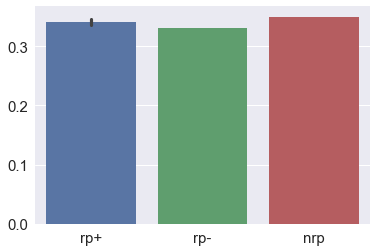

13 g:0.3 c:0.1 w:0.1 mi:-0.05 ma:0.05


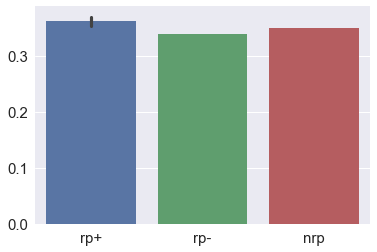

14 g:0.3 c:0.1 w:0.1 mi:-0.05 ma:0.1


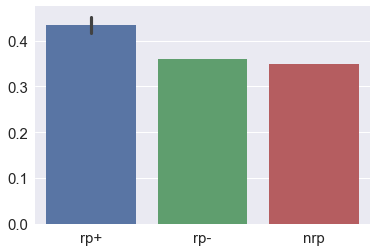

15 g:0.3 c:0.1 w:0.1 mi:-0.1 ma:0.025


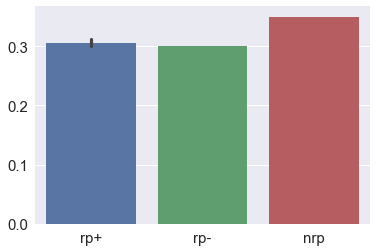

16 g:0.3 c:0.1 w:0.1 mi:-0.1 ma:0.05


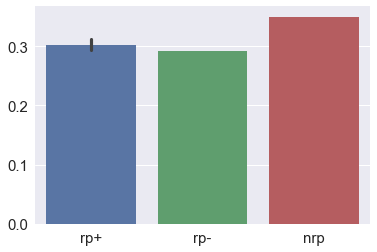

17 g:0.3 c:0.1 w:0.1 mi:-0.1 ma:0.1


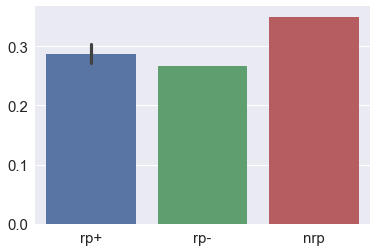

18 g:0.3 c:0.1 w:0.15 mi:-0.025 ma:0.025


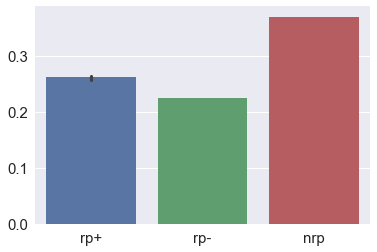

19 g:0.3 c:0.1 w:0.15 mi:-0.025 ma:0.05


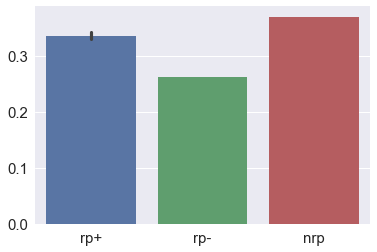

20 g:0.3 c:0.1 w:0.15 mi:-0.025 ma:0.1


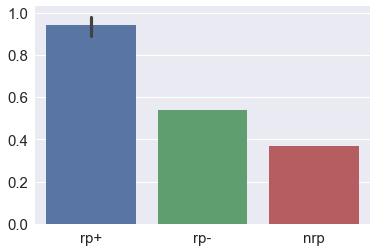

21 g:0.3 c:0.1 w:0.15 mi:-0.05 ma:0.025


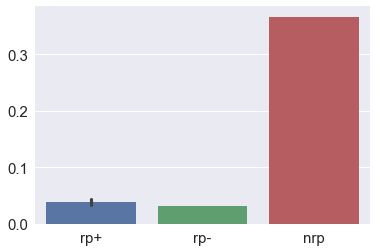

22 g:0.3 c:0.1 w:0.15 mi:-0.05 ma:0.05


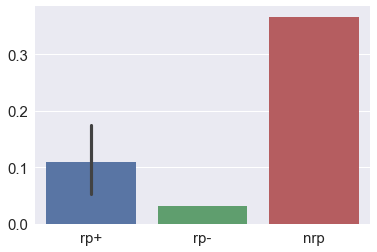

23 g:0.3 c:0.1 w:0.15 mi:-0.05 ma:0.1


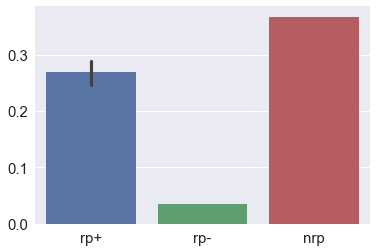

24 g:0.3 c:0.1 w:0.15 mi:-0.1 ma:0.025


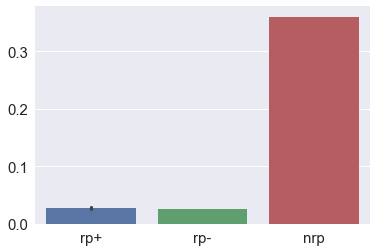

25 g:0.3 c:0.1 w:0.15 mi:-0.1 ma:0.05


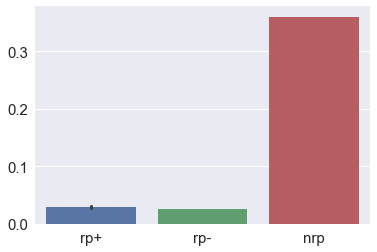

26 g:0.3 c:0.1 w:0.15 mi:-0.1 ma:0.1


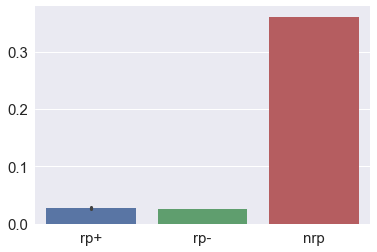

27 g:0.3 c:0.15 w:0.05 mi:-0.025 ma:0.025


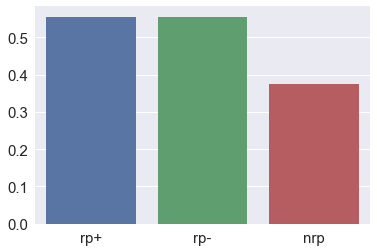

28 g:0.3 c:0.15 w:0.05 mi:-0.025 ma:0.05


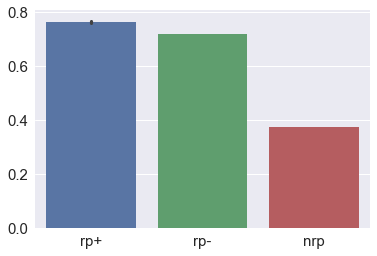

29 g:0.3 c:0.15 w:0.05 mi:-0.025 ma:0.1


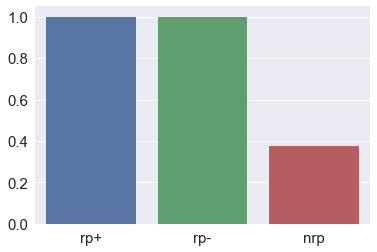

30 g:0.3 c:0.15 w:0.05 mi:-0.05 ma:0.025


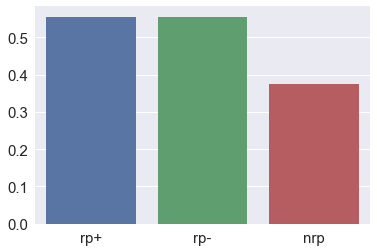

31 g:0.3 c:0.15 w:0.05 mi:-0.05 ma:0.05


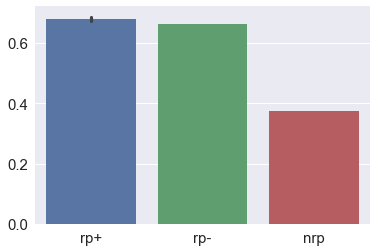

32 g:0.3 c:0.15 w:0.05 mi:-0.05 ma:0.1


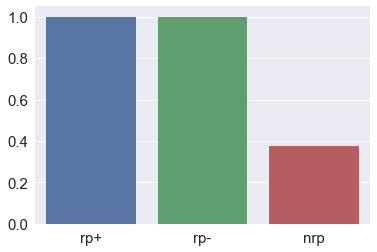

33 g:0.3 c:0.15 w:0.05 mi:-0.1 ma:0.025


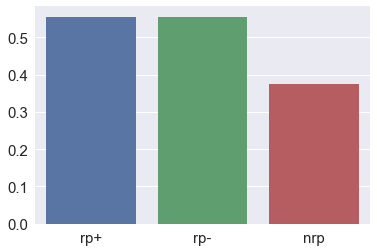

34 g:0.3 c:0.15 w:0.05 mi:-0.1 ma:0.05


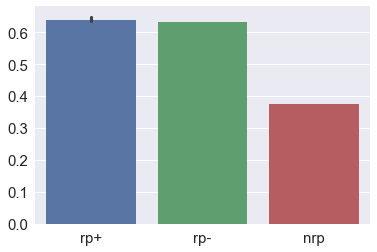

35 g:0.3 c:0.15 w:0.05 mi:-0.1 ma:0.1


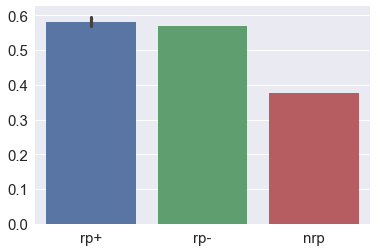

36 g:0.3 c:0.15 w:0.1 mi:-0.025 ma:0.025


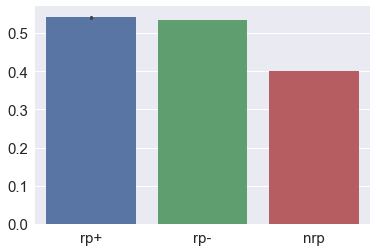

37 g:0.3 c:0.15 w:0.1 mi:-0.025 ma:0.05


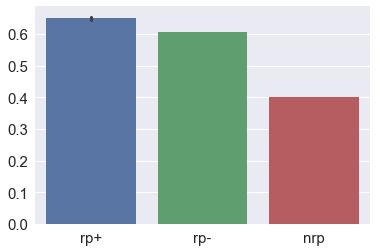

38 g:0.3 c:0.15 w:0.1 mi:-0.025 ma:0.1


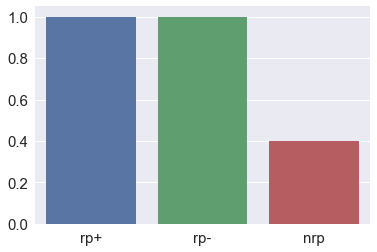

39 g:0.3 c:0.15 w:0.1 mi:-0.05 ma:0.025


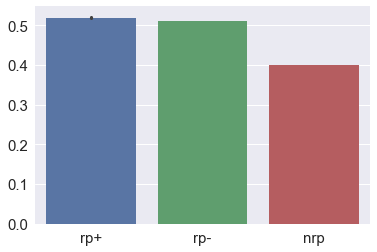

40 g:0.3 c:0.15 w:0.1 mi:-0.05 ma:0.05


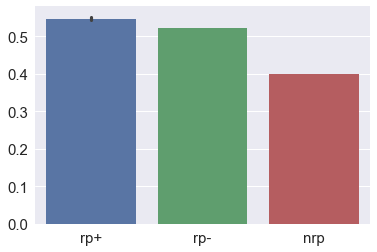

41 g:0.3 c:0.15 w:0.1 mi:-0.05 ma:0.1


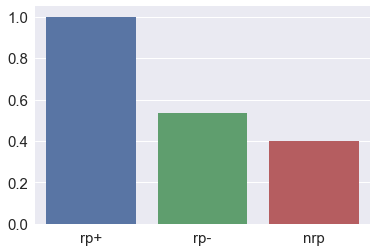

42 g:0.3 c:0.15 w:0.1 mi:-0.1 ma:0.025


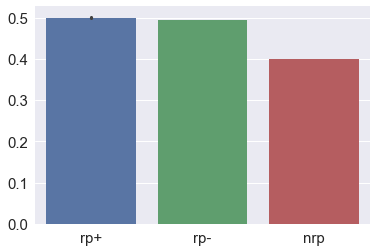

43 g:0.3 c:0.15 w:0.1 mi:-0.1 ma:0.05


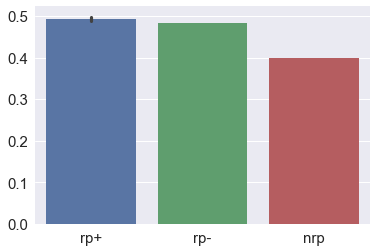

44 g:0.3 c:0.15 w:0.1 mi:-0.1 ma:0.1


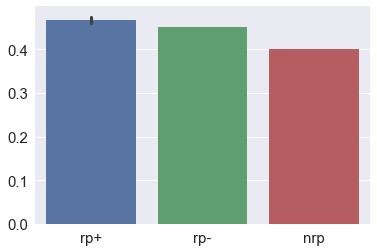

45 g:0.3 c:0.15 w:0.15 mi:-0.025 ma:0.025


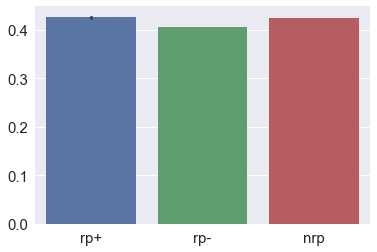

46 g:0.3 c:0.15 w:0.15 mi:-0.025 ma:0.05


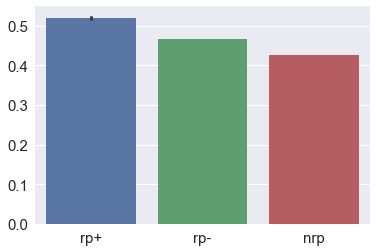

47 g:0.3 c:0.15 w:0.15 mi:-0.025 ma:0.1


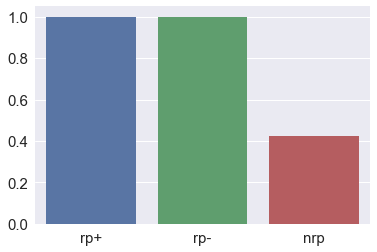

48 g:0.3 c:0.15 w:0.15 mi:-0.05 ma:0.025


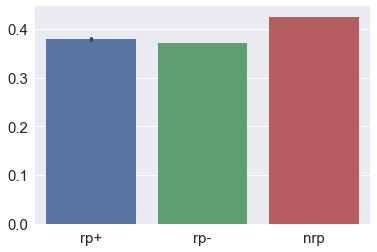

49 g:0.3 c:0.15 w:0.15 mi:-0.05 ma:0.05


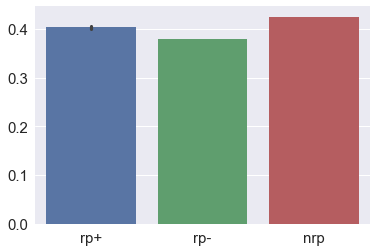

50 g:0.3 c:0.15 w:0.15 mi:-0.05 ma:0.1


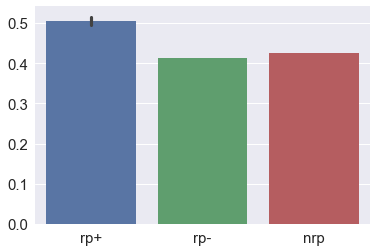

51 g:0.3 c:0.15 w:0.15 mi:-0.1 ma:0.025


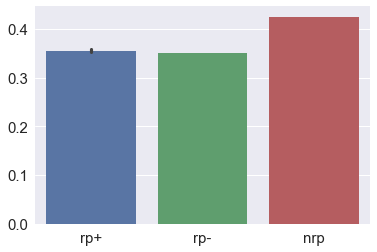

52 g:0.3 c:0.15 w:0.15 mi:-0.1 ma:0.05


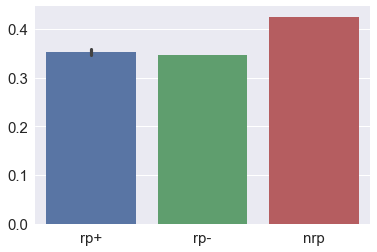

53 g:0.3 c:0.15 w:0.15 mi:-0.1 ma:0.1


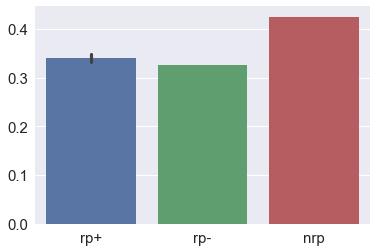

54 g:0.3 c:0.15 w:0.2 mi:-0.025 ma:0.025


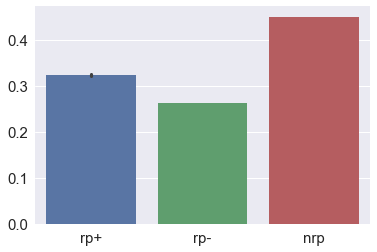

55 g:0.3 c:0.15 w:0.2 mi:-0.025 ma:0.05


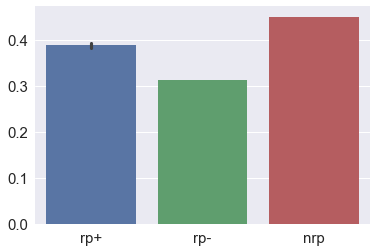

56 g:0.3 c:0.15 w:0.2 mi:-0.025 ma:0.1


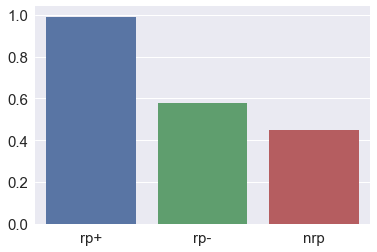

57 g:0.3 c:0.15 w:0.2 mi:-0.05 ma:0.025


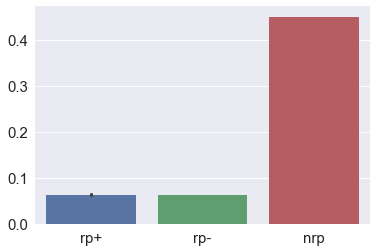

58 g:0.3 c:0.15 w:0.2 mi:-0.05 ma:0.05


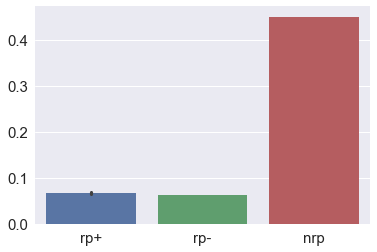

59 g:0.3 c:0.15 w:0.2 mi:-0.05 ma:0.1


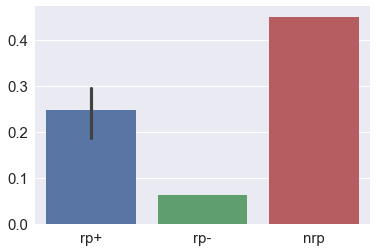

60 g:0.3 c:0.15 w:0.2 mi:-0.1 ma:0.025


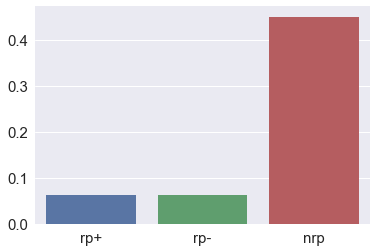

61 g:0.3 c:0.15 w:0.2 mi:-0.1 ma:0.05


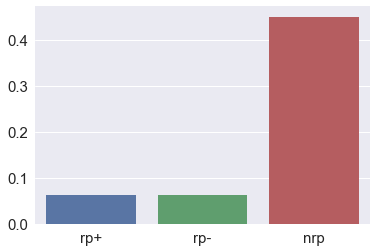

62 g:0.3 c:0.15 w:0.2 mi:-0.1 ma:0.1


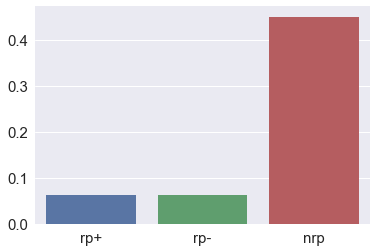

63 g:0.3 c:0.2 w:0.05 mi:-0.025 ma:0.025


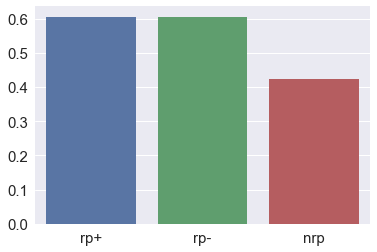

64 g:0.3 c:0.2 w:0.05 mi:-0.025 ma:0.05


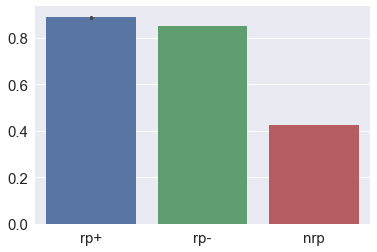

65 g:0.3 c:0.2 w:0.05 mi:-0.025 ma:0.1


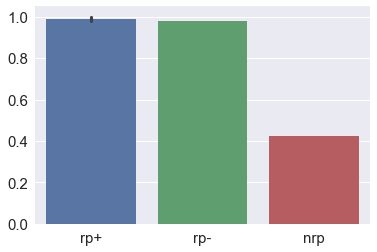

66 g:0.3 c:0.2 w:0.05 mi:-0.05 ma:0.025


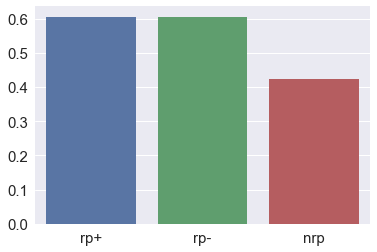

67 g:0.3 c:0.2 w:0.05 mi:-0.05 ma:0.05


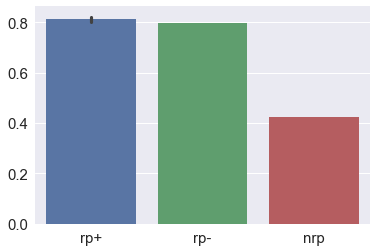

68 g:0.3 c:0.2 w:0.05 mi:-0.05 ma:0.1


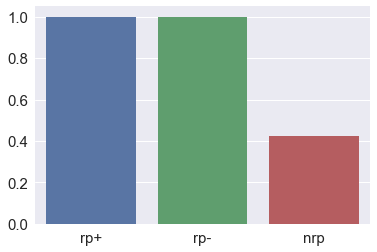

69 g:0.3 c:0.2 w:0.05 mi:-0.1 ma:0.025


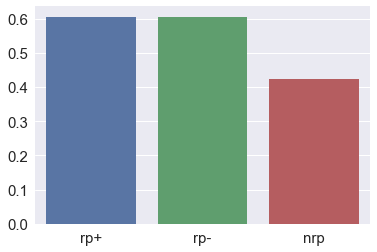

70 g:0.3 c:0.2 w:0.05 mi:-0.1 ma:0.05


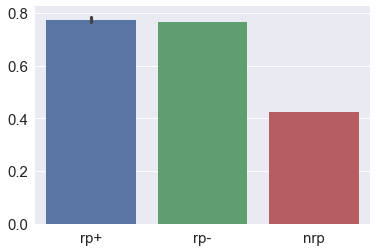

71 g:0.3 c:0.2 w:0.05 mi:-0.1 ma:0.1


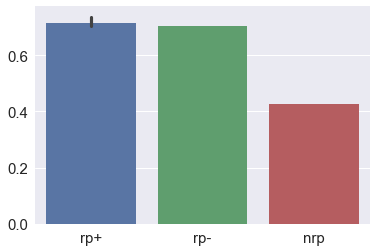

72 g:0.3 c:0.2 w:0.1 mi:-0.025 ma:0.025


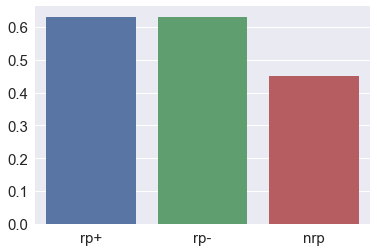

73 g:0.3 c:0.2 w:0.1 mi:-0.025 ma:0.05


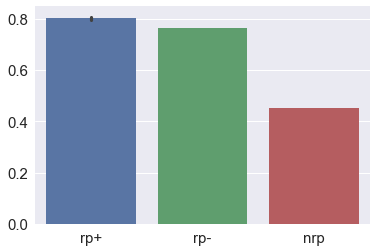

74 g:0.3 c:0.2 w:0.1 mi:-0.025 ma:0.1


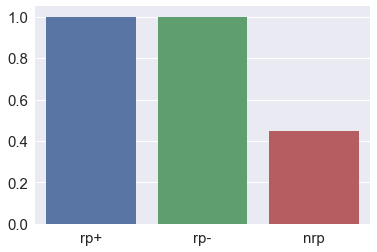

75 g:0.3 c:0.2 w:0.1 mi:-0.05 ma:0.025


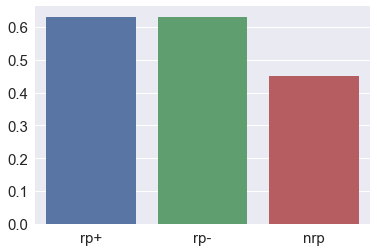

76 g:0.3 c:0.2 w:0.1 mi:-0.05 ma:0.05


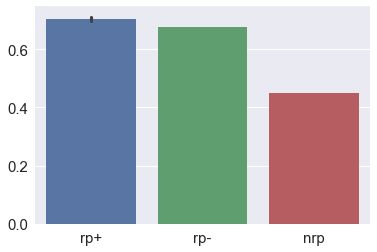

77 g:0.3 c:0.2 w:0.1 mi:-0.05 ma:0.1


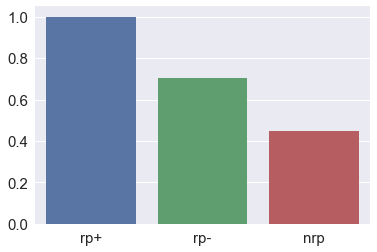

78 g:0.3 c:0.2 w:0.1 mi:-0.1 ma:0.025


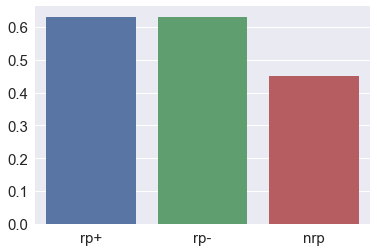

79 g:0.3 c:0.2 w:0.1 mi:-0.1 ma:0.05


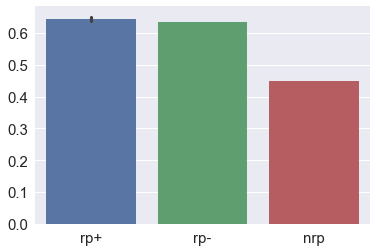

80 g:0.3 c:0.2 w:0.1 mi:-0.1 ma:0.1


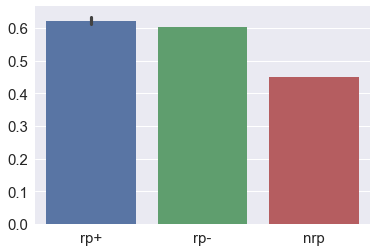

81 g:0.3 c:0.2 w:0.15 mi:-0.025 ma:0.025


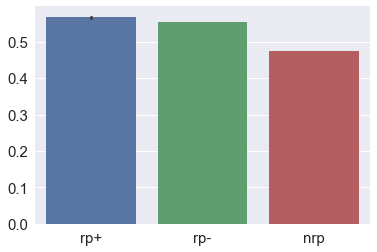

82 g:0.3 c:0.2 w:0.15 mi:-0.025 ma:0.05


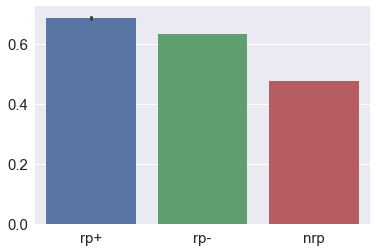

83 g:0.3 c:0.2 w:0.15 mi:-0.025 ma:0.1


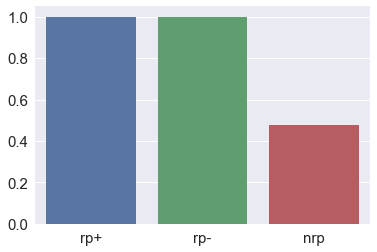

84 g:0.3 c:0.2 w:0.15 mi:-0.05 ma:0.025


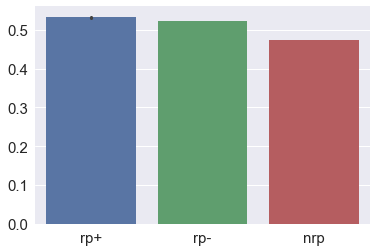

85 g:0.3 c:0.2 w:0.15 mi:-0.05 ma:0.05


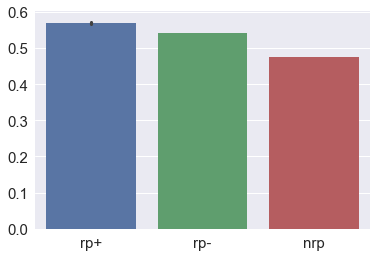

86 g:0.3 c:0.2 w:0.15 mi:-0.05 ma:0.1


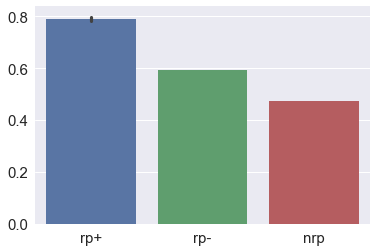

87 g:0.3 c:0.2 w:0.15 mi:-0.1 ma:0.025


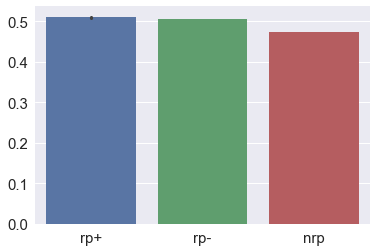

88 g:0.3 c:0.2 w:0.15 mi:-0.1 ma:0.05


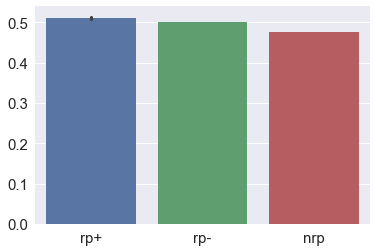

89 g:0.3 c:0.2 w:0.15 mi:-0.1 ma:0.1


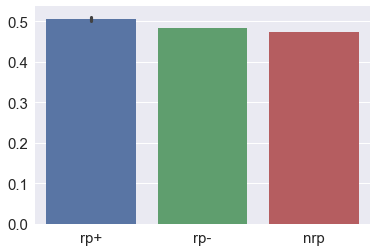

90 g:0.3 c:0.2 w:0.2 mi:-0.025 ma:0.025


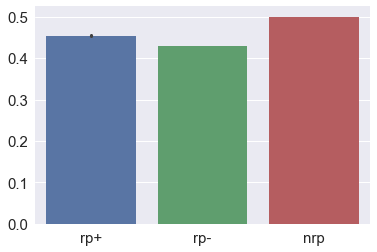

91 g:0.3 c:0.2 w:0.2 mi:-0.025 ma:0.05


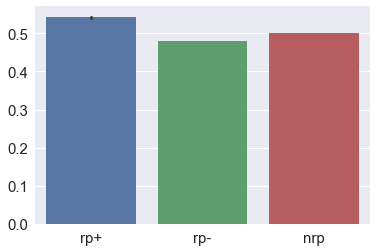

92 g:0.3 c:0.2 w:0.2 mi:-0.025 ma:0.1


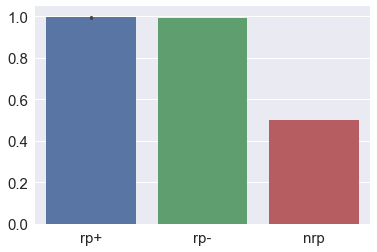

93 g:0.3 c:0.2 w:0.2 mi:-0.05 ma:0.025


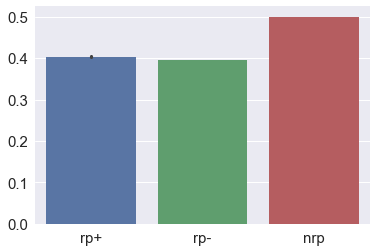

94 g:0.3 c:0.2 w:0.2 mi:-0.05 ma:0.05


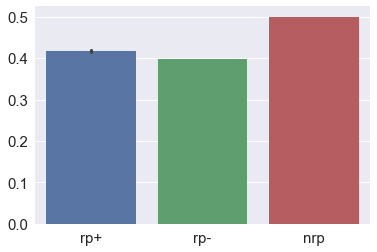

95 g:0.3 c:0.2 w:0.2 mi:-0.05 ma:0.1


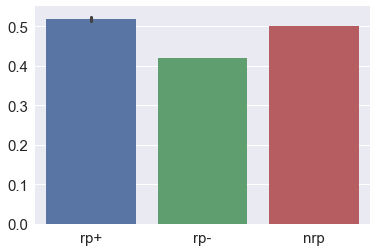

96 g:0.3 c:0.2 w:0.2 mi:-0.1 ma:0.025


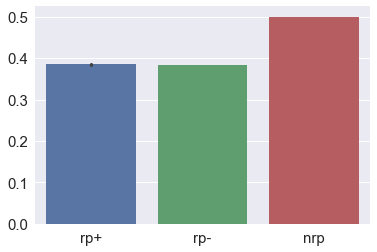

97 g:0.3 c:0.2 w:0.2 mi:-0.1 ma:0.05


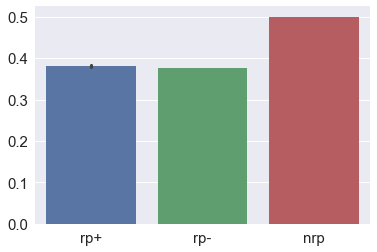

98 g:0.3 c:0.2 w:0.2 mi:-0.1 ma:0.1


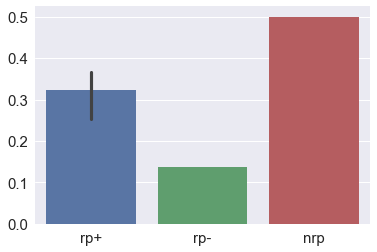

99 g:0.5 c:0.1 w:0.05 mi:-0.025 ma:0.025


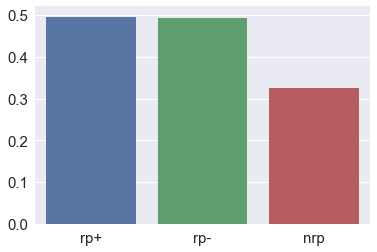

100 g:0.5 c:0.1 w:0.05 mi:-0.025 ma:0.05


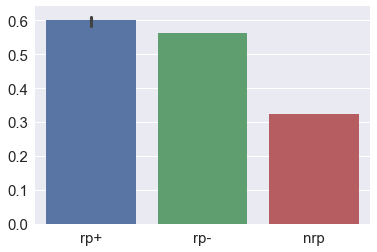

101 g:0.5 c:0.1 w:0.05 mi:-0.025 ma:0.1


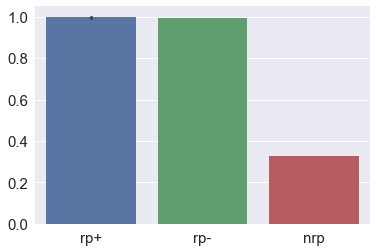

102 g:0.5 c:0.1 w:0.05 mi:-0.05 ma:0.025


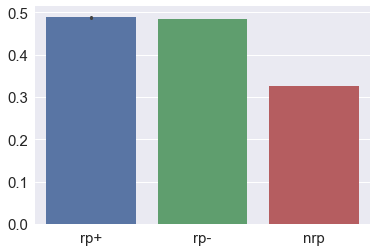

103 g:0.5 c:0.1 w:0.05 mi:-0.05 ma:0.05


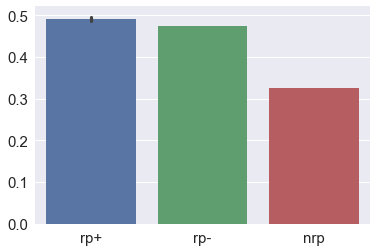

104 g:0.5 c:0.1 w:0.05 mi:-0.05 ma:0.1


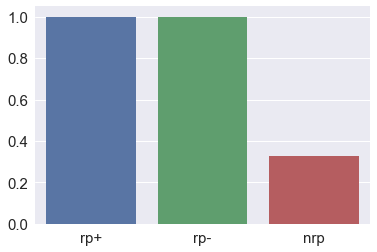

105 g:0.5 c:0.1 w:0.05 mi:-0.1 ma:0.025


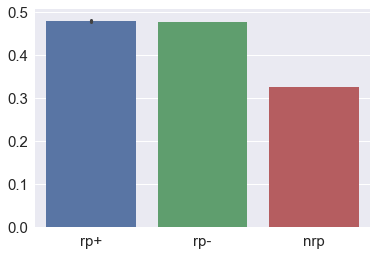

106 g:0.5 c:0.1 w:0.05 mi:-0.1 ma:0.05


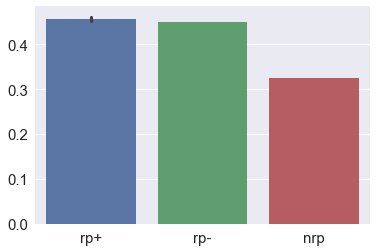

107 g:0.5 c:0.1 w:0.05 mi:-0.1 ma:0.1


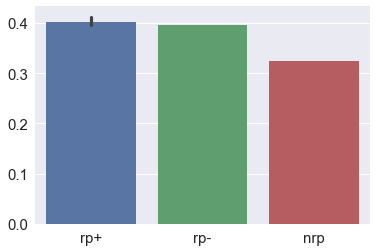

108 g:0.5 c:0.1 w:0.1 mi:-0.025 ma:0.025


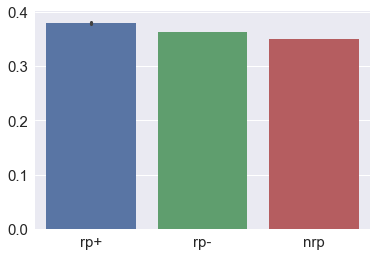

109 g:0.5 c:0.1 w:0.1 mi:-0.025 ma:0.05


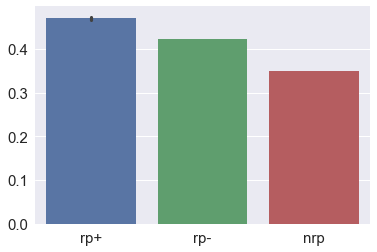

110 g:0.5 c:0.1 w:0.1 mi:-0.025 ma:0.1


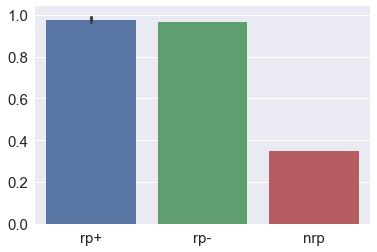

111 g:0.5 c:0.1 w:0.1 mi:-0.05 ma:0.025


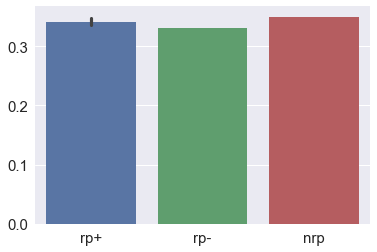

112 g:0.5 c:0.1 w:0.1 mi:-0.05 ma:0.05


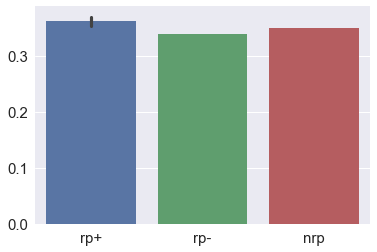

113 g:0.5 c:0.1 w:0.1 mi:-0.05 ma:0.1


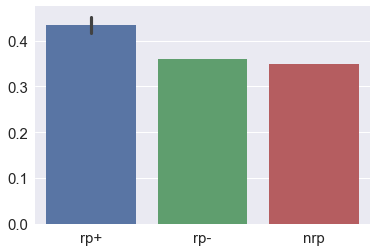

114 g:0.5 c:0.1 w:0.1 mi:-0.1 ma:0.025


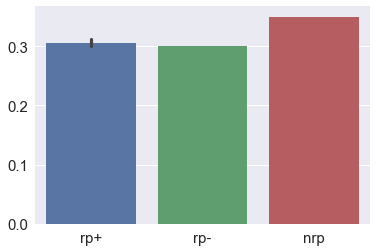

115 g:0.5 c:0.1 w:0.1 mi:-0.1 ma:0.05


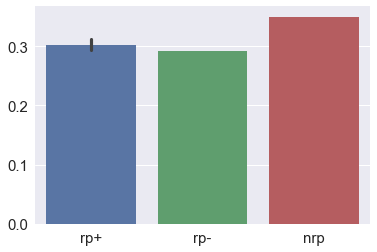

116 g:0.5 c:0.1 w:0.1 mi:-0.1 ma:0.1


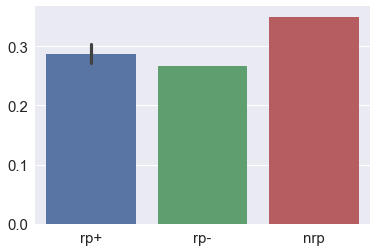

117 g:0.5 c:0.1 w:0.15 mi:-0.025 ma:0.025


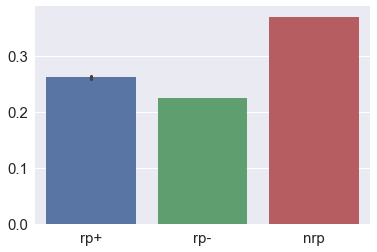

118 g:0.5 c:0.1 w:0.15 mi:-0.025 ma:0.05


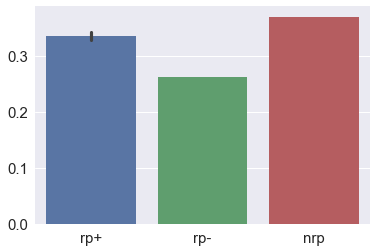

119 g:0.5 c:0.1 w:0.15 mi:-0.025 ma:0.1


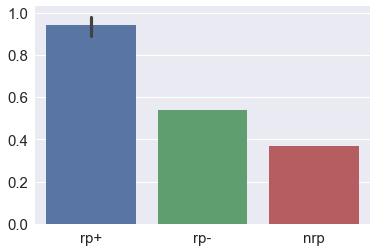

120 g:0.5 c:0.1 w:0.15 mi:-0.05 ma:0.025


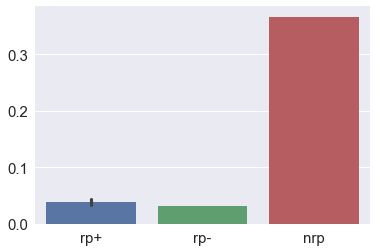

121 g:0.5 c:0.1 w:0.15 mi:-0.05 ma:0.05


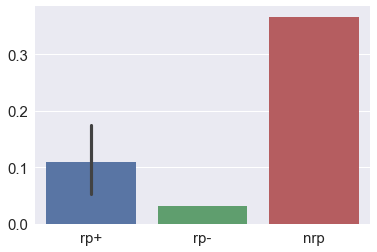

122 g:0.5 c:0.1 w:0.15 mi:-0.05 ma:0.1


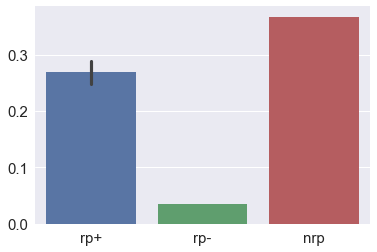

123 g:0.5 c:0.1 w:0.15 mi:-0.1 ma:0.025


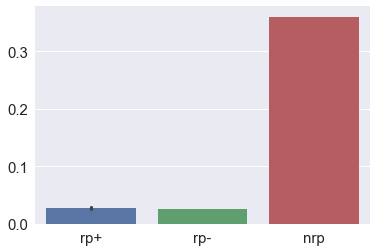

124 g:0.5 c:0.1 w:0.15 mi:-0.1 ma:0.05


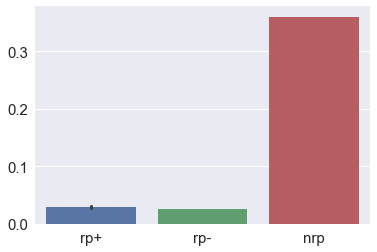

125 g:0.5 c:0.1 w:0.15 mi:-0.1 ma:0.1


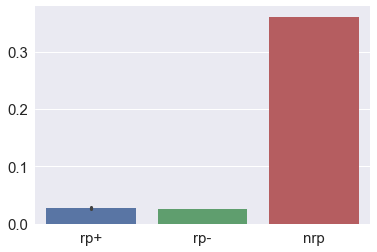

126 g:0.5 c:0.15 w:0.05 mi:-0.025 ma:0.025


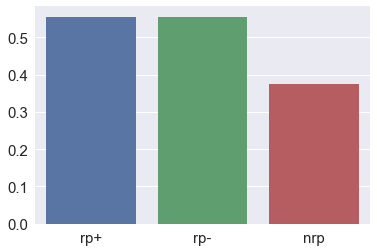

127 g:0.5 c:0.15 w:0.05 mi:-0.025 ma:0.05


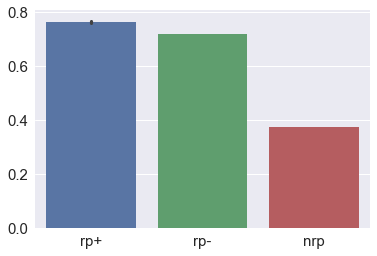

128 g:0.5 c:0.15 w:0.05 mi:-0.025 ma:0.1


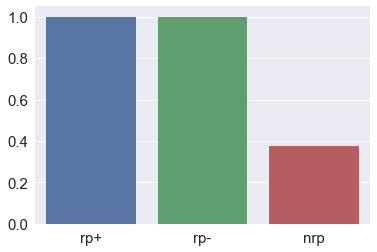

129 g:0.5 c:0.15 w:0.05 mi:-0.05 ma:0.025


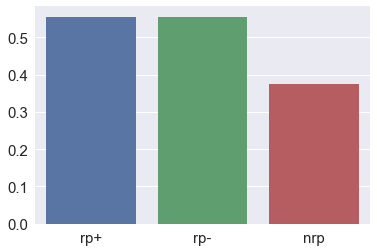

130 g:0.5 c:0.15 w:0.05 mi:-0.05 ma:0.05


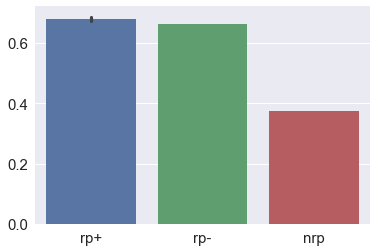

131 g:0.5 c:0.15 w:0.05 mi:-0.05 ma:0.1


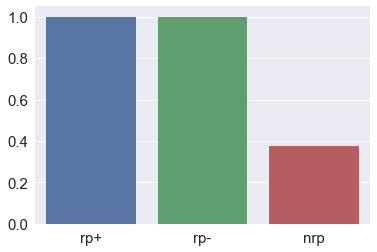

132 g:0.5 c:0.15 w:0.05 mi:-0.1 ma:0.025


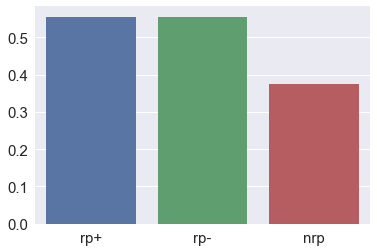

133 g:0.5 c:0.15 w:0.05 mi:-0.1 ma:0.05


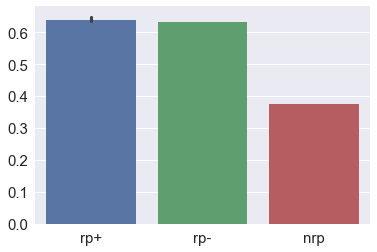

134 g:0.5 c:0.15 w:0.05 mi:-0.1 ma:0.1


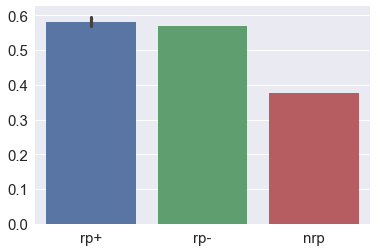

135 g:0.5 c:0.15 w:0.1 mi:-0.025 ma:0.025


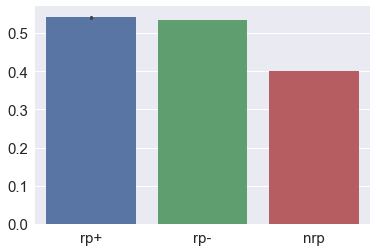

136 g:0.5 c:0.15 w:0.1 mi:-0.025 ma:0.05


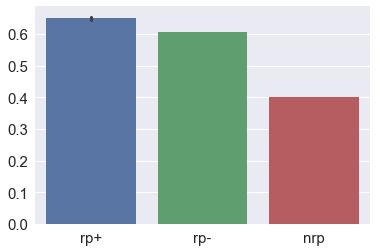

137 g:0.5 c:0.15 w:0.1 mi:-0.025 ma:0.1


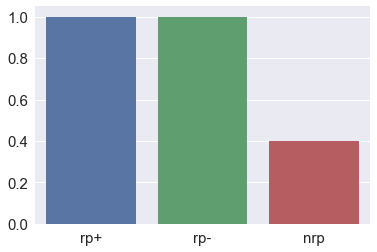

138 g:0.5 c:0.15 w:0.1 mi:-0.05 ma:0.025


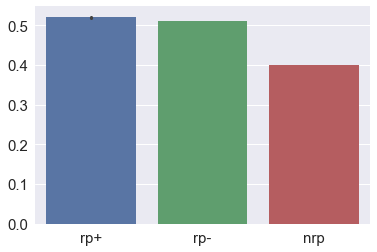

139 g:0.5 c:0.15 w:0.1 mi:-0.05 ma:0.05


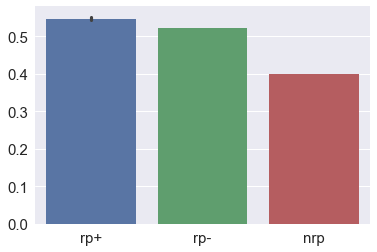

140 g:0.5 c:0.15 w:0.1 mi:-0.05 ma:0.1


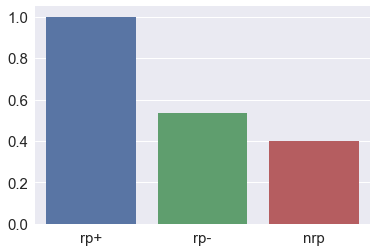

141 g:0.5 c:0.15 w:0.1 mi:-0.1 ma:0.025


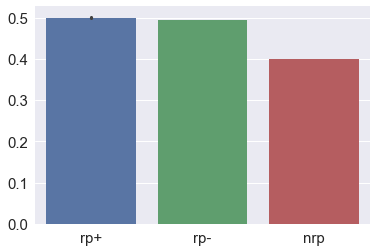

142 g:0.5 c:0.15 w:0.1 mi:-0.1 ma:0.05


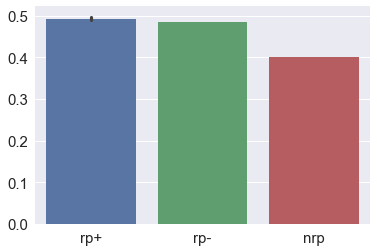

143 g:0.5 c:0.15 w:0.1 mi:-0.1 ma:0.1


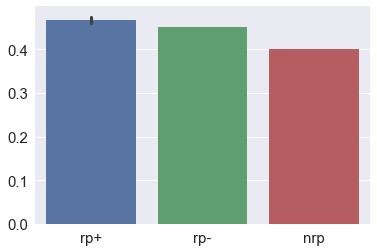

144 g:0.5 c:0.15 w:0.15 mi:-0.025 ma:0.025


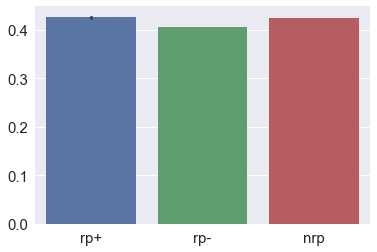

145 g:0.5 c:0.15 w:0.15 mi:-0.025 ma:0.05


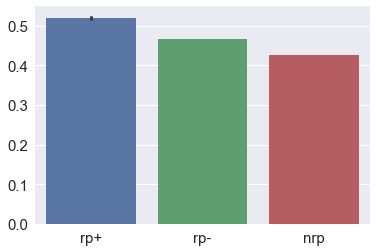

146 g:0.5 c:0.15 w:0.15 mi:-0.025 ma:0.1


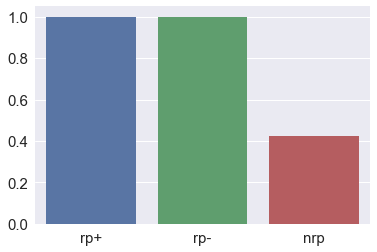

147 g:0.5 c:0.15 w:0.15 mi:-0.05 ma:0.025


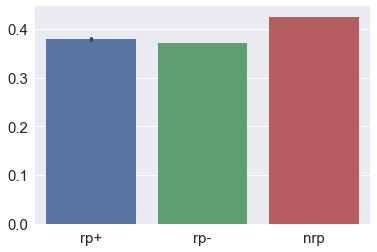

148 g:0.5 c:0.15 w:0.15 mi:-0.05 ma:0.05


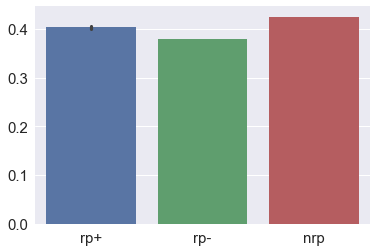

149 g:0.5 c:0.15 w:0.15 mi:-0.05 ma:0.1


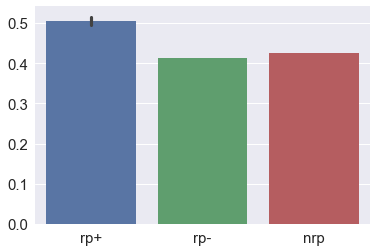

150 g:0.5 c:0.15 w:0.15 mi:-0.1 ma:0.025


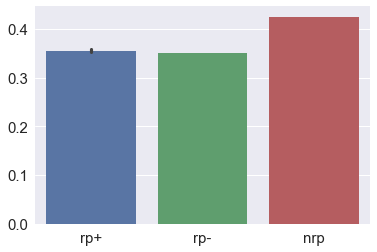

151 g:0.5 c:0.15 w:0.15 mi:-0.1 ma:0.05


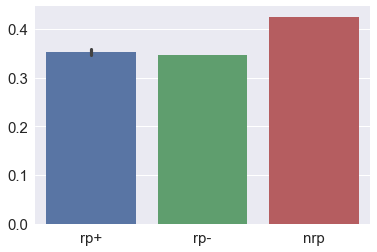

152 g:0.5 c:0.15 w:0.15 mi:-0.1 ma:0.1


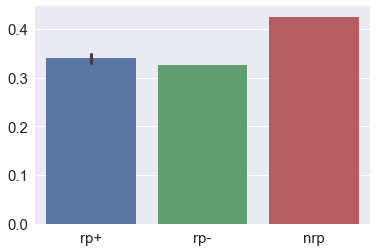

153 g:0.5 c:0.15 w:0.2 mi:-0.025 ma:0.025


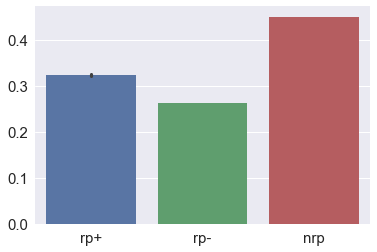

154 g:0.5 c:0.15 w:0.2 mi:-0.025 ma:0.05


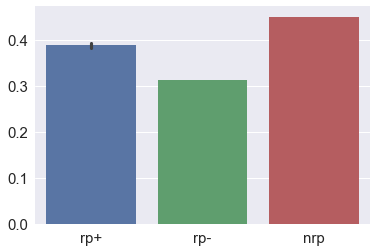

155 g:0.5 c:0.15 w:0.2 mi:-0.025 ma:0.1


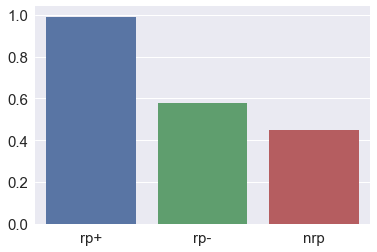

156 g:0.5 c:0.15 w:0.2 mi:-0.05 ma:0.025


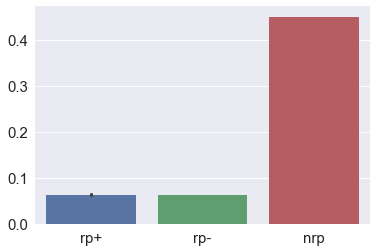

157 g:0.5 c:0.15 w:0.2 mi:-0.05 ma:0.05


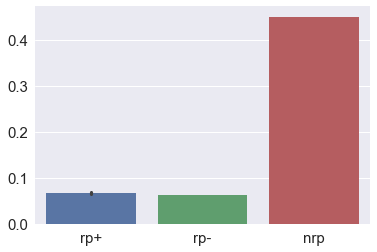

158 g:0.5 c:0.15 w:0.2 mi:-0.05 ma:0.1


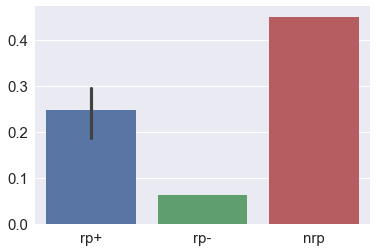

159 g:0.5 c:0.15 w:0.2 mi:-0.1 ma:0.025


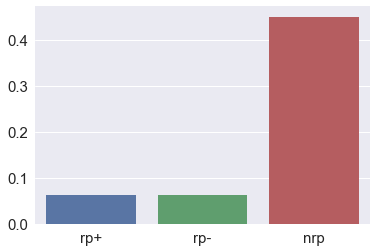

160 g:0.5 c:0.15 w:0.2 mi:-0.1 ma:0.05


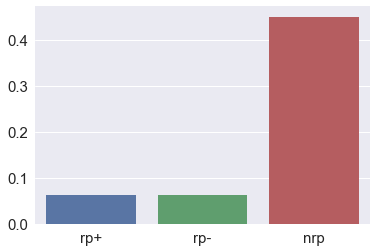

161 g:0.5 c:0.15 w:0.2 mi:-0.1 ma:0.1


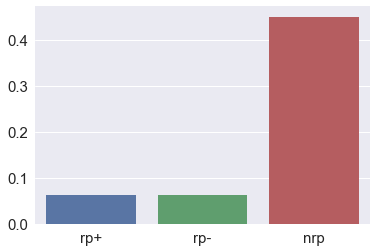

162 g:0.5 c:0.2 w:0.05 mi:-0.025 ma:0.025


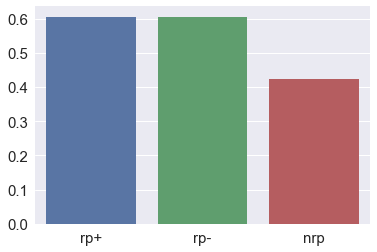

163 g:0.5 c:0.2 w:0.05 mi:-0.025 ma:0.05


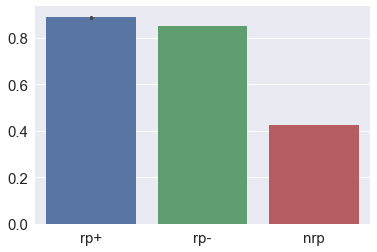

164 g:0.5 c:0.2 w:0.05 mi:-0.025 ma:0.1


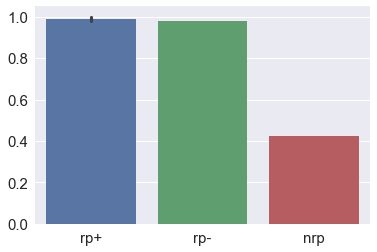

165 g:0.5 c:0.2 w:0.05 mi:-0.05 ma:0.025


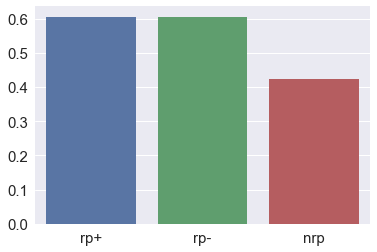

166 g:0.5 c:0.2 w:0.05 mi:-0.05 ma:0.05


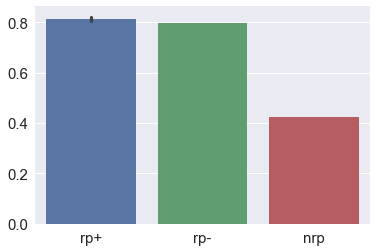

167 g:0.5 c:0.2 w:0.05 mi:-0.05 ma:0.1


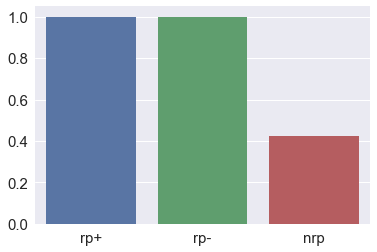

168 g:0.5 c:0.2 w:0.05 mi:-0.1 ma:0.025


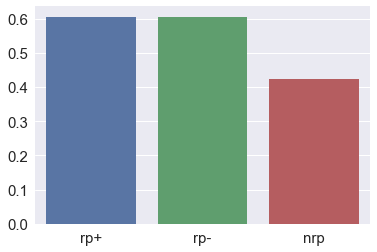

169 g:0.5 c:0.2 w:0.05 mi:-0.1 ma:0.05


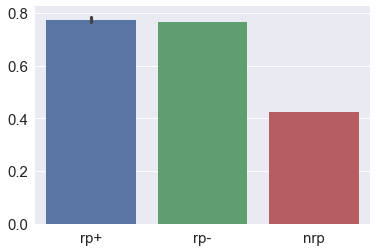

170 g:0.5 c:0.2 w:0.05 mi:-0.1 ma:0.1


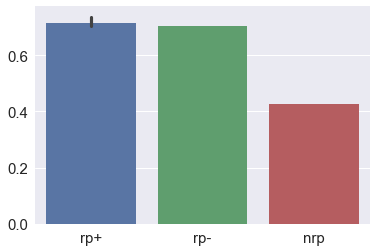

171 g:0.5 c:0.2 w:0.1 mi:-0.025 ma:0.025


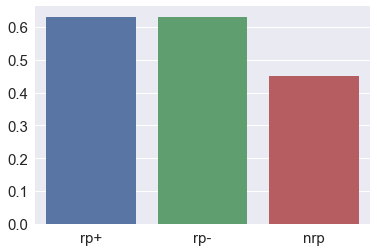

172 g:0.5 c:0.2 w:0.1 mi:-0.025 ma:0.05


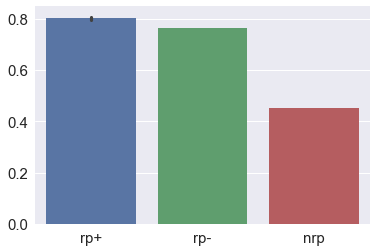

173 g:0.5 c:0.2 w:0.1 mi:-0.025 ma:0.1


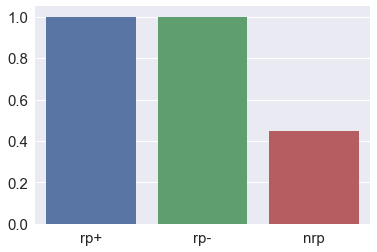

174 g:0.5 c:0.2 w:0.1 mi:-0.05 ma:0.025


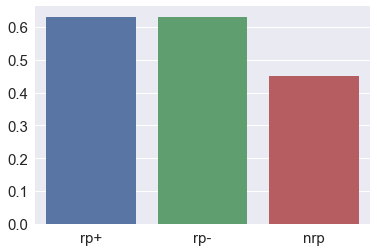

175 g:0.5 c:0.2 w:0.1 mi:-0.05 ma:0.05


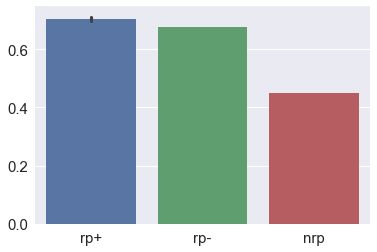

176 g:0.5 c:0.2 w:0.1 mi:-0.05 ma:0.1


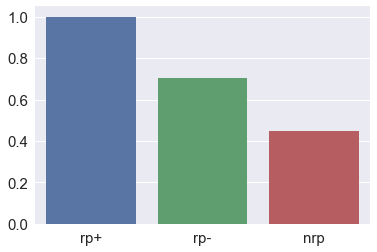

177 g:0.5 c:0.2 w:0.1 mi:-0.1 ma:0.025


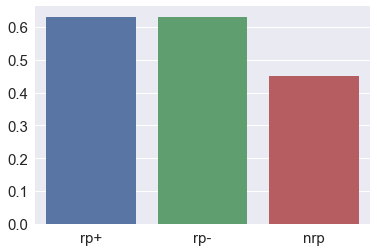

178 g:0.5 c:0.2 w:0.1 mi:-0.1 ma:0.05


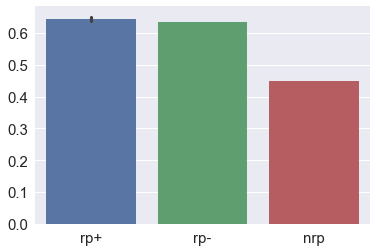

179 g:0.5 c:0.2 w:0.1 mi:-0.1 ma:0.1


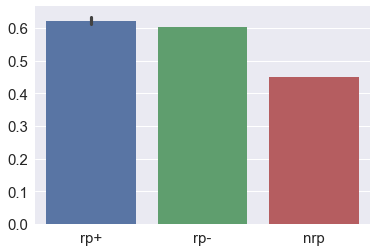

180 g:0.5 c:0.2 w:0.15 mi:-0.025 ma:0.025


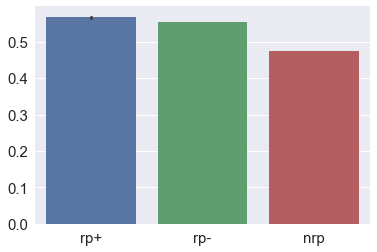

181 g:0.5 c:0.2 w:0.15 mi:-0.025 ma:0.05


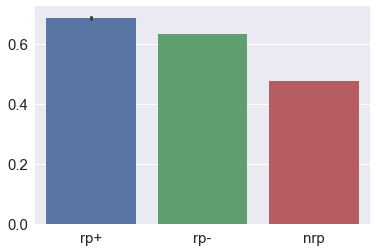

182 g:0.5 c:0.2 w:0.15 mi:-0.025 ma:0.1


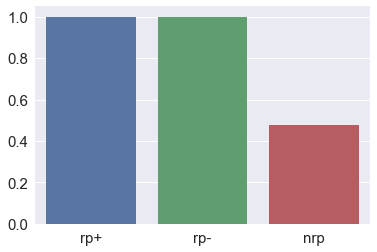

183 g:0.5 c:0.2 w:0.15 mi:-0.05 ma:0.025


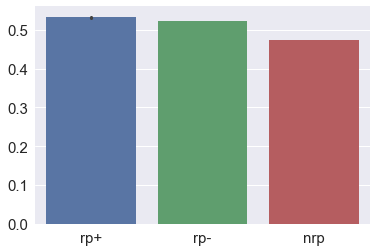

184 g:0.5 c:0.2 w:0.15 mi:-0.05 ma:0.05


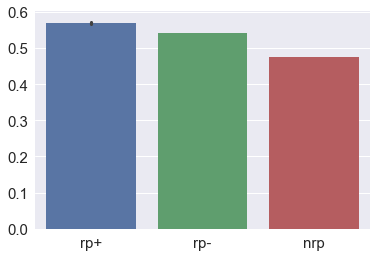

185 g:0.5 c:0.2 w:0.15 mi:-0.05 ma:0.1


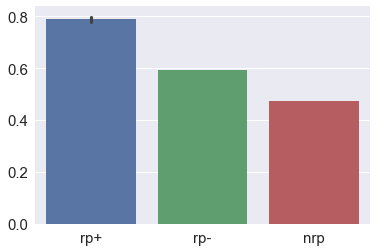

186 g:0.5 c:0.2 w:0.15 mi:-0.1 ma:0.025


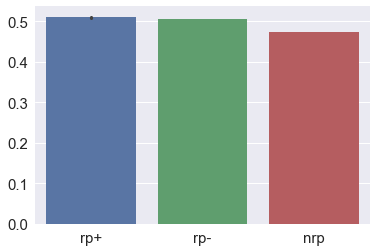

187 g:0.5 c:0.2 w:0.15 mi:-0.1 ma:0.05


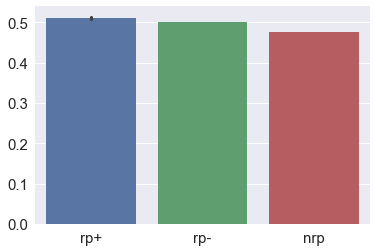

188 g:0.5 c:0.2 w:0.15 mi:-0.1 ma:0.1


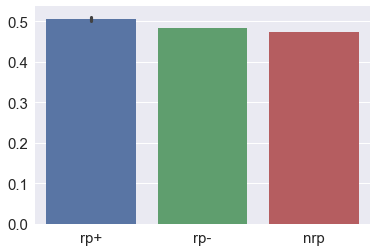

189 g:0.5 c:0.2 w:0.2 mi:-0.025 ma:0.025


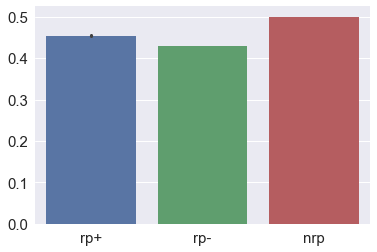

190 g:0.5 c:0.2 w:0.2 mi:-0.025 ma:0.05


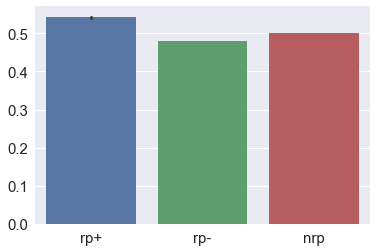

191 g:0.5 c:0.2 w:0.2 mi:-0.025 ma:0.1


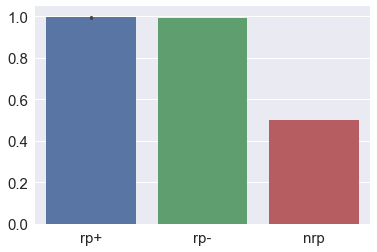

192 g:0.5 c:0.2 w:0.2 mi:-0.05 ma:0.025


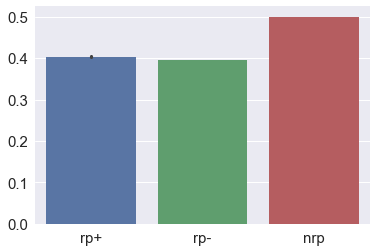

193 g:0.5 c:0.2 w:0.2 mi:-0.05 ma:0.05


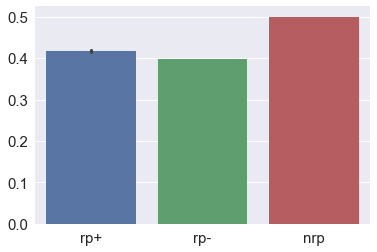

194 g:0.5 c:0.2 w:0.2 mi:-0.05 ma:0.1


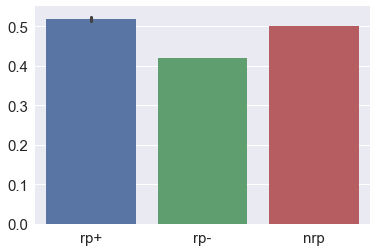

195 g:0.5 c:0.2 w:0.2 mi:-0.1 ma:0.025


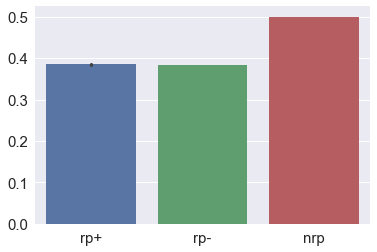

196 g:0.5 c:0.2 w:0.2 mi:-0.1 ma:0.05


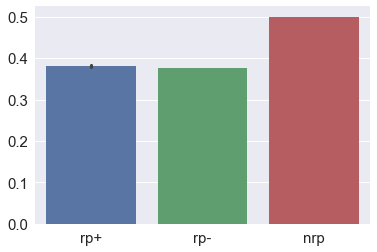

197 g:0.5 c:0.2 w:0.2 mi:-0.1 ma:0.1


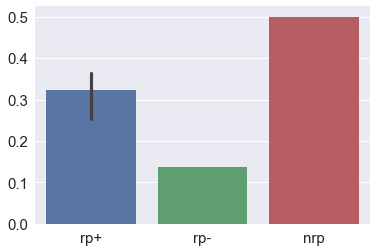

198 g:0.8 c:0.1 w:0.05 mi:-0.025 ma:0.025


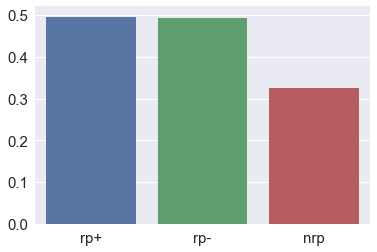

199 g:0.8 c:0.1 w:0.05 mi:-0.025 ma:0.05


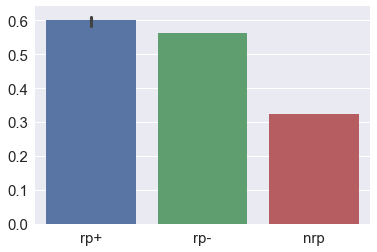

200 g:0.8 c:0.1 w:0.05 mi:-0.025 ma:0.1


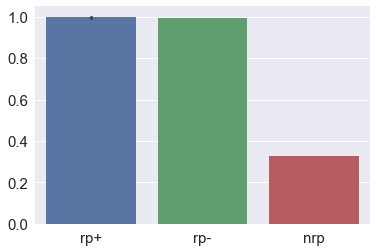

201 g:0.8 c:0.1 w:0.05 mi:-0.05 ma:0.025


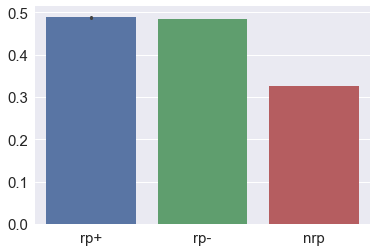

202 g:0.8 c:0.1 w:0.05 mi:-0.05 ma:0.05


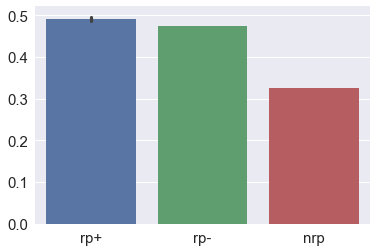

203 g:0.8 c:0.1 w:0.05 mi:-0.05 ma:0.1


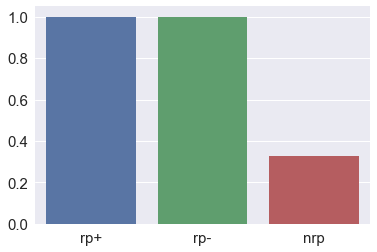

204 g:0.8 c:0.1 w:0.05 mi:-0.1 ma:0.025


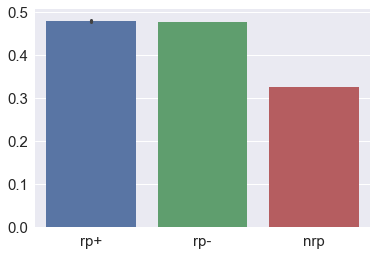

205 g:0.8 c:0.1 w:0.05 mi:-0.1 ma:0.05


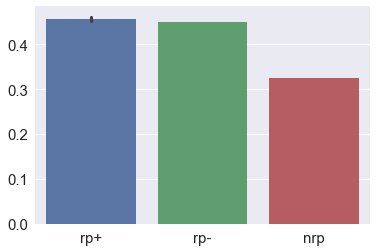

206 g:0.8 c:0.1 w:0.05 mi:-0.1 ma:0.1


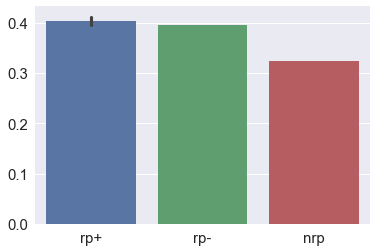

207 g:0.8 c:0.1 w:0.1 mi:-0.025 ma:0.025


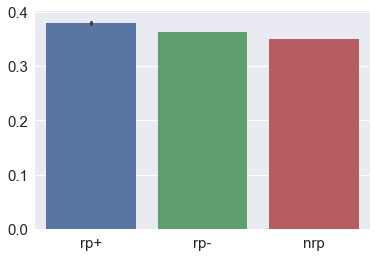

208 g:0.8 c:0.1 w:0.1 mi:-0.025 ma:0.05


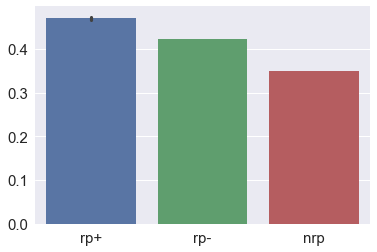

209 g:0.8 c:0.1 w:0.1 mi:-0.025 ma:0.1


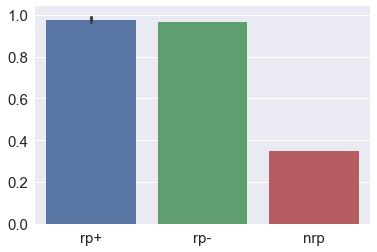

210 g:0.8 c:0.1 w:0.1 mi:-0.05 ma:0.025


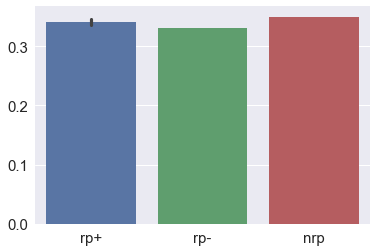

211 g:0.8 c:0.1 w:0.1 mi:-0.05 ma:0.05


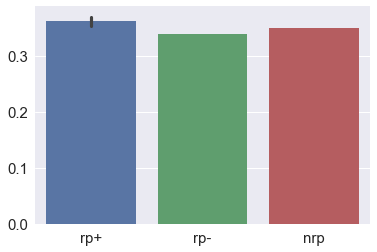

212 g:0.8 c:0.1 w:0.1 mi:-0.05 ma:0.1


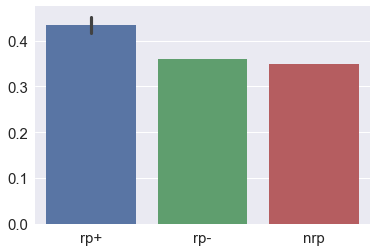

213 g:0.8 c:0.1 w:0.1 mi:-0.1 ma:0.025


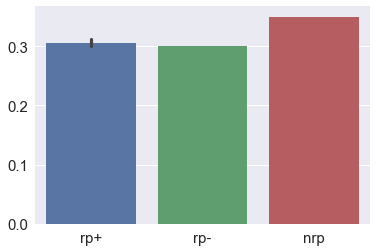

214 g:0.8 c:0.1 w:0.1 mi:-0.1 ma:0.05


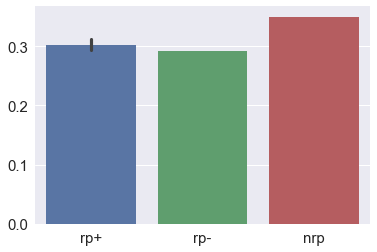

215 g:0.8 c:0.1 w:0.1 mi:-0.1 ma:0.1


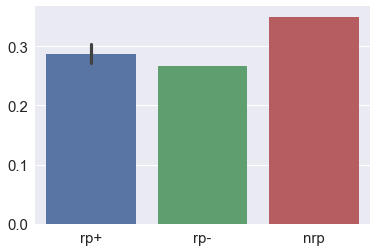

216 g:0.8 c:0.1 w:0.15 mi:-0.025 ma:0.025


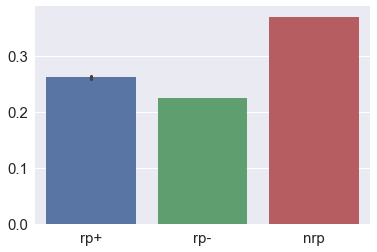

217 g:0.8 c:0.1 w:0.15 mi:-0.025 ma:0.05


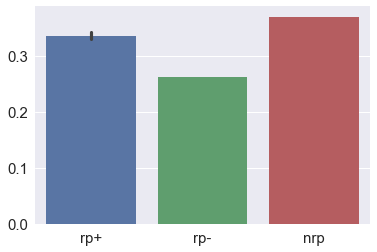

218 g:0.8 c:0.1 w:0.15 mi:-0.025 ma:0.1


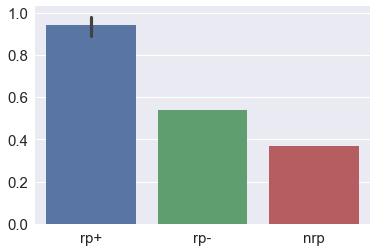

219 g:0.8 c:0.1 w:0.15 mi:-0.05 ma:0.025


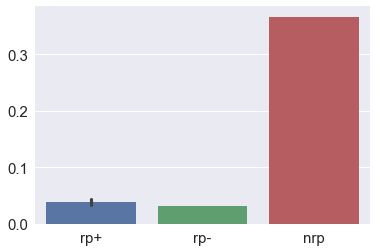

220 g:0.8 c:0.1 w:0.15 mi:-0.05 ma:0.05


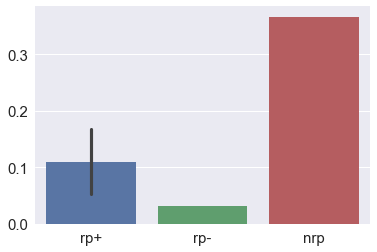

221 g:0.8 c:0.1 w:0.15 mi:-0.05 ma:0.1


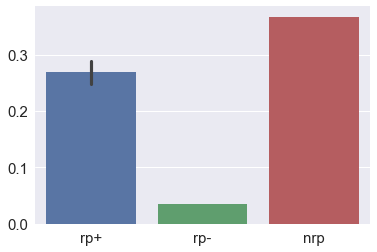

222 g:0.8 c:0.1 w:0.15 mi:-0.1 ma:0.025


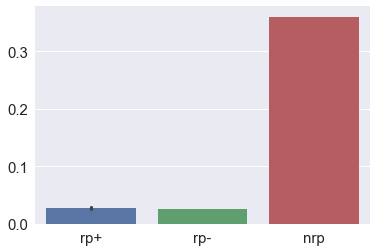

223 g:0.8 c:0.1 w:0.15 mi:-0.1 ma:0.05


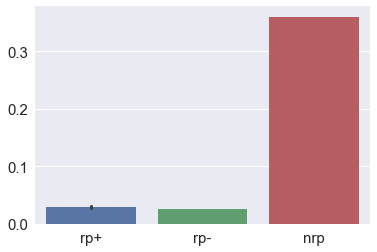

224 g:0.8 c:0.1 w:0.15 mi:-0.1 ma:0.1


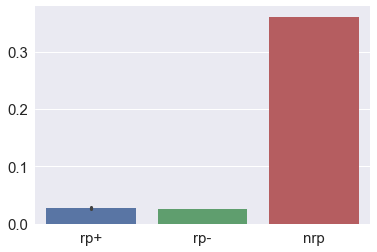

225 g:0.8 c:0.15 w:0.05 mi:-0.025 ma:0.025


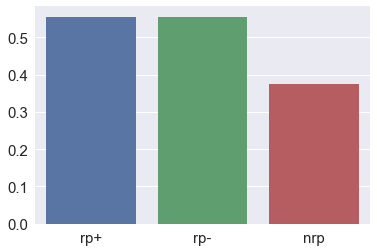

226 g:0.8 c:0.15 w:0.05 mi:-0.025 ma:0.05


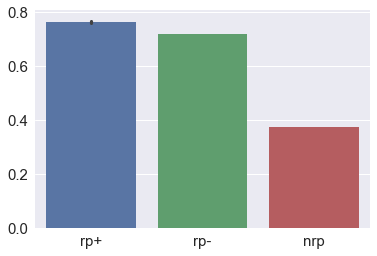

227 g:0.8 c:0.15 w:0.05 mi:-0.025 ma:0.1


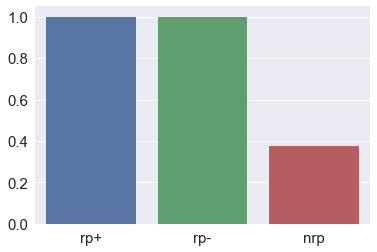

228 g:0.8 c:0.15 w:0.05 mi:-0.05 ma:0.025


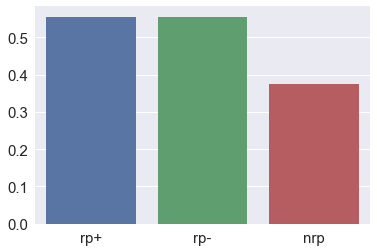

229 g:0.8 c:0.15 w:0.05 mi:-0.05 ma:0.05


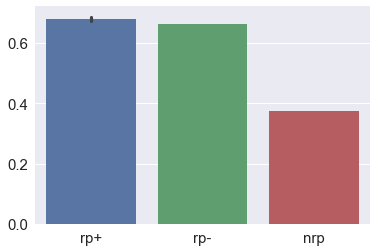

230 g:0.8 c:0.15 w:0.05 mi:-0.05 ma:0.1


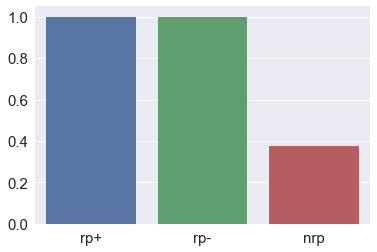

231 g:0.8 c:0.15 w:0.05 mi:-0.1 ma:0.025


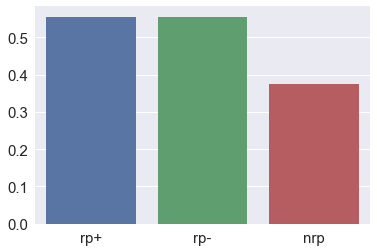

232 g:0.8 c:0.15 w:0.05 mi:-0.1 ma:0.05


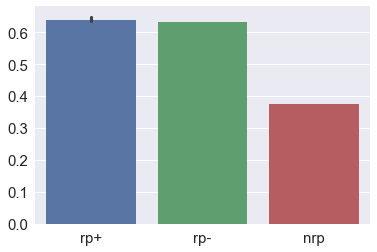

233 g:0.8 c:0.15 w:0.05 mi:-0.1 ma:0.1


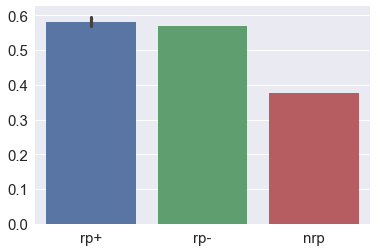

234 g:0.8 c:0.15 w:0.1 mi:-0.025 ma:0.025


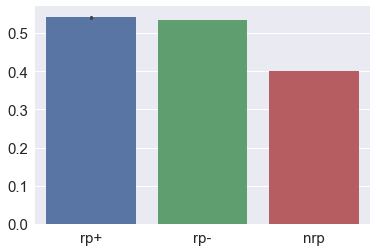

235 g:0.8 c:0.15 w:0.1 mi:-0.025 ma:0.05


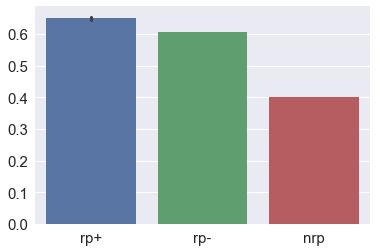

236 g:0.8 c:0.15 w:0.1 mi:-0.025 ma:0.1


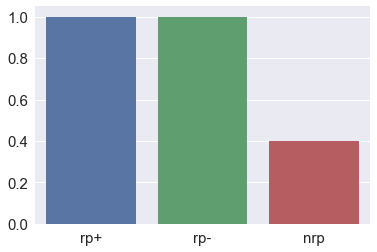

237 g:0.8 c:0.15 w:0.1 mi:-0.05 ma:0.025


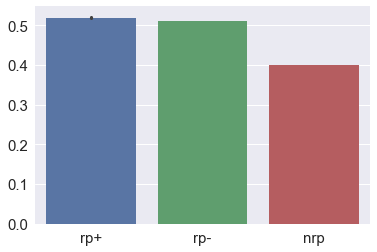

238 g:0.8 c:0.15 w:0.1 mi:-0.05 ma:0.05


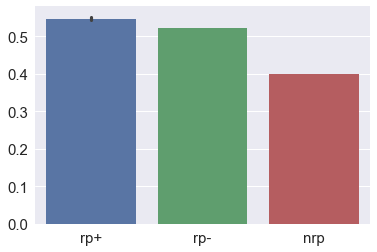

239 g:0.8 c:0.15 w:0.1 mi:-0.05 ma:0.1


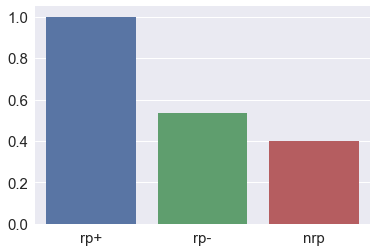

240 g:0.8 c:0.15 w:0.1 mi:-0.1 ma:0.025


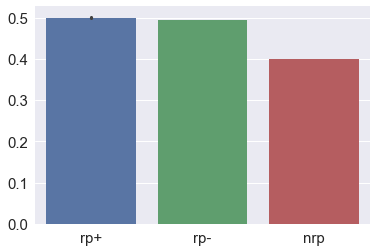

241 g:0.8 c:0.15 w:0.1 mi:-0.1 ma:0.05


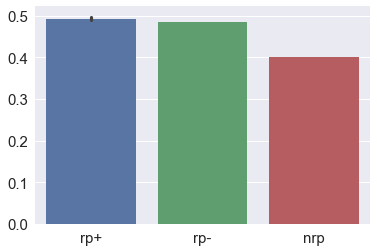

242 g:0.8 c:0.15 w:0.1 mi:-0.1 ma:0.1


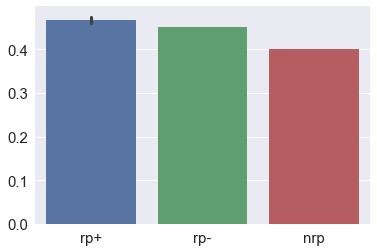

243 g:0.8 c:0.15 w:0.15 mi:-0.025 ma:0.025


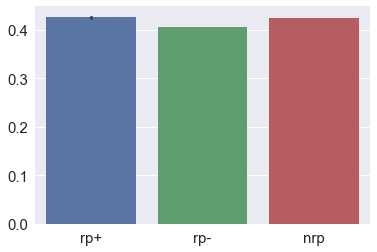

244 g:0.8 c:0.15 w:0.15 mi:-0.025 ma:0.05


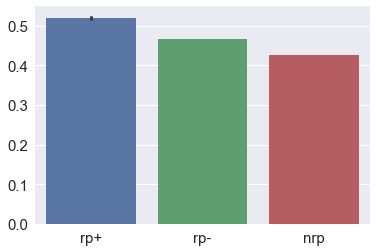

245 g:0.8 c:0.15 w:0.15 mi:-0.025 ma:0.1


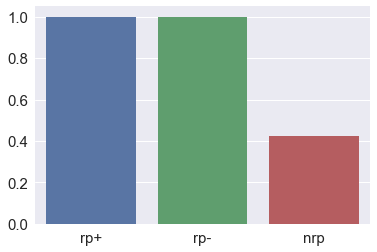

246 g:0.8 c:0.15 w:0.15 mi:-0.05 ma:0.025


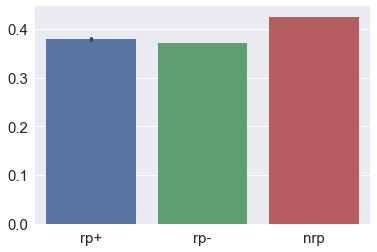

247 g:0.8 c:0.15 w:0.15 mi:-0.05 ma:0.05


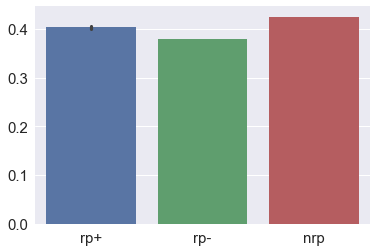

248 g:0.8 c:0.15 w:0.15 mi:-0.05 ma:0.1


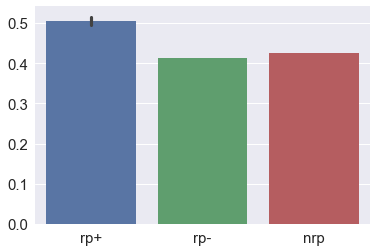

249 g:0.8 c:0.15 w:0.15 mi:-0.1 ma:0.025


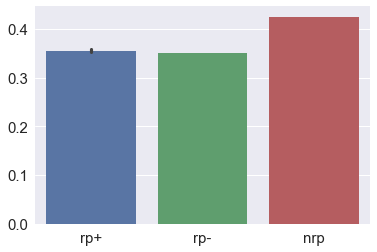

250 g:0.8 c:0.15 w:0.15 mi:-0.1 ma:0.05


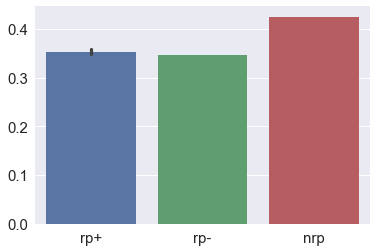

251 g:0.8 c:0.15 w:0.15 mi:-0.1 ma:0.1


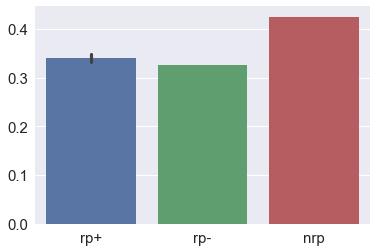

252 g:0.8 c:0.15 w:0.2 mi:-0.025 ma:0.025


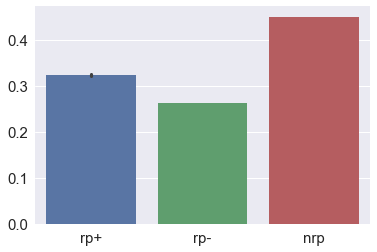

253 g:0.8 c:0.15 w:0.2 mi:-0.025 ma:0.05


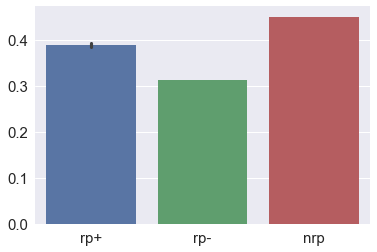

254 g:0.8 c:0.15 w:0.2 mi:-0.025 ma:0.1


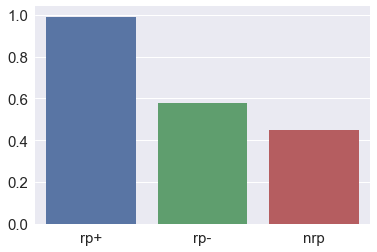

255 g:0.8 c:0.15 w:0.2 mi:-0.05 ma:0.025


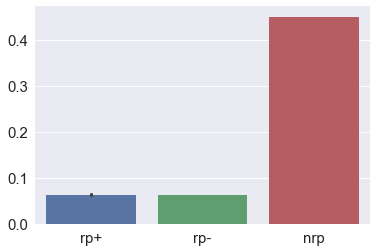

256 g:0.8 c:0.15 w:0.2 mi:-0.05 ma:0.05


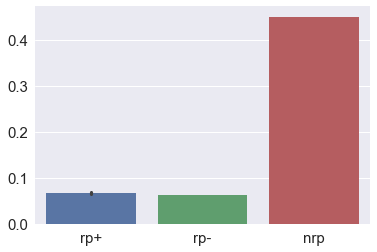

257 g:0.8 c:0.15 w:0.2 mi:-0.05 ma:0.1


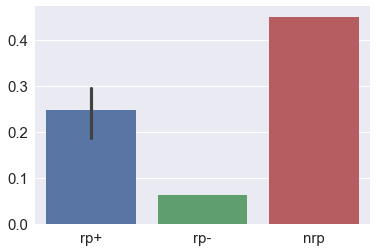

258 g:0.8 c:0.15 w:0.2 mi:-0.1 ma:0.025


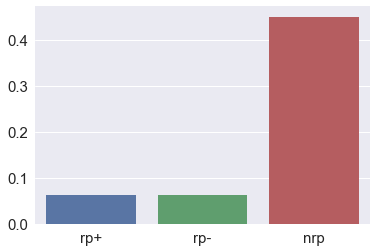

259 g:0.8 c:0.15 w:0.2 mi:-0.1 ma:0.05


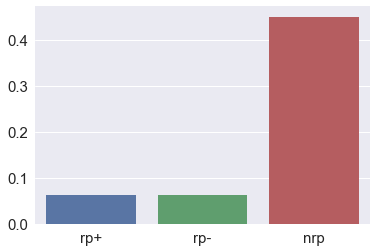

260 g:0.8 c:0.15 w:0.2 mi:-0.1 ma:0.1


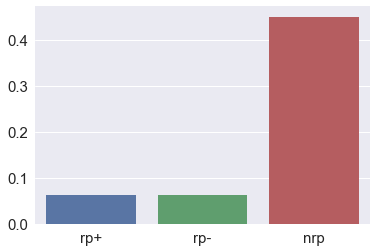

261 g:0.8 c:0.2 w:0.05 mi:-0.025 ma:0.025


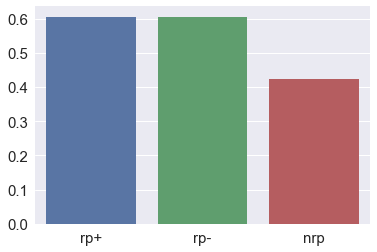

262 g:0.8 c:0.2 w:0.05 mi:-0.025 ma:0.05


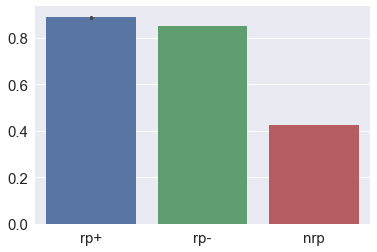

263 g:0.8 c:0.2 w:0.05 mi:-0.025 ma:0.1


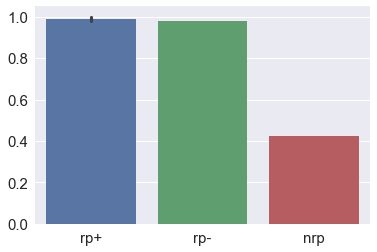

264 g:0.8 c:0.2 w:0.05 mi:-0.05 ma:0.025


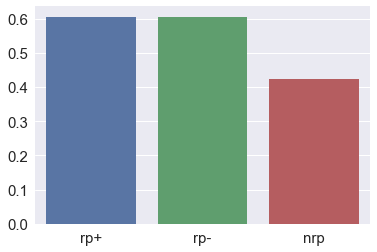

265 g:0.8 c:0.2 w:0.05 mi:-0.05 ma:0.05


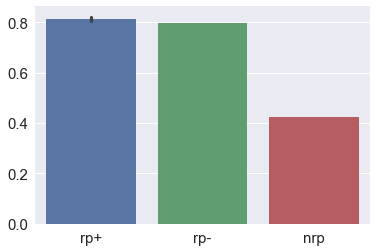

266 g:0.8 c:0.2 w:0.05 mi:-0.05 ma:0.1


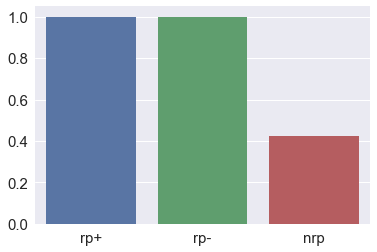

267 g:0.8 c:0.2 w:0.05 mi:-0.1 ma:0.025


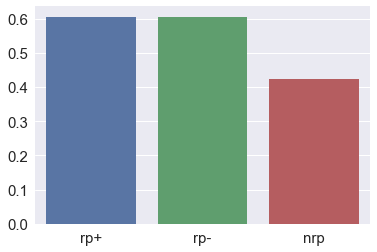

268 g:0.8 c:0.2 w:0.05 mi:-0.1 ma:0.05


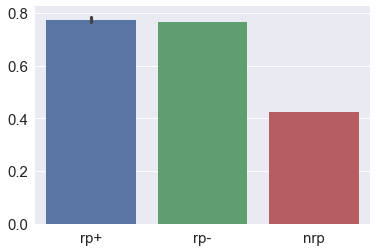

269 g:0.8 c:0.2 w:0.05 mi:-0.1 ma:0.1


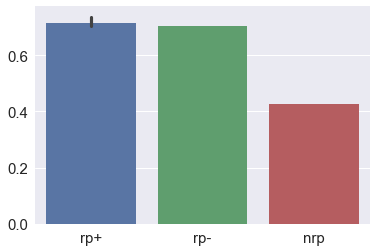

270 g:0.8 c:0.2 w:0.1 mi:-0.025 ma:0.025


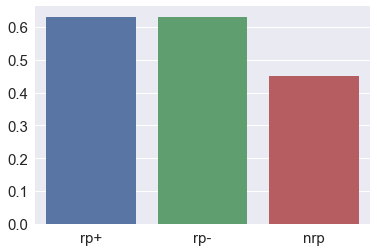

271 g:0.8 c:0.2 w:0.1 mi:-0.025 ma:0.05


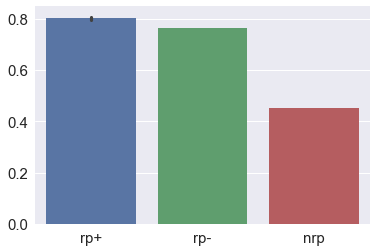

272 g:0.8 c:0.2 w:0.1 mi:-0.025 ma:0.1


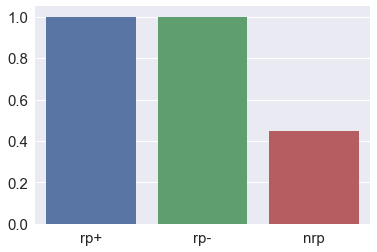

273 g:0.8 c:0.2 w:0.1 mi:-0.05 ma:0.025


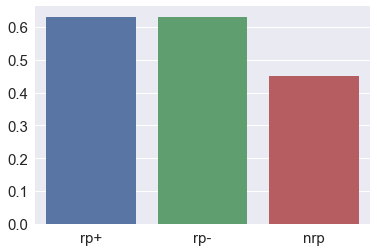

274 g:0.8 c:0.2 w:0.1 mi:-0.05 ma:0.05


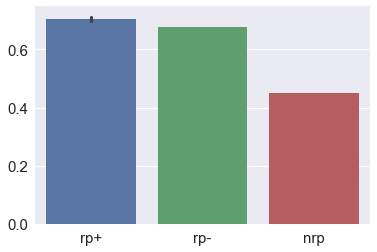

275 g:0.8 c:0.2 w:0.1 mi:-0.05 ma:0.1


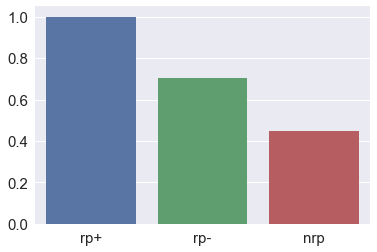

276 g:0.8 c:0.2 w:0.1 mi:-0.1 ma:0.025


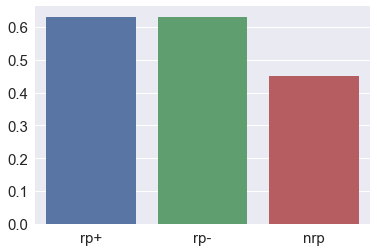

277 g:0.8 c:0.2 w:0.1 mi:-0.1 ma:0.05


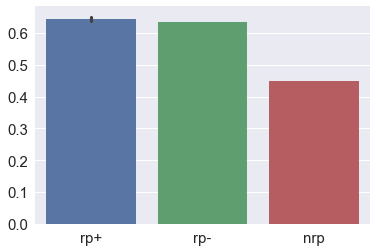

278 g:0.8 c:0.2 w:0.1 mi:-0.1 ma:0.1


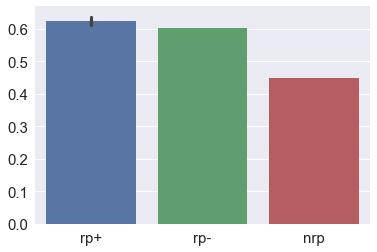

279 g:0.8 c:0.2 w:0.15 mi:-0.025 ma:0.025


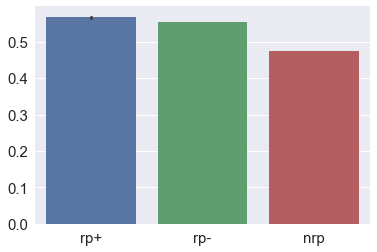

280 g:0.8 c:0.2 w:0.15 mi:-0.025 ma:0.05


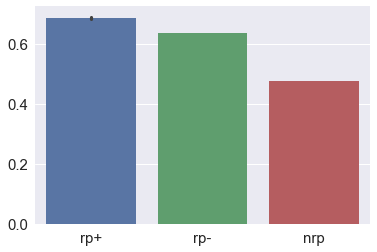

281 g:0.8 c:0.2 w:0.15 mi:-0.025 ma:0.1


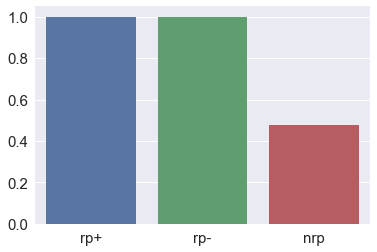

282 g:0.8 c:0.2 w:0.15 mi:-0.05 ma:0.025


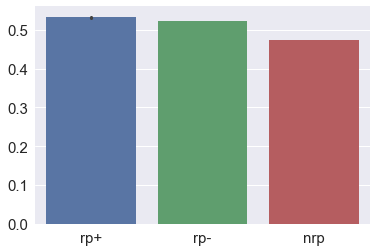

283 g:0.8 c:0.2 w:0.15 mi:-0.05 ma:0.05


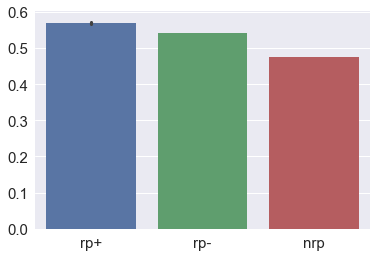

284 g:0.8 c:0.2 w:0.15 mi:-0.05 ma:0.1


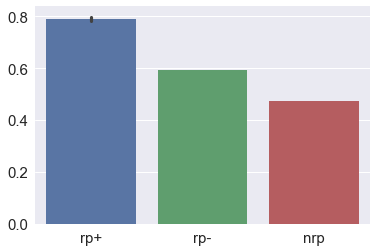

285 g:0.8 c:0.2 w:0.15 mi:-0.1 ma:0.025


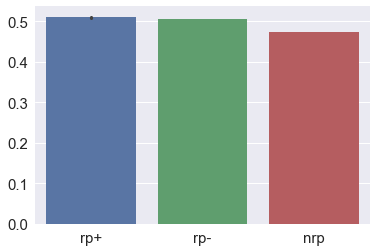

286 g:0.8 c:0.2 w:0.15 mi:-0.1 ma:0.05


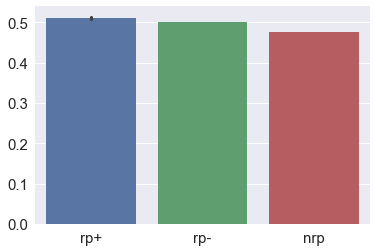

287 g:0.8 c:0.2 w:0.15 mi:-0.1 ma:0.1


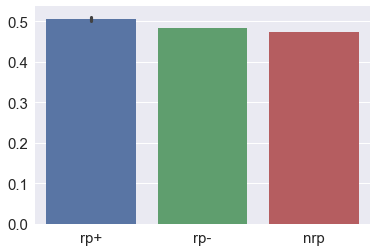

288 g:0.8 c:0.2 w:0.2 mi:-0.025 ma:0.025


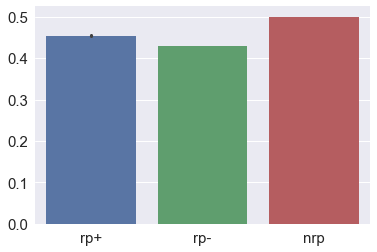

289 g:0.8 c:0.2 w:0.2 mi:-0.025 ma:0.05


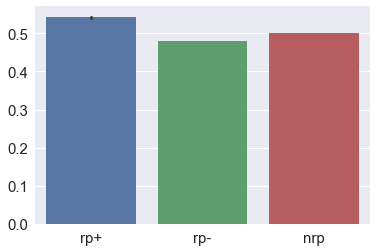

290 g:0.8 c:0.2 w:0.2 mi:-0.025 ma:0.1


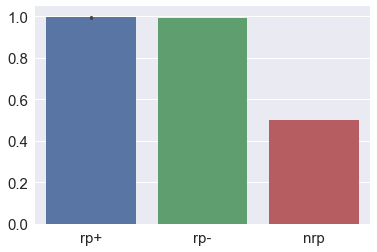

291 g:0.8 c:0.2 w:0.2 mi:-0.05 ma:0.025


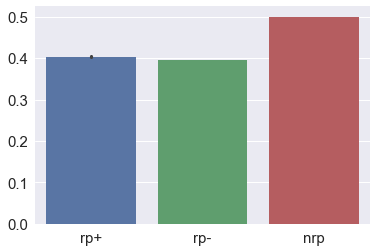

292 g:0.8 c:0.2 w:0.2 mi:-0.05 ma:0.05


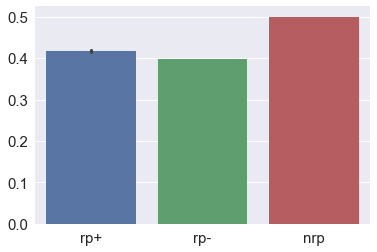

293 g:0.8 c:0.2 w:0.2 mi:-0.05 ma:0.1


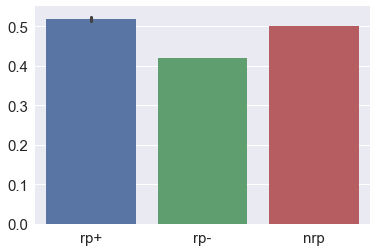

294 g:0.8 c:0.2 w:0.2 mi:-0.1 ma:0.025


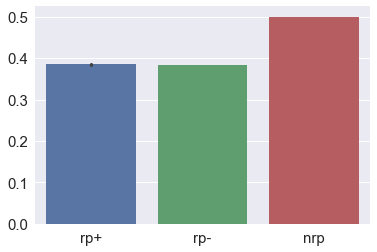

295 g:0.8 c:0.2 w:0.2 mi:-0.1 ma:0.05


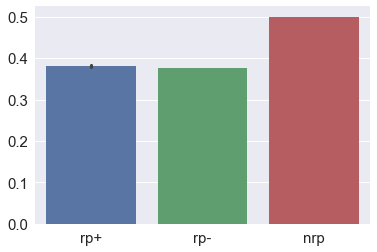

296 g:0.8 c:0.2 w:0.2 mi:-0.1 ma:0.1


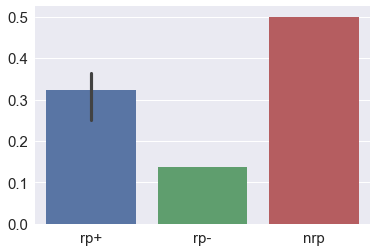

In [743]:
for i, result in enumerate(results):
    print(f"{i} g:{result['gamma']} c:{result['xcat_center']} w:{result['xcat_width']} mi:{result['xcat_min']} ma:{result['xcat_max']}")
    rp_plus = result['graph'].adj[-2, [0, 1, 2, 3]]
    rp_minus = result['graph'].adj[-2, [4, 5, 6, 7]]
    nrp = result['graph'].adj[-1, 8:16]

    ax = sns.barplot(data=[rp_plus, rp_minus, nrp])
    ax.set(xticklabels=['rp+', 'rp-', 'nrp']);
    plt.show();

In [ ]:
149 g:0.5 c:0.15 w:0.15 mi:-0.05 ma:0.1
155 g:0.5 c:0.15 w:0.2 mi:-0.025 ma:0.1
158 g:0.5 c:0.15 w:0.2 mi:-0.05 ma:0.1
185 g:0.5 c:0.2 w:0.15 mi:-0.05 ma:0.1
190 g:0.5 c:0.2 w:0.2 mi:-0.025 ma:0.05
194 g:0.5 c:0.2 w:0.2 mi:-0.05 ma:0.1
                    197 g:0.5 c:0.2 w:0.2 mi:-0.1 ma:0.1
